In [1]:
import os, torch, pickle 
from model import GPT, GPTConfig
from magicab import ETokenizer 

device = "mps" if not torch.cuda.is_available() else "cuda"
out_dir = "checkpoint/base"
# out_dir = "out-enwiki-char"
ckpt_path = os.path.join(out_dir, 'ckpt.pt')
checkpoint = torch.load(ckpt_path, map_location=device)

# Load model 
model = GPT.load_model(checkpoint, device)
model = model.to(device)
model.eval()

# Load tokenizer 
meta_path = os.path.join('data', checkpoint['config']['dataset'], 'meta.pkl')
with open(meta_path, 'rb') as f:
    meta = pickle.load(f)
tok = ETokenizer(char_vocab=meta['itos'])

/var/folders/nn/nbsb8w3570zfgs23h2s0cdzm0000gn/T/ipykernel_32624/1980074258.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt_path, map_locati

number of parameters: 10.66M


In [23]:
tok.save("tokenizer.json")

In [24]:
from magicab import ETokenizer 
tok = ETokenizer.load("tokenizer.json")

In [2]:
from rust_tokenizer import detect_group_token
token_loss = [[1.0,0.4,0.2,0.1,2.0,0.5]]
token_ids = [[1,2,3,4,5,6]]
detect_group_token(token_loss, token_ids, [0.3], None)


([[[2, 3, 4]]],
 [[[1, 2, 3]]],
 [[False, True, True, True, False, False]],
 [[(1, 4, '1', 'green')]])

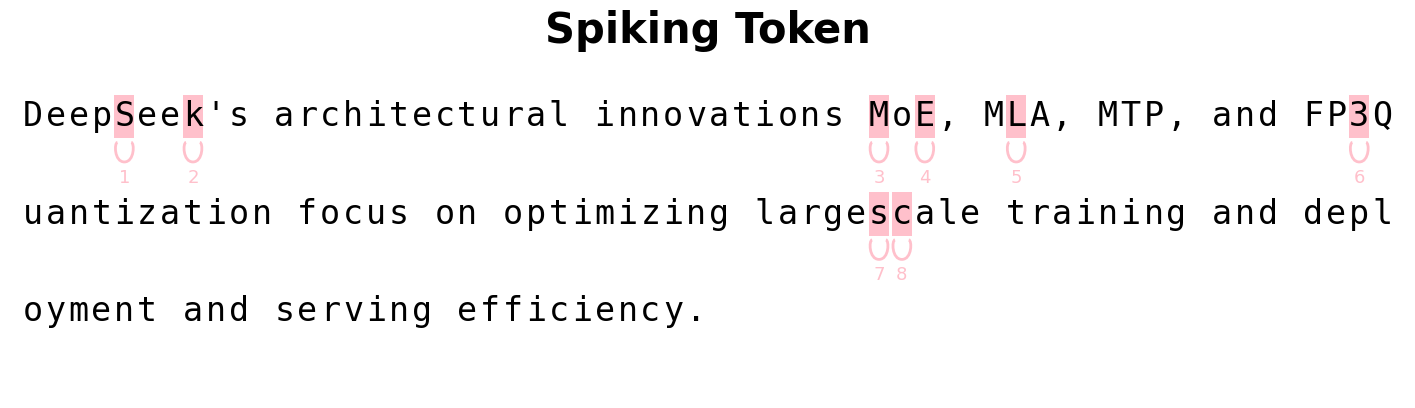

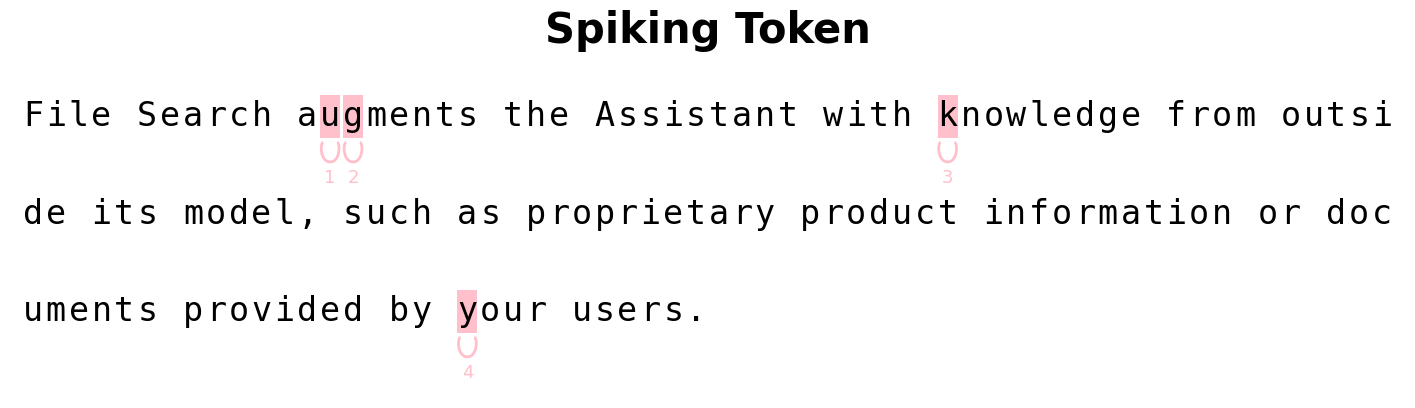

   :: Remove token mask calculation: 0.0004 seconds
   :: Remove token list appending loop: 0.0001 seconds
   :: Remove token group appending loop: 0.0000 seconds


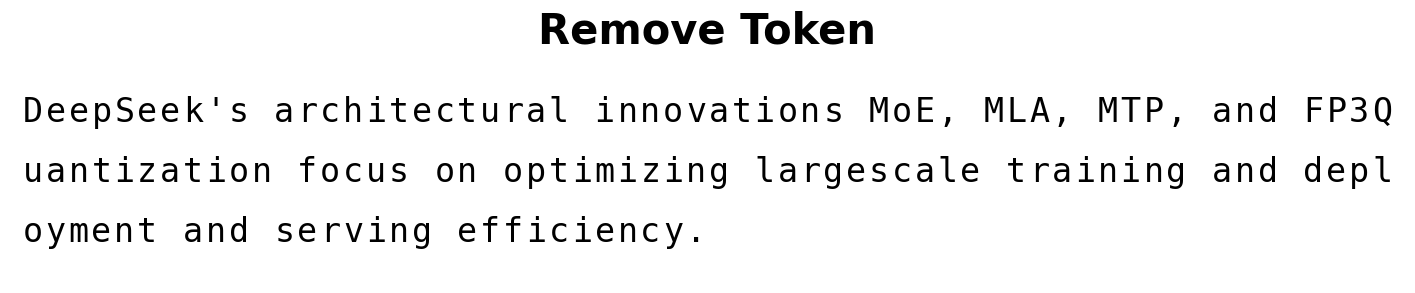

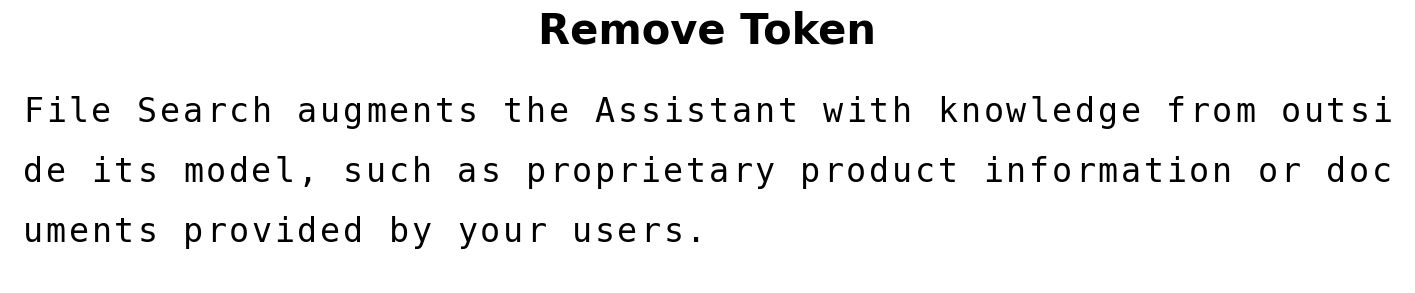

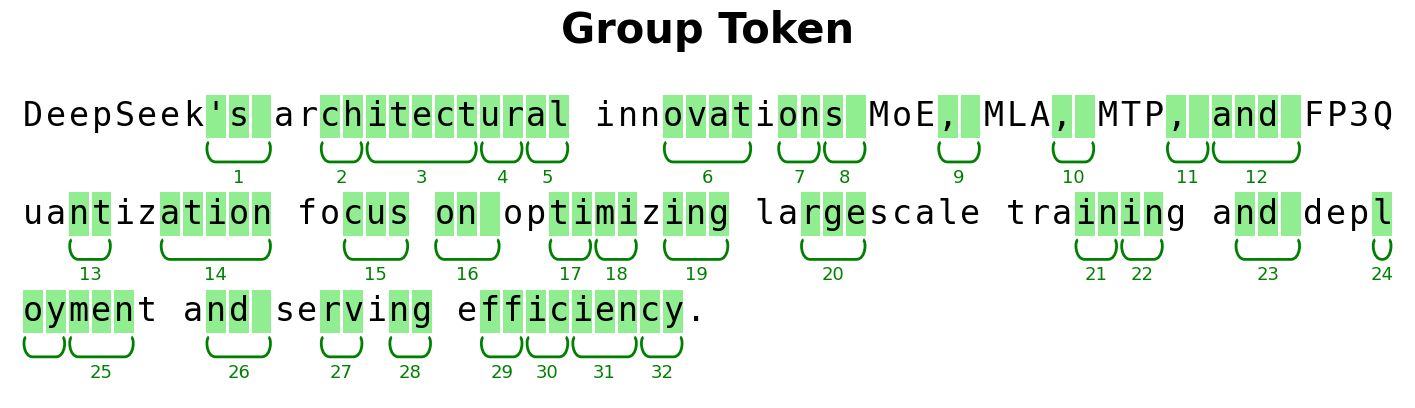

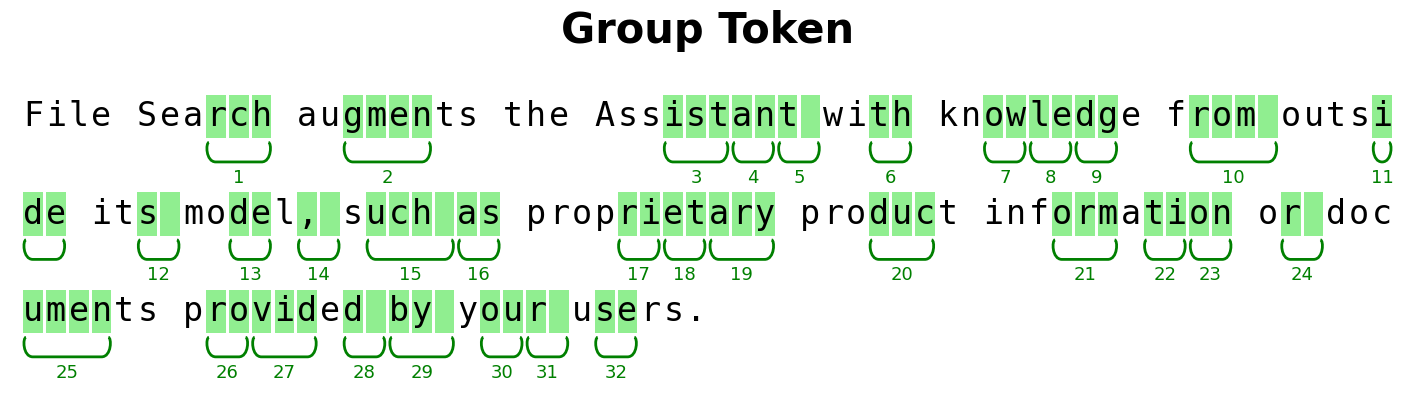

In [3]:
from magicab import Magicab
magicab = Magicab(model, tok, checkpoint_dir="checkpoint/base", spike_perplexity_threshold=5.0, group_perplexity_threshold=0.2)

txt1 = "DeepSeek's architectural innovations MoE, MLA, MTP, and FP3Quantization focus on optimizing largescale training and deployment and serving efficiency."
txt2 = "File Search augments the Assistant with knowledge from outside its model, such as proprietary product information or documents provided by your users."
texts = [txt1, txt2]

# (a). Batch Visualizer
magicab.visualize_changes(texts) # issue: likely empty remove token groups leading to issue in map_to_char functional

In [31]:
from magicab import save_magicab 
save_magicab(checkpoint, magicab, out_dir="checkpoint/test")

num decayed parameter tensors: 26, with 10,848,768 parameters
num non-decayed parameter tensors: 13, with 4,992 parameters
using fused AdamW: False


In [4]:
from data.enwiki.util import prepare_enwiki_data
from magicab import update_magicab
from magicab.magicab import get_batch
import time 

# Update data with tokenizer (11min --> 40s with rust tokenization)
# t0 = time.time()
prepare_enwiki_data(clean=True, tokenizer=magicab.tokenizer) # in-place update on trianing data 
# t1 = time.time()
# print("Time taken to update data: ", t1 - t0)

In [5]:
data_dir = "data/enwiki/"
block_size = 256
batch_size = 256
device_type = "mps" if not torch.cuda.is_available() else "cuda"
max_size_change = 2000

update_magicab(magicab, data_dir, block_size, batch_size, device_type, max_size_change)

Updating Magicab Vocabulary:   0%|          | 0/763 [00:00<?, ?it/s]

 - Inference took: 1.1501 seconds
   :: Remove token mask calculation: 0.1199 seconds
   :: Remove token list appending loop: 0.0522 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1724 seconds


Updating Magicab Vocabulary:   0%|          | 1/763 [00:01<19:09,  1.51s/it]

 - Group token detection took: 0.0522 seconds
   :: add_tokens: 0.0124 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0869 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0021 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0219 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1246 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0002 seconds
Function _cache_vocabulary_change took 1.5011 seconds
 - Inference took: 0.9066 seconds
   :: Remove token mask calculation: 0.0663 seconds
   :: Remove token list appending loop: 0.0516 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1180 seconds


Updating Magicab Vocabulary:   0%|          | 2/763 [00:02<17:31,  1.38s/it]

 - Group token detection took: 0.1225 seconds
   :: add_tokens: 0.0112 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0907 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0211 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1262 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0144 seconds
Function _cache_vocabulary_change took 1.2890 seconds
 - Inference took: 0.9064 seconds
   :: Remove token mask calculation: 0.0612 seconds
   :: Remove token list appending loop: 0.0578 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1190 seconds
 - Group token detection took: 0.0506 seconds


Updating Magicab Vocabulary:   0%|          | 3/763 [00:04<16:43,  1.32s/it]

   :: add_tokens: 0.0147 seconds
   :: add_tokens: per input row  0.0001 seconds
   :: slice_embeddings: 0.1108 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0027 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0271 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1572 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0099 seconds
Function _cache_vocabulary_change took 1.2446 seconds
 - Inference took: 0.9038 seconds
   :: Remove token mask calculation: 0.0808 seconds
   :: Remove token list appending loop: 0.0538 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1346 seconds
 - Group token detection took: 0.0483 seconds


Updating Magicab Vocabulary:   1%|          | 4/763 [00:05<16:13,  1.28s/it]

   :: add_tokens: 0.0113 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0853 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0020 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0207 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1207 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0106 seconds
Function _cache_vocabulary_change took 1.2196 seconds
 - Inference took: 0.9032 seconds
   :: Remove token mask calculation: 0.0733 seconds
   :: Remove token list appending loop: 0.0537 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1271 seconds


Updating Magicab Vocabulary:   1%|          | 5/763 [00:06<16:05,  1.27s/it]

 - Group token detection took: 0.0883 seconds
   :: add_tokens: 0.0114 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0895 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0207 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1249 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0092 seconds
Function _cache_vocabulary_change took 1.2544 seconds
 - Inference took: 0.9011 seconds
   :: Remove token mask calculation: 0.0699 seconds
   :: Remove token list appending loop: 0.0519 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1219 seconds
 - Group token detection took: 0.0488 seconds


Updating Magicab Vocabulary:   1%|          | 6/763 [00:07<15:47,  1.25s/it]

   :: add_tokens: 0.0116 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0869 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0020 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0216 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1235 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0092 seconds
Function _cache_vocabulary_change took 1.2058 seconds
 - Inference took: 0.8999 seconds
   :: Remove token mask calculation: 0.0676 seconds
   :: Remove token list appending loop: 0.0540 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1217 seconds


Updating Magicab Vocabulary:   1%|          | 7/763 [00:08<15:47,  1.25s/it]

 - Group token detection took: 0.0897 seconds
   :: add_tokens: 0.0120 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0939 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0020 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0217 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1311 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0113 seconds
Function _cache_vocabulary_change took 1.2552 seconds
 - Inference took: 0.9040 seconds
   :: Remove token mask calculation: 0.0690 seconds
   :: Remove token list appending loop: 0.0544 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1235 seconds
 - Group token detection took: 0.0477 seconds


Updating Magicab Vocabulary:   1%|          | 8/763 [00:10<15:39,  1.24s/it]

   :: add_tokens: 0.0119 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0962 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0022 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0214 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1332 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0103 seconds
Function _cache_vocabulary_change took 1.2201 seconds
 - Inference took: 0.9178 seconds
   :: Remove token mask calculation: 0.0709 seconds
   :: Remove token list appending loop: 0.0609 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1319 seconds
 - Group token detection took: 0.1404 seconds


Updating Magicab Vocabulary:   1%|          | 9/763 [00:11<16:46,  1.33s/it]

   :: add_tokens: 0.0302 seconds
   :: add_tokens: per input row  0.0001 seconds
   :: slice_embeddings: 0.2240 seconds
   :: slice_embeddings: per input row  0.0009 seconds
   :: update_token_addition: 0.0066 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0509 seconds
   :: update_caches: per input row  0.0002 seconds
 - Vocabulary addition prep took: 0.3171 seconds
 - Token removal prep took: 0.0001 seconds
 - Cache updates took: 0.0204 seconds
Function _cache_vocabulary_change took 1.5294 seconds
 - Inference took: 1.0743 seconds
   :: Remove token mask calculation: 0.0909 seconds
   :: Remove token list appending loop: 0.1062 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1972 seconds


Updating Magicab Vocabulary:   1%|▏         | 10/763 [00:13<17:24,  1.39s/it]

 - Group token detection took: 0.0554 seconds
   :: add_tokens: 0.0138 seconds
   :: add_tokens: per input row  0.0001 seconds
   :: slice_embeddings: 0.1127 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0027 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0249 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1559 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0110 seconds
Function _cache_vocabulary_change took 1.4954 seconds
 - Inference took: 0.9316 seconds
   :: Remove token mask calculation: 0.0593 seconds
   :: Remove token list appending loop: 0.0477 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1071 seconds
 - Group token detection took: 0.0485 seconds


Updating Magicab Vocabulary:   1%|▏         | 11/763 [00:14<16:45,  1.34s/it]

   :: add_tokens: 0.0117 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0869 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0020 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0212 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1234 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0108 seconds
Function _cache_vocabulary_change took 1.2229 seconds
 - Inference took: 0.8985 seconds
   :: Remove token mask calculation: 0.0566 seconds
   :: Remove token list appending loop: 0.0501 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1068 seconds
 - Group token detection took: 0.0878 seconds


Updating Magicab Vocabulary:   2%|▏         | 12/763 [00:15<16:22,  1.31s/it]

   :: add_tokens: 0.0120 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0950 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0021 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0220 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1327 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0099 seconds
Function _cache_vocabulary_change took 1.2372 seconds
 - Inference took: 0.9049 seconds
   :: Remove token mask calculation: 0.0861 seconds
   :: Remove token list appending loop: 0.0538 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1400 seconds
 - Group token detection took: 0.0486 seconds


Updating Magicab Vocabulary:   2%|▏         | 13/763 [00:16<16:04,  1.29s/it]

   :: add_tokens: 0.0113 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0901 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0020 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0203 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1251 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0103 seconds
Function _cache_vocabulary_change took 1.2301 seconds
 - Inference took: 0.9041 seconds
   :: Remove token mask calculation: 0.0785 seconds
   :: Remove token list appending loop: 0.0532 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1317 seconds


Updating Magicab Vocabulary:   2%|▏         | 14/763 [00:18<15:58,  1.28s/it]

 - Group token detection took: 0.0913 seconds
   :: add_tokens: 0.0113 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0905 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0202 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1251 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0101 seconds
Function _cache_vocabulary_change took 1.2639 seconds
 - Inference took: 0.8977 seconds
   :: Remove token mask calculation: 0.0584 seconds
   :: Remove token list appending loop: 0.0537 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1123 seconds
 - Group token detection took: 0.0483 seconds


Updating Magicab Vocabulary:   2%|▏         | 15/763 [00:19<15:43,  1.26s/it]

   :: add_tokens: 0.0139 seconds
   :: add_tokens: per input row  0.0001 seconds
   :: slice_embeddings: 0.0997 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0023 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0220 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1404 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0122 seconds
Function _cache_vocabulary_change took 1.2123 seconds
 - Inference took: 0.9049 seconds
   :: Remove token mask calculation: 0.0614 seconds
   :: Remove token list appending loop: 0.0513 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1128 seconds
 - Group token detection took: 0.0487 seconds


Updating Magicab Vocabulary:   2%|▏         | 16/763 [00:20<15:27,  1.24s/it]

   :: add_tokens: 0.0108 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0847 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0196 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1183 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0090 seconds
Function _cache_vocabulary_change took 1.1950 seconds
 - Inference took: 0.9026 seconds
   :: Remove token mask calculation: 0.0597 seconds
   :: Remove token list appending loop: 0.0515 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1113 seconds
 - Group token detection took: 0.0914 seconds


Updating Magicab Vocabulary:   2%|▏         | 17/763 [00:21<15:29,  1.25s/it]

   :: add_tokens: 0.0119 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0950 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0021 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0220 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1324 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0110 seconds
Function _cache_vocabulary_change took 1.2501 seconds
 - Inference took: 0.9153 seconds
   :: Remove token mask calculation: 0.0581 seconds
   :: Remove token list appending loop: 0.0505 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1087 seconds
 - Group token detection took: 0.0491 seconds


Updating Magicab Vocabulary:   2%|▏         | 18/763 [00:23<15:21,  1.24s/it]

   :: add_tokens: 0.0122 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0893 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0021 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0221 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1272 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0109 seconds
Function _cache_vocabulary_change took 1.2127 seconds
 - Inference took: 0.9070 seconds
   :: Remove token mask calculation: 0.0585 seconds
   :: Remove token list appending loop: 0.0515 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1101 seconds
 - Group token detection took: 0.0888 seconds


Updating Magicab Vocabulary:   2%|▏         | 19/763 [00:24<15:23,  1.24s/it]

   :: add_tokens: 0.0115 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0956 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0021 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0212 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1318 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0094 seconds
Function _cache_vocabulary_change took 1.2486 seconds
 - Inference took: 0.9111 seconds
   :: Remove token mask calculation: 0.0723 seconds
   :: Remove token list appending loop: 0.0535 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1258 seconds
 - Group token detection took: 0.0487 seconds


Updating Magicab Vocabulary:   3%|▎         | 20/763 [00:25<15:19,  1.24s/it]

   :: add_tokens: 0.0117 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0902 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0020 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0211 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1265 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0100 seconds
Function _cache_vocabulary_change took 1.2236 seconds
 - Inference took: 0.9186 seconds
   :: Remove token mask calculation: 0.0585 seconds
   :: Remove token list appending loop: 0.0504 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1090 seconds
 - Group token detection took: 0.0481 seconds


Updating Magicab Vocabulary:   3%|▎         | 21/763 [00:26<15:19,  1.24s/it]

   :: add_tokens: 0.0167 seconds
   :: add_tokens: per input row  0.0001 seconds
   :: slice_embeddings: 0.1091 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0022 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0232 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1556 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0094 seconds
Function _cache_vocabulary_change took 1.2422 seconds
 - Inference took: 0.8985 seconds
   :: Remove token mask calculation: 0.0553 seconds
   :: Remove token list appending loop: 0.0482 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1036 seconds
 - Group token detection took: 0.0899 seconds


Updating Magicab Vocabulary:   3%|▎         | 22/763 [00:28<15:18,  1.24s/it]

   :: add_tokens: 0.0109 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0955 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0203 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1298 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0107 seconds
Function _cache_vocabulary_change took 1.2340 seconds
 - Inference took: 0.9135 seconds
   :: Remove token mask calculation: 0.0539 seconds
   :: Remove token list appending loop: 0.0480 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1019 seconds
 - Group token detection took: 0.0475 seconds


Updating Magicab Vocabulary:   3%|▎         | 23/763 [00:29<15:07,  1.23s/it]

   :: add_tokens: 0.0103 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0837 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0017 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0194 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1163 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0115 seconds
Function _cache_vocabulary_change took 1.1922 seconds
 - Inference took: 0.8935 seconds
   :: Remove token mask calculation: 0.0543 seconds
   :: Remove token list appending loop: 0.0483 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1026 seconds
 - Group token detection took: 0.0883 seconds


Updating Magicab Vocabulary:   3%|▎         | 24/763 [00:30<15:05,  1.22s/it]

   :: add_tokens: 0.0107 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0876 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0207 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1220 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0117 seconds
Function _cache_vocabulary_change took 1.2195 seconds
 - Inference took: 0.8941 seconds
   :: Remove token mask calculation: 0.0530 seconds
   :: Remove token list appending loop: 0.0746 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1277 seconds
 - Group token detection took: 0.0478 seconds


Updating Magicab Vocabulary:   3%|▎         | 25/763 [00:31<14:59,  1.22s/it]

   :: add_tokens: 0.0110 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0852 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0210 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1204 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0111 seconds
Function _cache_vocabulary_change took 1.2025 seconds
 - Inference took: 0.8952 seconds
   :: Remove token mask calculation: 0.0614 seconds
   :: Remove token list appending loop: 0.0559 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1174 seconds
 - Group token detection took: 0.0477 seconds


Updating Magicab Vocabulary:   3%|▎         | 26/763 [00:32<14:52,  1.21s/it]

   :: add_tokens: 0.0100 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0838 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0016 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0194 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1160 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0111 seconds
Function _cache_vocabulary_change took 1.1888 seconds
 - Inference took: 0.9003 seconds
   :: Remove token mask calculation: 0.0564 seconds
   :: Remove token list appending loop: 0.0861 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1425 seconds


Updating Magicab Vocabulary:   4%|▎         | 27/763 [00:34<15:04,  1.23s/it]

 - Group token detection took: 0.0903 seconds
   :: add_tokens: 0.0104 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0917 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0016 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0201 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1250 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0089 seconds
Function _cache_vocabulary_change took 1.2683 seconds
 - Inference took: 0.9038 seconds
   :: Remove token mask calculation: 0.0544 seconds
   :: Remove token list appending loop: 0.0491 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1036 seconds
 - Group token detection took: 0.0467 seconds


Updating Magicab Vocabulary:   4%|▎         | 28/763 [00:35<14:53,  1.22s/it]

   :: add_tokens: 0.0104 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0829 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0199 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1163 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0105 seconds
Function _cache_vocabulary_change took 1.1821 seconds
 - Inference took: 0.8910 seconds
   :: Remove token mask calculation: 0.0542 seconds
   :: Remove token list appending loop: 0.0489 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1031 seconds
 - Group token detection took: 0.0864 seconds


Updating Magicab Vocabulary:   4%|▍         | 29/763 [00:36<14:53,  1.22s/it]

   :: add_tokens: 0.0106 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0908 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0017 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0203 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1246 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0117 seconds
Function _cache_vocabulary_change took 1.2183 seconds
 - Inference took: 0.9054 seconds
   :: Remove token mask calculation: 0.0662 seconds
   :: Remove token list appending loop: 0.0502 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1165 seconds
 - Group token detection took: 0.0473 seconds


Updating Magicab Vocabulary:   4%|▍         | 30/763 [00:37<14:48,  1.21s/it]

   :: add_tokens: 0.0106 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0817 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0204 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1158 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0108 seconds
Function _cache_vocabulary_change took 1.1971 seconds
 - Inference took: 0.8909 seconds
   :: Remove token mask calculation: 0.0539 seconds
   :: Remove token list appending loop: 0.0486 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1026 seconds
 - Group token detection took: 0.0474 seconds


Updating Magicab Vocabulary:   4%|▍         | 31/763 [00:38<14:42,  1.21s/it]

   :: add_tokens: 0.0125 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0921 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0020 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0237 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1315 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0101 seconds
Function _cache_vocabulary_change took 1.1838 seconds
 - Inference took: 0.8916 seconds
   :: Remove token mask calculation: 0.0546 seconds
   :: Remove token list appending loop: 0.0481 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1027 seconds
 - Group token detection took: 0.0858 seconds


Updating Magicab Vocabulary:   4%|▍         | 32/763 [00:40<14:44,  1.21s/it]

   :: add_tokens: 0.0109 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0915 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0208 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1264 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0108 seconds
Function _cache_vocabulary_change took 1.2186 seconds
 - Inference took: 0.9033 seconds
   :: Remove token mask calculation: 0.0549 seconds
   :: Remove token list appending loop: 0.0479 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1028 seconds
 - Group token detection took: 0.0475 seconds


Updating Magicab Vocabulary:   4%|▍         | 33/763 [00:41<14:38,  1.20s/it]

   :: add_tokens: 0.0107 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0876 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0207 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1220 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0098 seconds
Function _cache_vocabulary_change took 1.1867 seconds
 - Inference took: 0.9061 seconds
   :: Remove token mask calculation: 0.0541 seconds
   :: Remove token list appending loop: 0.0479 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1021 seconds
 - Group token detection took: 0.0840 seconds


Updating Magicab Vocabulary:   4%|▍         | 34/763 [00:42<14:43,  1.21s/it]

   :: add_tokens: 0.0105 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0906 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0206 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1247 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0105 seconds
Function _cache_vocabulary_change took 1.2287 seconds
 - Inference took: 0.9133 seconds
   :: Remove token mask calculation: 0.0540 seconds
   :: Remove token list appending loop: 0.0479 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1019 seconds
 - Group token detection took: 0.0469 seconds


Updating Magicab Vocabulary:   5%|▍         | 35/763 [00:43<14:38,  1.21s/it]

   :: add_tokens: 0.0107 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0839 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0206 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1183 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0100 seconds
Function _cache_vocabulary_change took 1.1918 seconds
 - Inference took: 0.8896 seconds
   :: Remove token mask calculation: 0.0545 seconds
   :: Remove token list appending loop: 0.0475 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1020 seconds
 - Group token detection took: 0.0888 seconds


Updating Magicab Vocabulary:   5%|▍         | 36/763 [00:45<14:39,  1.21s/it]

   :: add_tokens: 0.0112 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0868 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0210 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1221 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0098 seconds
Function _cache_vocabulary_change took 1.2137 seconds
 - Inference took: 0.8920 seconds
   :: Remove token mask calculation: 0.0536 seconds
   :: Remove token list appending loop: 0.0483 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1019 seconds
 - Group token detection took: 0.0470 seconds


Updating Magicab Vocabulary:   5%|▍         | 37/763 [00:46<14:30,  1.20s/it]

   :: add_tokens: 0.0110 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0828 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0210 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1179 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0111 seconds
Function _cache_vocabulary_change took 1.1714 seconds
 - Inference took: 0.8890 seconds
   :: Remove token mask calculation: 0.0526 seconds
   :: Remove token list appending loop: 0.0471 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.0997 seconds
 - Group token detection took: 0.0473 seconds


Updating Magicab Vocabulary:   5%|▍         | 38/763 [00:47<14:23,  1.19s/it]

   :: add_tokens: 0.0113 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0854 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0213 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1213 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0094 seconds
Function _cache_vocabulary_change took 1.1681 seconds
 - Inference took: 0.9016 seconds
   :: Remove token mask calculation: 0.0548 seconds
   :: Remove token list appending loop: 0.0485 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1033 seconds
 - Group token detection took: 0.0868 seconds


Updating Magicab Vocabulary:   5%|▌         | 39/763 [00:48<14:34,  1.21s/it]

   :: add_tokens: 0.0112 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.1014 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0020 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0220 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1381 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0107 seconds
Function _cache_vocabulary_change took 1.2419 seconds
 - Inference took: 0.9079 seconds
   :: Remove token mask calculation: 0.0536 seconds
   :: Remove token list appending loop: 0.0495 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1031 seconds
 - Group token detection took: 0.0479 seconds


Updating Magicab Vocabulary:   5%|▌         | 40/763 [00:49<14:35,  1.21s/it]

   :: add_tokens: 0.0132 seconds
   :: add_tokens: per input row  0.0001 seconds
   :: slice_embeddings: 0.0982 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0023 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0262 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1418 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0109 seconds
Function _cache_vocabulary_change took 1.2132 seconds
 - Inference took: 0.8966 seconds
   :: Remove token mask calculation: 0.0546 seconds
   :: Remove token list appending loop: 0.0486 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1033 seconds
 - Group token detection took: 0.0900 seconds


Updating Magicab Vocabulary:   5%|▌         | 41/763 [00:51<14:37,  1.22s/it]

   :: add_tokens: 0.0108 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0877 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0206 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1222 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0106 seconds
Function _cache_vocabulary_change took 1.2241 seconds
 - Inference took: 0.9023 seconds
   :: Remove token mask calculation: 0.0537 seconds
   :: Remove token list appending loop: 0.0479 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1017 seconds
 - Group token detection took: 0.0478 seconds


Updating Magicab Vocabulary:   6%|▌         | 42/763 [00:52<14:30,  1.21s/it]

   :: add_tokens: 0.0107 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0880 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0210 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1227 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0100 seconds
Function _cache_vocabulary_change took 1.1861 seconds
 - Inference took: 0.9035 seconds
   :: Remove token mask calculation: 0.0537 seconds
   :: Remove token list appending loop: 0.0475 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1013 seconds
 - Group token detection took: 0.0469 seconds


Updating Magicab Vocabulary:   6%|▌         | 43/763 [00:53<14:24,  1.20s/it]

   :: add_tokens: 0.0106 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0838 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0210 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1186 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0112 seconds
Function _cache_vocabulary_change took 1.1828 seconds
 - Inference took: 0.8904 seconds
   :: Remove token mask calculation: 0.0555 seconds
   :: Remove token list appending loop: 0.0487 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1042 seconds
 - Group token detection took: 0.0848 seconds


Updating Magicab Vocabulary:   6%|▌         | 44/763 [00:54<14:27,  1.21s/it]

   :: add_tokens: 0.0109 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0902 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0209 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1251 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0105 seconds
Function _cache_vocabulary_change took 1.2166 seconds
 - Inference took: 0.9025 seconds
   :: Remove token mask calculation: 0.0552 seconds
   :: Remove token list appending loop: 0.0474 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1026 seconds
 - Group token detection took: 0.0477 seconds


Updating Magicab Vocabulary:   6%|▌         | 45/763 [00:55<14:23,  1.20s/it]

   :: add_tokens: 0.0110 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0915 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0207 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1265 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0103 seconds
Function _cache_vocabulary_change took 1.1909 seconds
 - Inference took: 0.9080 seconds
   :: Remove token mask calculation: 0.0541 seconds
   :: Remove token list appending loop: 0.0491 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1032 seconds
 - Group token detection took: 0.0874 seconds


Updating Magicab Vocabulary:   6%|▌         | 46/763 [00:57<14:29,  1.21s/it]

   :: add_tokens: 0.0108 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0888 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0205 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1233 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0102 seconds
Function _cache_vocabulary_change took 1.2335 seconds
 - Inference took: 0.9226 seconds
   :: Remove token mask calculation: 0.0540 seconds
   :: Remove token list appending loop: 0.0487 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1028 seconds
 - Group token detection took: 0.0482 seconds


Updating Magicab Vocabulary:   6%|▌         | 47/763 [00:58<14:28,  1.21s/it]

   :: add_tokens: 0.0109 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0875 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0211 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1225 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0103 seconds
Function _cache_vocabulary_change took 1.2078 seconds
 - Inference took: 0.9090 seconds
   :: Remove token mask calculation: 0.0547 seconds
   :: Remove token list appending loop: 0.0482 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1029 seconds
 - Group token detection took: 0.0895 seconds


Updating Magicab Vocabulary:   6%|▋         | 48/763 [00:59<14:33,  1.22s/it]

   :: add_tokens: 0.0110 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0894 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0208 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1243 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0108 seconds
Function _cache_vocabulary_change took 1.2381 seconds
 - Inference took: 0.8965 seconds
   :: Remove token mask calculation: 0.0531 seconds
   :: Remove token list appending loop: 0.0475 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1007 seconds
 - Group token detection took: 0.0474 seconds


Updating Magicab Vocabulary:   6%|▋         | 49/763 [01:00<14:23,  1.21s/it]

   :: add_tokens: 0.0111 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0881 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0214 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1237 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0105 seconds
Function _cache_vocabulary_change took 1.1803 seconds
 - Inference took: 0.9076 seconds
   :: Remove token mask calculation: 0.0539 seconds
   :: Remove token list appending loop: 0.0490 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1030 seconds
 - Group token detection took: 0.0468 seconds


Updating Magicab Vocabulary:   7%|▋         | 50/763 [01:01<14:17,  1.20s/it]

   :: add_tokens: 0.0108 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0820 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0203 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1162 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0091 seconds
Function _cache_vocabulary_change took 1.1843 seconds
 - Inference took: 0.8968 seconds
   :: Remove token mask calculation: 0.0543 seconds
   :: Remove token list appending loop: 0.0483 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1027 seconds
 - Group token detection took: 0.0879 seconds


Updating Magicab Vocabulary:   7%|▋         | 51/763 [01:03<14:20,  1.21s/it]

   :: add_tokens: 0.0102 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0856 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0195 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1183 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0104 seconds
Function _cache_vocabulary_change took 1.2176 seconds
 - Inference took: 0.8929 seconds
   :: Remove token mask calculation: 0.0541 seconds
   :: Remove token list appending loop: 0.0480 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1021 seconds
 - Group token detection took: 0.0469 seconds


Updating Magicab Vocabulary:   7%|▋         | 52/763 [01:04<14:11,  1.20s/it]

   :: add_tokens: 0.0104 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0821 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0017 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0196 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1149 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0097 seconds
Function _cache_vocabulary_change took 1.1680 seconds
 - Inference took: 0.8938 seconds
   :: Remove token mask calculation: 0.0542 seconds
   :: Remove token list appending loop: 0.0487 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1029 seconds
 - Group token detection took: 0.0918 seconds


Updating Magicab Vocabulary:   7%|▋         | 53/763 [01:05<14:16,  1.21s/it]

   :: add_tokens: 0.0107 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0874 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0017 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0206 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1218 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0121 seconds
Function _cache_vocabulary_change took 1.2239 seconds
 - Inference took: 0.9008 seconds
   :: Remove token mask calculation: 0.0543 seconds
   :: Remove token list appending loop: 0.0485 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1028 seconds
 - Group token detection took: 0.0474 seconds


Updating Magicab Vocabulary:   7%|▋         | 54/763 [01:06<14:16,  1.21s/it]

   :: add_tokens: 0.0175 seconds
   :: add_tokens: per input row  0.0001 seconds
   :: slice_embeddings: 0.1022 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0024 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0229 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1466 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0097 seconds
Function _cache_vocabulary_change took 1.2089 seconds
 - Inference took: 0.8984 seconds
   :: Remove token mask calculation: 0.0556 seconds
   :: Remove token list appending loop: 0.0494 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1050 seconds
 - Group token detection took: 0.0471 seconds


Updating Magicab Vocabulary:   7%|▋         | 55/763 [01:07<14:10,  1.20s/it]

   :: add_tokens: 0.0106 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0829 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0204 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1169 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0101 seconds
Function _cache_vocabulary_change took 1.1789 seconds
 - Inference took: 0.8947 seconds
   :: Remove token mask calculation: 0.0538 seconds
   :: Remove token list appending loop: 0.0480 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1019 seconds
 - Group token detection took: 0.0875 seconds


Updating Magicab Vocabulary:   7%|▋         | 56/763 [01:09<14:13,  1.21s/it]

   :: add_tokens: 0.0104 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0895 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0197 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1227 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0110 seconds
Function _cache_vocabulary_change took 1.2192 seconds
 - Inference took: 0.9031 seconds
   :: Remove token mask calculation: 0.0542 seconds
   :: Remove token list appending loop: 0.0495 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1038 seconds
 - Group token detection took: 0.0475 seconds


Updating Magicab Vocabulary:   7%|▋         | 57/763 [01:10<14:09,  1.20s/it]

   :: add_tokens: 0.0110 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0879 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0207 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1228 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0106 seconds
Function _cache_vocabulary_change took 1.1892 seconds
 - Inference took: 0.9037 seconds
   :: Remove token mask calculation: 0.0544 seconds
   :: Remove token list appending loop: 0.0474 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1019 seconds
 - Group token detection took: 0.0876 seconds


Updating Magicab Vocabulary:   8%|▊         | 58/763 [01:11<14:13,  1.21s/it]

   :: add_tokens: 0.0104 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0889 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0017 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0197 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1220 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0092 seconds
Function _cache_vocabulary_change took 1.2261 seconds
 - Inference took: 0.9071 seconds
   :: Remove token mask calculation: 0.0510 seconds
   :: Remove token list appending loop: 0.0482 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.0993 seconds
 - Group token detection took: 0.0480 seconds


Updating Magicab Vocabulary:   8%|▊         | 59/763 [01:12<14:12,  1.21s/it]

   :: add_tokens: 0.0131 seconds
   :: add_tokens: per input row  0.0001 seconds
   :: slice_embeddings: 0.0986 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0020 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0252 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1405 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0112 seconds
Function _cache_vocabulary_change took 1.2074 seconds
 - Inference took: 0.8967 seconds
   :: Remove token mask calculation: 0.0537 seconds
   :: Remove token list appending loop: 0.0494 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1031 seconds
 - Group token detection took: 0.0470 seconds


Updating Magicab Vocabulary:   8%|▊         | 60/763 [01:13<14:05,  1.20s/it]

   :: add_tokens: 0.0112 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0879 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0216 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1240 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0102 seconds
Function _cache_vocabulary_change took 1.1824 seconds
 - Inference took: 0.9058 seconds
   :: Remove token mask calculation: 0.0534 seconds
   :: Remove token list appending loop: 0.0481 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1016 seconds
 - Group token detection took: 0.0860 seconds


Updating Magicab Vocabulary:   8%|▊         | 61/763 [01:15<14:10,  1.21s/it]

   :: add_tokens: 0.0110 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0891 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0017 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0218 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1248 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0098 seconds
Function _cache_vocabulary_change took 1.2295 seconds
 - Inference took: 0.9060 seconds
   :: Remove token mask calculation: 0.0546 seconds
   :: Remove token list appending loop: 0.0497 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1043 seconds
 - Group token detection took: 0.0472 seconds


Updating Magicab Vocabulary:   8%|▊         | 62/763 [01:16<14:05,  1.21s/it]

   :: add_tokens: 0.0107 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0838 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0212 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1187 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0105 seconds
Function _cache_vocabulary_change took 1.1882 seconds
 - Inference took: 0.8958 seconds
   :: Remove token mask calculation: 0.0541 seconds
   :: Remove token list appending loop: 0.0494 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1035 seconds
 - Group token detection took: 0.0886 seconds


Updating Magicab Vocabulary:   8%|▊         | 63/763 [01:17<14:08,  1.21s/it]

   :: add_tokens: 0.0105 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0881 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0203 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1219 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0109 seconds
Function _cache_vocabulary_change took 1.2224 seconds
 - Inference took: 0.9097 seconds
   :: Remove token mask calculation: 0.0555 seconds
   :: Remove token list appending loop: 0.0493 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1048 seconds
 - Group token detection took: 0.0465 seconds


Updating Magicab Vocabulary:   8%|▊         | 64/763 [01:18<14:02,  1.21s/it]

   :: add_tokens: 0.0105 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0822 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0201 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1158 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0091 seconds
Function _cache_vocabulary_change took 1.1872 seconds
 - Inference took: 0.8976 seconds
   :: Remove token mask calculation: 0.0547 seconds
   :: Remove token list appending loop: 0.0487 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1034 seconds
 - Group token detection took: 0.0470 seconds


Updating Magicab Vocabulary:   9%|▊         | 65/763 [01:19<14:00,  1.20s/it]

   :: add_tokens: 0.0139 seconds
   :: add_tokens: per input row  0.0001 seconds
   :: slice_embeddings: 0.0974 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0022 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0237 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1387 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0095 seconds
Function _cache_vocabulary_change took 1.1976 seconds
 - Inference took: 0.8936 seconds
   :: Remove token mask calculation: 0.0544 seconds
   :: Remove token list appending loop: 0.0497 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1041 seconds
 - Group token detection took: 0.0854 seconds


Updating Magicab Vocabulary:   9%|▊         | 66/763 [01:21<14:03,  1.21s/it]

   :: add_tokens: 0.0107 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0900 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0208 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1247 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0099 seconds
Function _cache_vocabulary_change took 1.2192 seconds
 - Inference took: 0.9024 seconds
   :: Remove token mask calculation: 0.0570 seconds
   :: Remove token list appending loop: 0.0480 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1050 seconds
 - Group token detection took: 0.0477 seconds


Updating Magicab Vocabulary:   9%|▉         | 67/763 [01:22<13:58,  1.21s/it]

   :: add_tokens: 0.0110 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0887 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0211 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1240 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0102 seconds
Function _cache_vocabulary_change took 1.1907 seconds
 - Inference took: 0.9069 seconds
   :: Remove token mask calculation: 0.0552 seconds
   :: Remove token list appending loop: 0.0501 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1054 seconds
 - Group token detection took: 0.0861 seconds


Updating Magicab Vocabulary:   9%|▉         | 68/763 [01:23<14:03,  1.21s/it]

   :: add_tokens: 0.0104 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0880 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0197 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1210 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0100 seconds
Function _cache_vocabulary_change took 1.2309 seconds
 - Inference took: 0.9040 seconds
   :: Remove token mask calculation: 0.0558 seconds
   :: Remove token list appending loop: 0.0494 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1053 seconds
 - Group token detection took: 0.0467 seconds


Updating Magicab Vocabulary:   9%|▉         | 69/763 [01:24<13:57,  1.21s/it]

   :: add_tokens: 0.0103 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0835 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0017 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0199 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1167 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0099 seconds
Function _cache_vocabulary_change took 1.1839 seconds
 - Inference took: 0.8931 seconds
   :: Remove token mask calculation: 0.0537 seconds
   :: Remove token list appending loop: 0.0489 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1026 seconds
 - Group token detection took: 0.0470 seconds


Updating Magicab Vocabulary:   9%|▉         | 70/763 [01:26<13:51,  1.20s/it]

   :: add_tokens: 0.0108 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0902 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0207 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1249 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0112 seconds
Function _cache_vocabulary_change took 1.1803 seconds
 - Inference took: 0.9277 seconds
   :: Remove token mask calculation: 0.0645 seconds
   :: Remove token list appending loop: 0.0498 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1144 seconds
 - Group token detection took: 0.0841 seconds


Updating Magicab Vocabulary:   9%|▉         | 71/763 [01:27<14:03,  1.22s/it]

   :: add_tokens: 0.0104 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0886 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0017 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0195 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1214 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0101 seconds
Function _cache_vocabulary_change took 1.2592 seconds
 - Inference took: 0.9071 seconds
   :: Remove token mask calculation: 0.0535 seconds
   :: Remove token list appending loop: 0.0484 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1020 seconds
 - Group token detection took: 0.0472 seconds


Updating Magicab Vocabulary:   9%|▉         | 72/763 [01:28<13:56,  1.21s/it]

   :: add_tokens: 0.0107 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0832 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0208 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1177 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0110 seconds
Function _cache_vocabulary_change took 1.1865 seconds
 - Inference took: 0.8974 seconds
   :: Remove token mask calculation: 0.0551 seconds
   :: Remove token list appending loop: 0.0483 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1035 seconds
 - Group token detection took: 0.0866 seconds


Updating Magicab Vocabulary:  10%|▉         | 73/763 [01:29<13:58,  1.22s/it]

   :: add_tokens: 0.0109 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0896 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0211 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1248 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0102 seconds
Function _cache_vocabulary_change took 1.2239 seconds
 - Inference took: 0.9049 seconds
   :: Remove token mask calculation: 0.0557 seconds
   :: Remove token list appending loop: 0.0488 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1045 seconds
 - Group token detection took: 0.0471 seconds


Updating Magicab Vocabulary:  10%|▉         | 74/763 [01:30<13:53,  1.21s/it]

   :: add_tokens: 0.0109 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0882 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0211 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1231 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0113 seconds
Function _cache_vocabulary_change took 1.1924 seconds
 - Inference took: 0.9031 seconds
   :: Remove token mask calculation: 0.0553 seconds
   :: Remove token list appending loop: 0.0515 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1069 seconds
 - Group token detection took: 0.0864 seconds


Updating Magicab Vocabulary:  10%|▉         | 75/763 [01:32<14:01,  1.22s/it]

   :: add_tokens: 0.0134 seconds
   :: add_tokens: per input row  0.0001 seconds
   :: slice_embeddings: 0.1008 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0022 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0243 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1422 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0110 seconds
Function _cache_vocabulary_change took 1.2512 seconds
 - Inference took: 0.9102 seconds
   :: Remove token mask calculation: 0.0554 seconds
   :: Remove token list appending loop: 0.0493 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1048 seconds
 - Group token detection took: 0.0471 seconds


Updating Magicab Vocabulary:  10%|▉         | 76/763 [01:33<13:54,  1.21s/it]

   :: add_tokens: 0.0107 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0837 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0207 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1182 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0096 seconds
Function _cache_vocabulary_change took 1.1912 seconds
 - Inference took: 0.8931 seconds
   :: Remove token mask calculation: 0.0559 seconds
   :: Remove token list appending loop: 0.0490 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1049 seconds
 - Group token detection took: 0.0466 seconds


Updating Magicab Vocabulary:  10%|█         | 77/763 [01:34<13:45,  1.20s/it]

   :: add_tokens: 0.0105 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0830 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0017 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0200 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1165 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0107 seconds
Function _cache_vocabulary_change took 1.1732 seconds
 - Inference took: 0.8947 seconds
   :: Remove token mask calculation: 0.0545 seconds
   :: Remove token list appending loop: 0.0491 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1036 seconds
 - Group token detection took: 0.0860 seconds


Updating Magicab Vocabulary:  10%|█         | 78/763 [01:35<13:48,  1.21s/it]

   :: add_tokens: 0.0108 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0896 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0205 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1239 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0107 seconds
Function _cache_vocabulary_change took 1.2204 seconds
 - Inference took: 0.9059 seconds
   :: Remove token mask calculation: 0.0558 seconds
   :: Remove token list appending loop: 0.0486 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1044 seconds
 - Group token detection took: 0.0471 seconds


Updating Magicab Vocabulary:  10%|█         | 79/763 [01:36<13:43,  1.20s/it]

   :: add_tokens: 0.0109 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0872 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0204 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1215 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0094 seconds
Function _cache_vocabulary_change took 1.1897 seconds
 - Inference took: 0.9056 seconds
   :: Remove token mask calculation: 0.0640 seconds
   :: Remove token list appending loop: 0.0495 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1135 seconds
 - Group token detection took: 0.0862 seconds


Updating Magicab Vocabulary:  10%|█         | 80/763 [01:38<13:50,  1.22s/it]

   :: add_tokens: 0.0107 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0892 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0203 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1233 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0110 seconds
Function _cache_vocabulary_change took 1.2411 seconds
 - Inference took: 0.9053 seconds
   :: Remove token mask calculation: 0.0546 seconds
   :: Remove token list appending loop: 0.0503 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1050 seconds
 - Group token detection took: 0.0485 seconds


Updating Magicab Vocabulary:  11%|█         | 81/763 [01:39<13:45,  1.21s/it]

   :: add_tokens: 0.0114 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0875 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0215 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1237 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0101 seconds
Function _cache_vocabulary_change took 1.1941 seconds
 - Inference took: 0.8948 seconds
   :: Remove token mask calculation: 0.0550 seconds
   :: Remove token list appending loop: 0.0489 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1039 seconds
 - Group token detection took: 0.0469 seconds


Updating Magicab Vocabulary:  11%|█         | 82/763 [01:40<13:38,  1.20s/it]

   :: add_tokens: 0.0111 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0838 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0208 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1188 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0101 seconds
Function _cache_vocabulary_change took 1.1760 seconds
 - Inference took: 0.8946 seconds
   :: Remove token mask calculation: 0.0564 seconds
   :: Remove token list appending loop: 0.0528 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1092 seconds
 - Group token detection took: 0.0866 seconds


Updating Magicab Vocabulary:  11%|█         | 83/763 [01:41<13:43,  1.21s/it]

   :: add_tokens: 0.0109 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0921 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0204 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1266 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0126 seconds
Function _cache_vocabulary_change took 1.2312 seconds
 - Inference took: 0.9067 seconds
   :: Remove token mask calculation: 0.0558 seconds
   :: Remove token list appending loop: 0.0490 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1048 seconds
 - Group token detection took: 0.0473 seconds


Updating Magicab Vocabulary:  11%|█         | 84/763 [01:42<13:39,  1.21s/it]

   :: add_tokens: 0.0111 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0846 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0213 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1202 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0110 seconds
Function _cache_vocabulary_change took 1.1914 seconds
 - Inference took: 0.8918 seconds
   :: Remove token mask calculation: 0.0566 seconds
   :: Remove token list appending loop: 0.0495 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1062 seconds
 - Group token detection took: 0.0884 seconds


Updating Magicab Vocabulary:  11%|█         | 85/763 [01:44<13:42,  1.21s/it]

   :: add_tokens: 0.0109 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0889 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0208 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1237 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0117 seconds
Function _cache_vocabulary_change took 1.2235 seconds
 - Inference took: 0.9138 seconds
   :: Remove token mask calculation: 0.0549 seconds
   :: Remove token list appending loop: 0.0489 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1039 seconds
 - Group token detection took: 0.0471 seconds


Updating Magicab Vocabulary:  11%|█▏        | 86/763 [01:45<13:38,  1.21s/it]

   :: add_tokens: 0.0105 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0871 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0199 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1205 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0093 seconds
Function _cache_vocabulary_change took 1.1959 seconds
 - Inference took: 0.9100 seconds
   :: Remove token mask calculation: 0.0544 seconds
   :: Remove token list appending loop: 0.0496 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1040 seconds
 - Group token detection took: 0.0471 seconds


Updating Magicab Vocabulary:  11%|█▏        | 87/763 [01:46<13:37,  1.21s/it]

   :: add_tokens: 0.0129 seconds
   :: add_tokens: per input row  0.0001 seconds
   :: slice_embeddings: 0.0955 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0023 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0235 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1358 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0103 seconds
Function _cache_vocabulary_change took 1.2086 seconds
 - Inference took: 0.8943 seconds
   :: Remove token mask calculation: 0.0561 seconds
   :: Remove token list appending loop: 0.0484 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1046 seconds
 - Group token detection took: 0.0850 seconds


Updating Magicab Vocabulary:  12%|█▏        | 88/763 [01:47<13:39,  1.21s/it]

   :: add_tokens: 0.0106 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0887 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0204 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1228 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0106 seconds
Function _cache_vocabulary_change took 1.2186 seconds
 - Inference took: 0.8998 seconds
   :: Remove token mask calculation: 0.0553 seconds
   :: Remove token list appending loop: 0.0503 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1057 seconds
 - Group token detection took: 0.0475 seconds


Updating Magicab Vocabulary:  12%|█▏        | 89/763 [01:49<13:33,  1.21s/it]

   :: add_tokens: 0.0107 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0877 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0202 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1216 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0104 seconds
Function _cache_vocabulary_change took 1.1864 seconds
 - Inference took: 0.9015 seconds
   :: Remove token mask calculation: 0.0553 seconds
   :: Remove token list appending loop: 0.0493 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1047 seconds
 - Group token detection took: 0.0851 seconds


Updating Magicab Vocabulary:  12%|█▏        | 90/763 [01:50<13:36,  1.21s/it]

   :: add_tokens: 0.0106 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0882 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0204 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1223 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0099 seconds
Function _cache_vocabulary_change took 1.2250 seconds
 - Inference took: 0.9029 seconds
   :: Remove token mask calculation: 0.0549 seconds
   :: Remove token list appending loop: 0.0489 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1038 seconds
 - Group token detection took: 0.0472 seconds


Updating Magicab Vocabulary:  12%|█▏        | 91/763 [01:51<13:29,  1.21s/it]

   :: add_tokens: 0.0105 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0816 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0017 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0196 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1146 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0123 seconds
Function _cache_vocabulary_change took 1.1823 seconds
 - Inference took: 0.8909 seconds
   :: Remove token mask calculation: 0.0547 seconds
   :: Remove token list appending loop: 0.0491 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1039 seconds
 - Group token detection took: 0.0887 seconds


Updating Magicab Vocabulary:  12%|█▏        | 92/763 [01:52<13:31,  1.21s/it]

   :: add_tokens: 0.0107 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0874 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0209 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1221 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0106 seconds
Function _cache_vocabulary_change took 1.2177 seconds
 - Inference took: 0.8920 seconds
   :: Remove token mask calculation: 0.0554 seconds
   :: Remove token list appending loop: 0.0506 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1061 seconds
 - Group token detection took: 0.0470 seconds


Updating Magicab Vocabulary:  12%|█▏        | 93/763 [01:53<13:29,  1.21s/it]

   :: add_tokens: 0.0154 seconds
   :: add_tokens: per input row  0.0001 seconds
   :: slice_embeddings: 0.0930 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0026 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0252 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1393 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0115 seconds
Function _cache_vocabulary_change took 1.1973 seconds
 - Inference took: 0.8916 seconds
   :: Remove token mask calculation: 0.0555 seconds
   :: Remove token list appending loop: 0.0487 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1043 seconds
 - Group token detection took: 0.0467 seconds


Updating Magicab Vocabulary:  12%|█▏        | 94/763 [01:55<13:22,  1.20s/it]

   :: add_tokens: 0.0104 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0876 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0017 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0206 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1215 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0112 seconds
Function _cache_vocabulary_change took 1.1767 seconds
 - Inference took: 0.9037 seconds
   :: Remove token mask calculation: 0.0555 seconds
   :: Remove token list appending loop: 0.0495 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1051 seconds
 - Group token detection took: 0.0899 seconds


Updating Magicab Vocabulary:  12%|█▏        | 95/763 [01:56<13:28,  1.21s/it]

   :: add_tokens: 0.0110 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0861 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0210 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1211 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0105 seconds
Function _cache_vocabulary_change took 1.2319 seconds
 - Inference took: 0.9023 seconds
   :: Remove token mask calculation: 0.0617 seconds
   :: Remove token list appending loop: 0.0497 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1114 seconds
 - Group token detection took: 0.0478 seconds


Updating Magicab Vocabulary:  13%|█▎        | 96/763 [01:57<13:23,  1.21s/it]

   :: add_tokens: 0.0109 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0810 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0211 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1162 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0098 seconds
Function _cache_vocabulary_change took 1.1889 seconds
 - Inference took: 0.8942 seconds
   :: Remove token mask calculation: 0.0548 seconds
   :: Remove token list appending loop: 0.0496 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1044 seconds
 - Group token detection took: 0.0877 seconds


Updating Magicab Vocabulary:  13%|█▎        | 97/763 [01:58<13:26,  1.21s/it]

   :: add_tokens: 0.0109 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0884 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0209 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1232 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0107 seconds
Function _cache_vocabulary_change took 1.2217 seconds
 - Inference took: 0.9064 seconds
   :: Remove token mask calculation: 0.0562 seconds
   :: Remove token list appending loop: 0.0486 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1048 seconds
 - Group token detection took: 0.0471 seconds


Updating Magicab Vocabulary:  13%|█▎        | 98/763 [01:59<13:20,  1.20s/it]

   :: add_tokens: 0.0106 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0818 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0017 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0199 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1152 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0095 seconds
Function _cache_vocabulary_change took 1.1844 seconds
 - Inference took: 0.8920 seconds
   :: Remove token mask calculation: 0.0558 seconds
   :: Remove token list appending loop: 0.0499 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1058 seconds
 - Group token detection took: 0.0458 seconds


Updating Magicab Vocabulary:  13%|█▎        | 99/763 [02:01<13:13,  1.19s/it]

   :: add_tokens: 0.0101 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0822 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0017 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0194 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1146 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0092 seconds
Function _cache_vocabulary_change took 1.1687 seconds
 - Inference took: 0.8878 seconds
   :: Remove token mask calculation: 0.0554 seconds
   :: Remove token list appending loop: 0.0503 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1057 seconds
 - Group token detection took: 0.0863 seconds


Updating Magicab Vocabulary:  13%|█▎        | 100/763 [02:02<13:16,  1.20s/it]

   :: add_tokens: 0.0105 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0884 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0017 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0204 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1223 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0116 seconds
Function _cache_vocabulary_change took 1.2152 seconds
 - Inference took: 0.9033 seconds
   :: Remove token mask calculation: 0.0555 seconds
   :: Remove token list appending loop: 0.0483 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1039 seconds
 - Group token detection took: 0.0479 seconds


Updating Magicab Vocabulary:  13%|█▎        | 101/763 [02:03<13:13,  1.20s/it]

   :: add_tokens: 0.0106 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0875 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0198 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1209 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0109 seconds
Function _cache_vocabulary_change took 1.1882 seconds
 - Inference took: 0.9063 seconds
   :: Remove token mask calculation: 0.0544 seconds
   :: Remove token list appending loop: 0.0482 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1027 seconds
 - Group token detection took: 0.0877 seconds


Updating Magicab Vocabulary:  13%|█▎        | 102/763 [02:04<13:19,  1.21s/it]

   :: add_tokens: 0.0105 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0891 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0017 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0203 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1229 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0113 seconds
Function _cache_vocabulary_change took 1.2324 seconds
 - Inference took: 0.9034 seconds
   :: Remove token mask calculation: 0.0560 seconds
   :: Remove token list appending loop: 0.0487 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1048 seconds
 - Group token detection took: 0.0477 seconds


Updating Magicab Vocabulary:  13%|█▎        | 103/763 [02:05<13:14,  1.20s/it]

   :: add_tokens: 0.0112 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0831 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0216 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1190 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0106 seconds
Function _cache_vocabulary_change took 1.1870 seconds
 - Inference took: 0.8970 seconds
   :: Remove token mask calculation: 0.0551 seconds
   :: Remove token list appending loop: 0.0528 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1080 seconds
 - Group token detection took: 0.0485 seconds


Updating Magicab Vocabulary:  14%|█▎        | 104/763 [02:07<13:10,  1.20s/it]

   :: add_tokens: 0.0111 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0822 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0213 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1178 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0109 seconds
Function _cache_vocabulary_change took 1.1837 seconds
 - Inference took: 0.8984 seconds
   :: Remove token mask calculation: 0.0551 seconds
   :: Remove token list appending loop: 0.0498 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1050 seconds
 - Group token detection took: 0.0920 seconds


Updating Magicab Vocabulary:  14%|█▍        | 105/763 [02:08<13:15,  1.21s/it]

   :: add_tokens: 0.0108 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0873 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0210 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1221 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0114 seconds
Function _cache_vocabulary_change took 1.2305 seconds
 - Inference took: 0.8977 seconds
   :: Remove token mask calculation: 0.0557 seconds
   :: Remove token list appending loop: 0.0492 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1049 seconds
 - Group token detection took: 0.0468 seconds


Updating Magicab Vocabulary:  14%|█▍        | 106/763 [02:09<13:09,  1.20s/it]

   :: add_tokens: 0.0104 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0868 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0017 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0199 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1200 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0103 seconds
Function _cache_vocabulary_change took 1.1812 seconds
 - Inference took: 0.9012 seconds
   :: Remove token mask calculation: 0.0555 seconds
   :: Remove token list appending loop: 0.0499 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1054 seconds
 - Group token detection took: 0.0874 seconds


Updating Magicab Vocabulary:  14%|█▍        | 107/763 [02:10<13:14,  1.21s/it]

   :: add_tokens: 0.0104 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0888 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0208 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1230 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0113 seconds
Function _cache_vocabulary_change took 1.2298 seconds
 - Inference took: 0.9037 seconds
   :: Remove token mask calculation: 0.0558 seconds
   :: Remove token list appending loop: 0.0497 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1056 seconds
 - Group token detection took: 0.0484 seconds


Updating Magicab Vocabulary:  14%|█▍        | 108/763 [02:11<13:09,  1.21s/it]

   :: add_tokens: 0.0110 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0849 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0213 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1203 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0103 seconds
Function _cache_vocabulary_change took 1.1897 seconds
 - Inference took: 0.8919 seconds
   :: Remove token mask calculation: 0.0556 seconds
   :: Remove token list appending loop: 0.0498 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1054 seconds
 - Group token detection took: 0.0478 seconds


Updating Magicab Vocabulary:  14%|█▍        | 109/763 [02:13<13:04,  1.20s/it]

   :: add_tokens: 0.0107 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0879 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0017 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0204 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1219 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0110 seconds
Function _cache_vocabulary_change took 1.1794 seconds
 - Inference took: 0.9010 seconds
   :: Remove token mask calculation: 0.0555 seconds
   :: Remove token list appending loop: 0.0496 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1051 seconds
 - Group token detection took: 0.0874 seconds


Updating Magicab Vocabulary:  14%|█▍        | 110/763 [02:14<13:09,  1.21s/it]

   :: add_tokens: 0.0107 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0884 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0205 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1226 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0103 seconds
Function _cache_vocabulary_change took 1.2279 seconds
 - Inference took: 0.9049 seconds
   :: Remove token mask calculation: 0.0557 seconds
   :: Remove token list appending loop: 0.0486 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1044 seconds
 - Group token detection took: 0.0463 seconds


Updating Magicab Vocabulary:  15%|█▍        | 111/763 [02:15<13:04,  1.20s/it]

   :: add_tokens: 0.0103 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0881 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0199 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1214 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0102 seconds
Function _cache_vocabulary_change took 1.1886 seconds
 - Inference took: 0.9035 seconds
   :: Remove token mask calculation: 0.0557 seconds
   :: Remove token list appending loop: 0.0491 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1048 seconds
 - Group token detection took: 0.0857 seconds


Updating Magicab Vocabulary:  15%|█▍        | 112/763 [02:16<13:09,  1.21s/it]

   :: add_tokens: 0.0107 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0881 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0207 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1226 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0106 seconds
Function _cache_vocabulary_change took 1.2289 seconds
 - Inference took: 0.9061 seconds
   :: Remove token mask calculation: 0.0554 seconds
   :: Remove token list appending loop: 0.0484 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1039 seconds
 - Group token detection took: 0.0468 seconds


Updating Magicab Vocabulary:  15%|█▍        | 113/763 [02:17<13:04,  1.21s/it]

   :: add_tokens: 0.0106 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0879 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0017 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0200 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1215 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0109 seconds
Function _cache_vocabulary_change took 1.1905 seconds
 - Inference took: 0.9280 seconds
   :: Remove token mask calculation: 0.0558 seconds
   :: Remove token list appending loop: 0.0494 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1052 seconds
 - Group token detection took: 0.0470 seconds


Updating Magicab Vocabulary:  15%|█▍        | 114/763 [02:19<13:04,  1.21s/it]

   :: add_tokens: 0.0108 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0816 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0205 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1158 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0104 seconds
Function _cache_vocabulary_change took 1.2079 seconds
 - Inference took: 0.8962 seconds
   :: Remove token mask calculation: 0.0548 seconds
   :: Remove token list appending loop: 0.0497 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1046 seconds
 - Group token detection took: 0.0880 seconds


Updating Magicab Vocabulary:  15%|█▌        | 115/763 [02:20<13:07,  1.22s/it]

   :: add_tokens: 0.0108 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0929 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0203 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1271 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0116 seconds
Function _cache_vocabulary_change took 1.2290 seconds
 - Inference took: 0.9139 seconds
   :: Remove token mask calculation: 0.0563 seconds
   :: Remove token list appending loop: 0.0498 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1062 seconds
 - Group token detection took: 0.0485 seconds


Updating Magicab Vocabulary:  15%|█▌        | 116/763 [02:21<13:03,  1.21s/it]

   :: add_tokens: 0.0107 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0874 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0200 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1211 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0086 seconds
Function _cache_vocabulary_change took 1.1997 seconds
 - Inference took: 0.9040 seconds
   :: Remove token mask calculation: 0.0549 seconds
   :: Remove token list appending loop: 0.0503 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1052 seconds
 - Group token detection took: 0.0880 seconds


Updating Magicab Vocabulary:  15%|█▌        | 117/763 [02:22<13:07,  1.22s/it]

   :: add_tokens: 0.0104 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0924 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0194 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1251 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0103 seconds
Function _cache_vocabulary_change took 1.2342 seconds
 - Inference took: 0.9025 seconds
   :: Remove token mask calculation: 0.0548 seconds
   :: Remove token list appending loop: 0.0500 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1049 seconds
 - Group token detection took: 0.0477 seconds


Updating Magicab Vocabulary:  15%|█▌        | 118/763 [02:24<13:00,  1.21s/it]

   :: add_tokens: 0.0107 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0877 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0201 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1216 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0095 seconds
Function _cache_vocabulary_change took 1.1875 seconds
 - Inference took: 0.9048 seconds
   :: Remove token mask calculation: 0.0545 seconds
   :: Remove token list appending loop: 0.0494 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1039 seconds
 - Group token detection took: 0.0878 seconds


Updating Magicab Vocabulary:  16%|█▌        | 119/763 [02:25<13:04,  1.22s/it]

   :: add_tokens: 0.0107 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0895 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0203 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1236 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0093 seconds
Function _cache_vocabulary_change took 1.2310 seconds
 - Inference took: 0.9319 seconds
   :: Remove token mask calculation: 0.0547 seconds
   :: Remove token list appending loop: 0.0491 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1039 seconds
 - Group token detection took: 0.0477 seconds


Updating Magicab Vocabulary:  16%|█▌        | 120/763 [02:26<13:02,  1.22s/it]

   :: add_tokens: 0.0109 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0818 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0211 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1169 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0108 seconds
Function _cache_vocabulary_change took 1.2126 seconds
 - Inference took: 0.8904 seconds
   :: Remove token mask calculation: 0.0558 seconds
   :: Remove token list appending loop: 0.0491 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1049 seconds
 - Group token detection took: 0.0464 seconds


Updating Magicab Vocabulary:  16%|█▌        | 121/763 [02:27<12:53,  1.20s/it]

   :: add_tokens: 0.0106 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0843 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0201 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1180 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0108 seconds
Function _cache_vocabulary_change took 1.1720 seconds
 - Inference took: 0.8886 seconds
   :: Remove token mask calculation: 0.0557 seconds
   :: Remove token list appending loop: 0.0489 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1046 seconds
 - Group token detection took: 0.0863 seconds


Updating Magicab Vocabulary:  16%|█▌        | 122/763 [02:28<12:55,  1.21s/it]

   :: add_tokens: 0.0109 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0898 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0208 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1245 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0126 seconds
Function _cache_vocabulary_change took 1.2182 seconds
 - Inference took: 0.9015 seconds
   :: Remove token mask calculation: 0.0566 seconds
   :: Remove token list appending loop: 0.0494 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1060 seconds
 - Group token detection took: 0.0475 seconds


Updating Magicab Vocabulary:  16%|█▌        | 123/763 [02:30<12:49,  1.20s/it]

   :: add_tokens: 0.0107 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0816 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0201 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1155 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0111 seconds
Function _cache_vocabulary_change took 1.1829 seconds
 - Inference took: 0.8919 seconds
   :: Remove token mask calculation: 0.0549 seconds
   :: Remove token list appending loop: 0.0477 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1026 seconds
 - Group token detection took: 0.0866 seconds


Updating Magicab Vocabulary:  16%|█▋        | 124/763 [02:31<12:51,  1.21s/it]

   :: add_tokens: 0.0106 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0878 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0199 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1213 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0118 seconds
Function _cache_vocabulary_change took 1.2158 seconds
 - Inference took: 0.9082 seconds
   :: Remove token mask calculation: 0.0545 seconds
   :: Remove token list appending loop: 0.0490 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1036 seconds
 - Group token detection took: 0.0478 seconds


Updating Magicab Vocabulary:  16%|█▋        | 125/763 [02:32<12:47,  1.20s/it]

   :: add_tokens: 0.0108 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0823 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0200 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1162 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0098 seconds
Function _cache_vocabulary_change took 1.1871 seconds
 - Inference took: 0.9199 seconds
   :: Remove token mask calculation: 0.0549 seconds
   :: Remove token list appending loop: 0.0487 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1037 seconds
 - Group token detection took: 0.0473 seconds


Updating Magicab Vocabulary:  17%|█▋        | 126/763 [02:33<12:45,  1.20s/it]

   :: add_tokens: 0.0105 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0831 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0017 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0198 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1163 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0091 seconds
Function _cache_vocabulary_change took 1.1977 seconds
 - Inference took: 0.8894 seconds
   :: Remove token mask calculation: 0.0558 seconds
   :: Remove token list appending loop: 0.0492 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1050 seconds
 - Group token detection took: 0.0850 seconds


Updating Magicab Vocabulary:  17%|█▋        | 127/763 [02:34<12:47,  1.21s/it]

   :: add_tokens: 0.0105 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0886 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0198 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1220 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0108 seconds
Function _cache_vocabulary_change took 1.2140 seconds
 - Inference took: 0.9093 seconds
   :: Remove token mask calculation: 0.0552 seconds
   :: Remove token list appending loop: 0.0489 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1042 seconds
 - Group token detection took: 0.0470 seconds


Updating Magicab Vocabulary:  17%|█▋        | 128/763 [02:36<12:43,  1.20s/it]

   :: add_tokens: 0.0108 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0820 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0206 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1164 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0109 seconds
Function _cache_vocabulary_change took 1.1890 seconds
 - Inference took: 0.8914 seconds
   :: Remove token mask calculation: 0.0554 seconds
   :: Remove token list appending loop: 0.0491 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1046 seconds
 - Group token detection took: 0.0879 seconds


Updating Magicab Vocabulary:  17%|█▋        | 129/763 [02:37<12:47,  1.21s/it]

   :: add_tokens: 0.0113 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0915 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0020 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0219 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1281 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0107 seconds
Function _cache_vocabulary_change took 1.2244 seconds
 - Inference took: 0.9174 seconds
   :: Remove token mask calculation: 0.0553 seconds
   :: Remove token list appending loop: 0.0498 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1051 seconds
 - Group token detection took: 0.0479 seconds


Updating Magicab Vocabulary:  17%|█▋        | 130/763 [02:38<12:46,  1.21s/it]

   :: add_tokens: 0.0110 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0878 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0212 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1231 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0108 seconds
Function _cache_vocabulary_change took 1.2059 seconds
 - Inference took: 0.9053 seconds
   :: Remove token mask calculation: 0.0559 seconds
   :: Remove token list appending loop: 0.0485 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1044 seconds
 - Group token detection took: 0.0607 seconds


Updating Magicab Vocabulary:  17%|█▋        | 131/763 [02:39<12:45,  1.21s/it]

   :: add_tokens: 0.0112 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0907 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0020 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0212 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1264 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0125 seconds
Function _cache_vocabulary_change took 1.2109 seconds
 - Inference took: 0.8989 seconds
   :: Remove token mask calculation: 0.0551 seconds
   :: Remove token list appending loop: 0.0490 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1042 seconds
 - Group token detection took: 0.0853 seconds


Updating Magicab Vocabulary:  17%|█▋        | 132/763 [02:40<12:47,  1.22s/it]

   :: add_tokens: 0.0106 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0888 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0210 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1233 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0107 seconds
Function _cache_vocabulary_change took 1.2241 seconds
 - Inference took: 0.9053 seconds
   :: Remove token mask calculation: 0.0558 seconds
   :: Remove token list appending loop: 0.0497 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1055 seconds
 - Group token detection took: 0.0470 seconds


Updating Magicab Vocabulary:  17%|█▋        | 133/763 [02:42<12:42,  1.21s/it]

   :: add_tokens: 0.0107 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0876 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0210 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1225 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0090 seconds
Function _cache_vocabulary_change took 1.1909 seconds
 - Inference took: 0.9044 seconds
   :: Remove token mask calculation: 0.0536 seconds
   :: Remove token list appending loop: 0.0501 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1038 seconds
 - Group token detection took: 0.0889 seconds


Updating Magicab Vocabulary:  18%|█▊        | 134/763 [02:43<12:45,  1.22s/it]

   :: add_tokens: 0.0104 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0866 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0201 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1202 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0108 seconds
Function _cache_vocabulary_change took 1.2295 seconds
 - Inference took: 0.8938 seconds
   :: Remove token mask calculation: 0.0555 seconds
   :: Remove token list appending loop: 0.0489 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1044 seconds
 - Group token detection took: 0.0474 seconds


Updating Magicab Vocabulary:  18%|█▊        | 135/763 [02:44<12:38,  1.21s/it]

   :: add_tokens: 0.0107 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0888 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0206 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1233 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0107 seconds
Function _cache_vocabulary_change took 1.1811 seconds
 - Inference took: 0.9069 seconds
   :: Remove token mask calculation: 0.0561 seconds
   :: Remove token list appending loop: 0.0495 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1057 seconds
 - Group token detection took: 0.0472 seconds


Updating Magicab Vocabulary:  18%|█▊        | 136/763 [02:45<12:34,  1.20s/it]

   :: add_tokens: 0.0112 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0838 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0213 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1194 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0114 seconds
Function _cache_vocabulary_change took 1.1920 seconds
 - Inference took: 0.8909 seconds
   :: Remove token mask calculation: 0.0548 seconds
   :: Remove token list appending loop: 0.0496 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1044 seconds
 - Group token detection took: 0.0857 seconds


Updating Magicab Vocabulary:  18%|█▊        | 137/763 [02:47<12:36,  1.21s/it]

   :: add_tokens: 0.0109 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0894 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0212 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1245 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0110 seconds
Function _cache_vocabulary_change took 1.2181 seconds
 - Inference took: 0.9049 seconds
   :: Remove token mask calculation: 0.0562 seconds
   :: Remove token list appending loop: 0.0486 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1049 seconds
 - Group token detection took: 0.0476 seconds


Updating Magicab Vocabulary:  18%|█▊        | 138/763 [02:48<12:33,  1.20s/it]

   :: add_tokens: 0.0106 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0876 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0204 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1215 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0114 seconds
Function _cache_vocabulary_change took 1.1918 seconds
 - Inference took: 0.9050 seconds
   :: Remove token mask calculation: 0.0533 seconds
   :: Remove token list appending loop: 0.0507 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1041 seconds
 - Group token detection took: 0.0871 seconds


Updating Magicab Vocabulary:  18%|█▊        | 139/763 [02:49<12:37,  1.21s/it]

   :: add_tokens: 0.0103 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0913 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0017 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0198 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1242 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0111 seconds
Function _cache_vocabulary_change took 1.2332 seconds
 - Inference took: 0.9099 seconds
   :: Remove token mask calculation: 0.0694 seconds
   :: Remove token list appending loop: 0.0501 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1196 seconds
 - Group token detection took: 0.0484 seconds


Updating Magicab Vocabulary:  18%|█▊        | 140/763 [02:50<12:36,  1.21s/it]

   :: add_tokens: 0.0113 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0874 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0212 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1231 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0088 seconds
Function _cache_vocabulary_change took 1.2120 seconds
 - Inference took: 0.9020 seconds
   :: Remove token mask calculation: 0.0561 seconds
   :: Remove token list appending loop: 0.0493 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1054 seconds
 - Group token detection took: 0.0881 seconds


Updating Magicab Vocabulary:  18%|█▊        | 141/763 [02:51<12:40,  1.22s/it]

   :: add_tokens: 0.0114 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0913 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0212 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1270 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0106 seconds
Function _cache_vocabulary_change took 1.2348 seconds
 - Inference took: 0.9049 seconds
   :: Remove token mask calculation: 0.0560 seconds
   :: Remove token list appending loop: 0.0498 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1059 seconds
 - Group token detection took: 0.0474 seconds


Updating Magicab Vocabulary:  19%|█▊        | 142/763 [02:53<12:33,  1.21s/it]

   :: add_tokens: 0.0110 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0847 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0210 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1198 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0095 seconds
Function _cache_vocabulary_change took 1.1889 seconds
 - Inference took: 0.8942 seconds
   :: Remove token mask calculation: 0.0547 seconds
   :: Remove token list appending loop: 0.0493 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1041 seconds
 - Group token detection took: 0.0470 seconds


Updating Magicab Vocabulary:  19%|█▊        | 143/763 [02:54<12:25,  1.20s/it]

   :: add_tokens: 0.0104 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0806 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0017 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0201 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1141 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0113 seconds
Function _cache_vocabulary_change took 1.1721 seconds
 - Inference took: 0.8963 seconds
   :: Remove token mask calculation: 0.0557 seconds
   :: Remove token list appending loop: 0.0496 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1053 seconds
 - Group token detection took: 0.0879 seconds


Updating Magicab Vocabulary:  19%|█▉        | 144/763 [02:55<12:29,  1.21s/it]

   :: add_tokens: 0.0106 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0902 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0207 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1244 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0110 seconds
Function _cache_vocabulary_change took 1.2265 seconds
 - Inference took: 0.9034 seconds
   :: Remove token mask calculation: 0.0551 seconds
   :: Remove token list appending loop: 0.0488 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1040 seconds
 - Group token detection took: 0.0477 seconds


Updating Magicab Vocabulary:  19%|█▉        | 145/763 [02:56<12:23,  1.20s/it]

   :: add_tokens: 0.0107 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0806 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0206 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1148 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0105 seconds
Function _cache_vocabulary_change took 1.1819 seconds
 - Inference took: 0.8923 seconds
   :: Remove token mask calculation: 0.0553 seconds
   :: Remove token list appending loop: 0.0493 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1047 seconds
 - Group token detection took: 0.0897 seconds


Updating Magicab Vocabulary:  19%|█▉        | 146/763 [02:57<12:27,  1.21s/it]

   :: add_tokens: 0.0113 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0941 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0214 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1299 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0106 seconds
Function _cache_vocabulary_change took 1.2289 seconds
 - Inference took: 0.9025 seconds
   :: Remove token mask calculation: 0.0552 seconds
   :: Remove token list appending loop: 0.0496 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1049 seconds
 - Group token detection took: 0.0479 seconds


Updating Magicab Vocabulary:  19%|█▉        | 147/763 [02:59<12:22,  1.21s/it]

   :: add_tokens: 0.0110 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0877 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0211 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1228 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0099 seconds
Function _cache_vocabulary_change took 1.1894 seconds
 - Inference took: 0.9058 seconds
   :: Remove token mask calculation: 0.0551 seconds
   :: Remove token list appending loop: 0.0490 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1041 seconds
 - Group token detection took: 0.0473 seconds


Updating Magicab Vocabulary:  19%|█▉        | 148/763 [03:00<12:18,  1.20s/it]

   :: add_tokens: 0.0107 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0824 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0017 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0212 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1173 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0109 seconds
Function _cache_vocabulary_change took 1.1868 seconds
 - Inference took: 0.8983 seconds
   :: Remove token mask calculation: 0.0549 seconds
   :: Remove token list appending loop: 0.0486 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1035 seconds
 - Group token detection took: 0.0848 seconds


Updating Magicab Vocabulary:  20%|█▉        | 149/763 [03:01<12:21,  1.21s/it]

   :: add_tokens: 0.0105 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0883 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0202 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1220 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0097 seconds
Function _cache_vocabulary_change took 1.2198 seconds
 - Inference took: 0.9079 seconds
   :: Remove token mask calculation: 0.0570 seconds
   :: Remove token list appending loop: 0.0488 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1058 seconds
 - Group token detection took: 0.0465 seconds


Updating Magicab Vocabulary:  20%|█▉        | 150/763 [03:02<12:18,  1.20s/it]

   :: add_tokens: 0.0105 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0874 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0199 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1208 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0102 seconds
Function _cache_vocabulary_change took 1.1926 seconds
 - Inference took: 0.9038 seconds
   :: Remove token mask calculation: 0.0549 seconds
   :: Remove token list appending loop: 0.0490 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1040 seconds
 - Group token detection took: 0.0870 seconds


Updating Magicab Vocabulary:  20%|█▉        | 151/763 [03:03<12:22,  1.21s/it]

   :: add_tokens: 0.0107 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0900 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0204 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1241 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0117 seconds
Function _cache_vocabulary_change took 1.2322 seconds
 - Inference took: 0.9057 seconds
   :: Remove token mask calculation: 0.0551 seconds
   :: Remove token list appending loop: 0.0488 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1040 seconds
 - Group token detection took: 0.0459 seconds


Updating Magicab Vocabulary:  20%|█▉        | 152/763 [03:05<12:17,  1.21s/it]

   :: add_tokens: 0.0102 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0863 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0017 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0196 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1191 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0099 seconds
Function _cache_vocabulary_change took 1.1860 seconds
 - Inference took: 0.9055 seconds
   :: Remove token mask calculation: 0.0547 seconds
   :: Remove token list appending loop: 0.0484 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1032 seconds
 - Group token detection took: 0.0462 seconds


Updating Magicab Vocabulary:  20%|██        | 153/763 [03:06<12:11,  1.20s/it]

   :: add_tokens: 0.0101 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0817 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0016 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0190 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1137 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0105 seconds
Function _cache_vocabulary_change took 1.1805 seconds
 - Inference took: 0.8891 seconds
   :: Remove token mask calculation: 0.0560 seconds
   :: Remove token list appending loop: 0.0487 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1046 seconds
 - Group token detection took: 0.0868 seconds


Updating Magicab Vocabulary:  20%|██        | 154/763 [03:07<12:13,  1.21s/it]

   :: add_tokens: 0.0105 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0888 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0203 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1226 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0097 seconds
Function _cache_vocabulary_change took 1.2145 seconds
 - Inference took: 0.9071 seconds
   :: Remove token mask calculation: 0.0562 seconds
   :: Remove token list appending loop: 0.0490 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1053 seconds
 - Group token detection took: 0.0474 seconds


Updating Magicab Vocabulary:  20%|██        | 155/763 [03:08<12:11,  1.20s/it]

   :: add_tokens: 0.0111 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0883 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0217 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1240 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0108 seconds
Function _cache_vocabulary_change took 1.1961 seconds
 - Inference took: 0.9069 seconds
   :: Remove token mask calculation: 0.0555 seconds
   :: Remove token list appending loop: 0.0497 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1052 seconds
 - Group token detection took: 0.0885 seconds


Updating Magicab Vocabulary:  20%|██        | 156/763 [03:09<12:17,  1.22s/it]

   :: add_tokens: 0.0113 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0899 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0227 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1270 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0118 seconds
Function _cache_vocabulary_change took 1.2411 seconds
 - Inference took: 0.9036 seconds
   :: Remove token mask calculation: 0.0563 seconds
   :: Remove token list appending loop: 0.0494 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1058 seconds
 - Group token detection took: 0.0482 seconds


Updating Magicab Vocabulary:  21%|██        | 157/763 [03:11<12:13,  1.21s/it]

   :: add_tokens: 0.0114 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0883 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0020 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0220 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1249 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0115 seconds
Function _cache_vocabulary_change took 1.1954 seconds
 - Inference took: 0.9010 seconds
   :: Remove token mask calculation: 0.0561 seconds
   :: Remove token list appending loop: 0.0490 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1052 seconds
 - Group token detection took: 0.0482 seconds


Updating Magicab Vocabulary:  21%|██        | 158/763 [03:12<12:08,  1.20s/it]

   :: add_tokens: 0.0113 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0828 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0020 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0218 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1190 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0128 seconds
Function _cache_vocabulary_change took 1.1876 seconds
 - Inference took: 0.8914 seconds
   :: Remove token mask calculation: 0.0561 seconds
   :: Remove token list appending loop: 0.0498 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1059 seconds
 - Group token detection took: 0.0871 seconds


Updating Magicab Vocabulary:  21%|██        | 159/763 [03:13<12:11,  1.21s/it]

   :: add_tokens: 0.0111 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0891 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0216 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1249 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0121 seconds
Function _cache_vocabulary_change took 1.2230 seconds
 - Inference took: 0.9170 seconds
   :: Remove token mask calculation: 0.0560 seconds
   :: Remove token list appending loop: 0.0488 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1048 seconds
 - Group token detection took: 0.0480 seconds


Updating Magicab Vocabulary:  21%|██        | 160/763 [03:14<12:10,  1.21s/it]

   :: add_tokens: 0.0114 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0880 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0217 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1242 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0111 seconds
Function _cache_vocabulary_change took 1.2065 seconds
 - Inference took: 0.9245 seconds
   :: Remove token mask calculation: 0.0558 seconds
   :: Remove token list appending loop: 0.0493 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1051 seconds
 - Group token detection took: 0.0889 seconds


Updating Magicab Vocabulary:  21%|██        | 161/763 [03:16<12:17,  1.23s/it]

   :: add_tokens: 0.0110 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0881 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0207 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1227 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0116 seconds
Function _cache_vocabulary_change took 1.2545 seconds
 - Inference took: 0.9094 seconds
   :: Remove token mask calculation: 0.0556 seconds
   :: Remove token list appending loop: 0.0492 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1049 seconds
 - Group token detection took: 0.0475 seconds


Updating Magicab Vocabulary:  21%|██        | 162/763 [03:17<12:11,  1.22s/it]

   :: add_tokens: 0.0109 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0877 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0203 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1220 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0110 seconds
Function _cache_vocabulary_change took 1.1964 seconds
 - Inference took: 0.9008 seconds
   :: Remove token mask calculation: 0.0555 seconds
   :: Remove token list appending loop: 0.0488 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1043 seconds
 - Group token detection took: 0.0890 seconds


Updating Magicab Vocabulary:  21%|██▏       | 163/763 [03:18<12:13,  1.22s/it]

   :: add_tokens: 0.0110 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0904 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0217 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1263 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0094 seconds
Function _cache_vocabulary_change took 1.2315 seconds
 - Inference took: 0.9021 seconds
   :: Remove token mask calculation: 0.0563 seconds
   :: Remove token list appending loop: 0.0485 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1048 seconds
 - Group token detection took: 0.0478 seconds


Updating Magicab Vocabulary:  21%|██▏       | 164/763 [03:19<12:06,  1.21s/it]

   :: add_tokens: 0.0106 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0877 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0203 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1216 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0108 seconds
Function _cache_vocabulary_change took 1.1885 seconds
 - Inference took: 0.9023 seconds
   :: Remove token mask calculation: 0.0554 seconds
   :: Remove token list appending loop: 0.0489 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1043 seconds
 - Group token detection took: 0.0476 seconds


Updating Magicab Vocabulary:  22%|██▏       | 165/763 [03:20<12:01,  1.21s/it]

   :: add_tokens: 0.0107 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0871 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0205 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1213 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0110 seconds
Function _cache_vocabulary_change took 1.1881 seconds
 - Inference took: 0.9039 seconds
   :: Remove token mask calculation: 0.0549 seconds
   :: Remove token list appending loop: 0.0491 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1040 seconds
 - Group token detection took: 0.0884 seconds


Updating Magicab Vocabulary:  22%|██▏       | 166/763 [03:22<12:09,  1.22s/it]

   :: add_tokens: 0.0128 seconds
   :: add_tokens: per input row  0.0001 seconds
   :: slice_embeddings: 0.1047 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0020 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0242 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1453 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0105 seconds
Function _cache_vocabulary_change took 1.2538 seconds
 - Inference took: 0.9044 seconds
   :: Remove token mask calculation: 0.0562 seconds
   :: Remove token list appending loop: 0.0500 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1063 seconds
 - Group token detection took: 0.0476 seconds


Updating Magicab Vocabulary:  22%|██▏       | 167/763 [03:23<12:03,  1.21s/it]

   :: add_tokens: 0.0106 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0873 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0017 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0203 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1212 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0107 seconds
Function _cache_vocabulary_change took 1.1916 seconds
 - Inference took: 0.9032 seconds
   :: Remove token mask calculation: 0.0560 seconds
   :: Remove token list appending loop: 0.0497 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1057 seconds
 - Group token detection took: 0.0894 seconds


Updating Magicab Vocabulary:  22%|██▏       | 168/763 [03:24<12:06,  1.22s/it]

   :: add_tokens: 0.0108 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0893 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0209 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1241 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0098 seconds
Function _cache_vocabulary_change took 1.2339 seconds
 - Inference took: 0.9005 seconds
   :: Remove token mask calculation: 0.0555 seconds
   :: Remove token list appending loop: 0.0490 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1045 seconds
 - Group token detection took: 0.0462 seconds


Updating Magicab Vocabulary:  22%|██▏       | 169/763 [03:25<12:00,  1.21s/it]

   :: add_tokens: 0.0106 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0892 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0208 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1236 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0116 seconds
Function _cache_vocabulary_change took 1.1878 seconds
 - Inference took: 0.9034 seconds
   :: Remove token mask calculation: 0.0551 seconds
   :: Remove token list appending loop: 0.0501 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1052 seconds
 - Group token detection took: 0.0476 seconds


Updating Magicab Vocabulary:  22%|██▏       | 170/763 [03:26<11:54,  1.21s/it]

   :: add_tokens: 0.0111 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0851 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0205 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1198 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0095 seconds
Function _cache_vocabulary_change took 1.1870 seconds
 - Inference took: 0.8919 seconds
   :: Remove token mask calculation: 0.0558 seconds
   :: Remove token list appending loop: 0.0494 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1052 seconds
 - Group token detection took: 0.0890 seconds


Updating Magicab Vocabulary:  22%|██▏       | 171/763 [03:28<11:58,  1.21s/it]

   :: add_tokens: 0.0109 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0936 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0206 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1282 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0104 seconds
Function _cache_vocabulary_change took 1.2263 seconds
 - Inference took: 0.9076 seconds
   :: Remove token mask calculation: 0.0553 seconds
   :: Remove token list appending loop: 0.0495 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1048 seconds
 - Group token detection took: 0.0484 seconds


Updating Magicab Vocabulary:  23%|██▎       | 172/763 [03:29<11:54,  1.21s/it]

   :: add_tokens: 0.0108 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0875 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0202 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1215 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0116 seconds
Function _cache_vocabulary_change took 1.1955 seconds
 - Inference took: 0.9076 seconds
   :: Remove token mask calculation: 0.0549 seconds
   :: Remove token list appending loop: 0.0498 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1047 seconds
 - Group token detection took: 0.0888 seconds


Updating Magicab Vocabulary:  23%|██▎       | 173/763 [03:30<11:58,  1.22s/it]

   :: add_tokens: 0.0108 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0882 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0208 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1229 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0097 seconds
Function _cache_vocabulary_change took 1.2353 seconds
 - Inference took: 0.9056 seconds
   :: Remove token mask calculation: 0.0560 seconds
   :: Remove token list appending loop: 0.0512 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1072 seconds
 - Group token detection took: 0.0485 seconds


Updating Magicab Vocabulary:  23%|██▎       | 174/763 [03:31<11:53,  1.21s/it]

   :: add_tokens: 0.0110 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0844 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0208 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1193 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0115 seconds
Function _cache_vocabulary_change took 1.1935 seconds
 - Inference took: 0.8906 seconds
   :: Remove token mask calculation: 0.0546 seconds
   :: Remove token list appending loop: 0.0494 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1040 seconds
 - Group token detection took: 0.0470 seconds


Updating Magicab Vocabulary:  23%|██▎       | 175/763 [03:33<11:46,  1.20s/it]

   :: add_tokens: 0.0107 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0875 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0201 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1212 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0100 seconds
Function _cache_vocabulary_change took 1.1743 seconds
 - Inference took: 0.9028 seconds
   :: Remove token mask calculation: 0.0648 seconds
   :: Remove token list appending loop: 0.0516 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1165 seconds
 - Group token detection took: 0.0854 seconds


Updating Magicab Vocabulary:  23%|██▎       | 176/763 [03:34<11:52,  1.21s/it]

   :: add_tokens: 0.0106 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0896 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0205 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1236 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0116 seconds
Function _cache_vocabulary_change took 1.2415 seconds
 - Inference took: 0.9062 seconds
   :: Remove token mask calculation: 0.0571 seconds
   :: Remove token list appending loop: 0.0489 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1061 seconds
 - Group token detection took: 0.0477 seconds


Updating Magicab Vocabulary:  23%|██▎       | 177/763 [03:35<11:47,  1.21s/it]

   :: add_tokens: 0.0108 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0841 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0206 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1186 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0093 seconds
Function _cache_vocabulary_change took 1.1892 seconds
 - Inference took: 0.9131 seconds
   :: Remove token mask calculation: 0.0560 seconds
   :: Remove token list appending loop: 0.0496 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1056 seconds
 - Group token detection took: 0.0879 seconds


Updating Magicab Vocabulary:  23%|██▎       | 178/763 [03:36<11:53,  1.22s/it]

   :: add_tokens: 0.0111 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0895 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0212 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1249 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0095 seconds
Function _cache_vocabulary_change took 1.2426 seconds
 - Inference took: 0.8995 seconds
   :: Remove token mask calculation: 0.0549 seconds
   :: Remove token list appending loop: 0.0501 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1051 seconds
 - Group token detection took: 0.0479 seconds


Updating Magicab Vocabulary:  23%|██▎       | 179/763 [03:37<11:46,  1.21s/it]

   :: add_tokens: 0.0106 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0871 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0195 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1204 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0116 seconds
Function _cache_vocabulary_change took 1.1859 seconds
 - Inference took: 0.9047 seconds
   :: Remove token mask calculation: 0.0550 seconds
   :: Remove token list appending loop: 0.0494 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1044 seconds
 - Group token detection took: 0.0479 seconds


Updating Magicab Vocabulary:  24%|██▎       | 180/763 [03:39<11:43,  1.21s/it]

   :: add_tokens: 0.0110 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0880 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0216 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1238 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0104 seconds
Function _cache_vocabulary_change took 1.1928 seconds
 - Inference took: 0.9102 seconds
   :: Remove token mask calculation: 0.0564 seconds
   :: Remove token list appending loop: 0.0499 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1064 seconds
 - Group token detection took: 0.0859 seconds


Updating Magicab Vocabulary:  24%|██▎       | 181/763 [03:40<11:47,  1.22s/it]

   :: add_tokens: 0.0103 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0880 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0202 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1216 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0098 seconds
Function _cache_vocabulary_change took 1.2353 seconds
 - Inference took: 0.9056 seconds
   :: Remove token mask calculation: 0.0563 seconds
   :: Remove token list appending loop: 0.0492 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1055 seconds
 - Group token detection took: 0.0474 seconds


Updating Magicab Vocabulary:  24%|██▍       | 182/763 [03:41<11:42,  1.21s/it]

   :: add_tokens: 0.0113 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0836 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0021 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0221 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1204 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0107 seconds
Function _cache_vocabulary_change took 1.1911 seconds
 - Inference took: 0.8922 seconds
   :: Remove token mask calculation: 0.0534 seconds
   :: Remove token list appending loop: 0.0466 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1001 seconds
 - Group token detection took: 0.0876 seconds


Updating Magicab Vocabulary:  24%|██▍       | 183/763 [03:42<11:46,  1.22s/it]

   :: add_tokens: 0.0132 seconds
   :: add_tokens: per input row  0.0001 seconds
   :: slice_embeddings: 0.1033 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0021 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0236 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1438 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0103 seconds
Function _cache_vocabulary_change took 1.2355 seconds
 - Inference took: 0.9072 seconds
   :: Remove token mask calculation: 0.0563 seconds
   :: Remove token list appending loop: 0.0509 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1072 seconds
 - Group token detection took: 0.0478 seconds


Updating Magicab Vocabulary:  24%|██▍       | 184/763 [03:43<11:41,  1.21s/it]

   :: add_tokens: 0.0110 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0834 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0215 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1190 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0102 seconds
Function _cache_vocabulary_change took 1.1928 seconds
 - Inference took: 0.8913 seconds
   :: Remove token mask calculation: 0.0559 seconds
   :: Remove token list appending loop: 0.0509 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1068 seconds
 - Group token detection took: 0.0469 seconds


Updating Magicab Vocabulary:  24%|██▍       | 185/763 [03:45<11:35,  1.20s/it]

   :: add_tokens: 0.0106 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0877 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0209 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1222 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0106 seconds
Function _cache_vocabulary_change took 1.1792 seconds
 - Inference took: 0.9071 seconds
   :: Remove token mask calculation: 0.0562 seconds
   :: Remove token list appending loop: 0.0497 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1059 seconds
 - Group token detection took: 0.0853 seconds


Updating Magicab Vocabulary:  24%|██▍       | 186/763 [03:46<11:40,  1.21s/it]

   :: add_tokens: 0.0108 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0895 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0211 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1244 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0122 seconds
Function _cache_vocabulary_change took 1.2364 seconds
 - Inference took: 0.9067 seconds
   :: Remove token mask calculation: 0.0566 seconds
   :: Remove token list appending loop: 0.0505 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1071 seconds
 - Group token detection took: 0.0473 seconds


Updating Magicab Vocabulary:  25%|██▍       | 187/763 [03:47<11:35,  1.21s/it]

   :: add_tokens: 0.0106 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0831 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0200 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1167 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0105 seconds
Function _cache_vocabulary_change took 1.1897 seconds
 - Inference took: 0.8898 seconds
   :: Remove token mask calculation: 0.0559 seconds
   :: Remove token list appending loop: 0.0504 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1063 seconds
 - Group token detection took: 0.0875 seconds


Updating Magicab Vocabulary:  25%|██▍       | 188/763 [03:48<11:36,  1.21s/it]

   :: add_tokens: 0.0107 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0890 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0017 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0206 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1233 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0098 seconds
Function _cache_vocabulary_change took 1.2183 seconds
 - Inference took: 0.9038 seconds
   :: Remove token mask calculation: 0.0567 seconds
   :: Remove token list appending loop: 0.0507 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1074 seconds
 - Group token detection took: 0.0472 seconds


Updating Magicab Vocabulary:  25%|██▍       | 189/763 [03:49<11:32,  1.21s/it]

   :: add_tokens: 0.0106 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0838 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0200 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1174 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0107 seconds
Function _cache_vocabulary_change took 1.1879 seconds
 - Inference took: 0.8894 seconds
   :: Remove token mask calculation: 0.0553 seconds
   :: Remove token list appending loop: 0.0492 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1045 seconds
 - Group token detection took: 0.0878 seconds


Updating Magicab Vocabulary:  25%|██▍       | 190/763 [03:51<11:33,  1.21s/it]

   :: add_tokens: 0.0111 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0884 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0216 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1241 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0092 seconds
Function _cache_vocabulary_change took 1.2165 seconds
 - Inference took: 0.9088 seconds
   :: Remove token mask calculation: 0.0554 seconds
   :: Remove token list appending loop: 0.0514 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1068 seconds
 - Group token detection took: 0.0479 seconds


Updating Magicab Vocabulary:  25%|██▌       | 191/763 [03:52<11:29,  1.21s/it]

   :: add_tokens: 0.0107 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0825 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0205 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1168 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0095 seconds
Function _cache_vocabulary_change took 1.1912 seconds
 - Inference took: 0.8903 seconds
   :: Remove token mask calculation: 0.0557 seconds
   :: Remove token list appending loop: 0.0496 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1053 seconds
 - Group token detection took: 0.0471 seconds


Updating Magicab Vocabulary:  25%|██▌       | 192/763 [03:53<11:24,  1.20s/it]

   :: add_tokens: 0.0107 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0881 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0206 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1224 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0107 seconds
Function _cache_vocabulary_change took 1.1771 seconds
 - Inference took: 0.9032 seconds
   :: Remove token mask calculation: 0.0570 seconds
   :: Remove token list appending loop: 0.0501 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1071 seconds
 - Group token detection took: 0.0865 seconds


Updating Magicab Vocabulary:  25%|██▌       | 193/763 [03:54<11:29,  1.21s/it]

   :: add_tokens: 0.0107 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0901 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0210 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1248 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0107 seconds
Function _cache_vocabulary_change took 1.2340 seconds
 - Inference took: 0.9022 seconds
   :: Remove token mask calculation: 0.0556 seconds
   :: Remove token list appending loop: 0.0489 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1046 seconds
 - Group token detection took: 0.0479 seconds


Updating Magicab Vocabulary:  25%|██▌       | 194/763 [03:55<11:24,  1.20s/it]

   :: add_tokens: 0.0108 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0833 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0212 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1183 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0112 seconds
Function _cache_vocabulary_change took 1.1857 seconds
 - Inference took: 0.8931 seconds
   :: Remove token mask calculation: 0.0582 seconds
   :: Remove token list appending loop: 0.0498 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1081 seconds
 - Group token detection took: 0.0869 seconds


Updating Magicab Vocabulary:  26%|██▌       | 195/763 [03:57<11:27,  1.21s/it]

   :: add_tokens: 0.0106 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0882 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0208 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1226 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0126 seconds
Function _cache_vocabulary_change took 1.2249 seconds
 - Inference took: 0.9081 seconds
   :: Remove token mask calculation: 0.0557 seconds
   :: Remove token list appending loop: 0.0504 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1061 seconds
 - Group token detection took: 0.0480 seconds


Updating Magicab Vocabulary:  26%|██▌       | 196/763 [03:58<11:24,  1.21s/it]

   :: add_tokens: 0.0110 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0877 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0211 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1228 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0099 seconds
Function _cache_vocabulary_change took 1.1964 seconds
 - Inference took: 0.9027 seconds
   :: Remove token mask calculation: 0.0555 seconds
   :: Remove token list appending loop: 0.0502 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1058 seconds
 - Group token detection took: 0.0471 seconds


Updating Magicab Vocabulary:  26%|██▌       | 197/763 [03:59<11:20,  1.20s/it]

   :: add_tokens: 0.0105 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0825 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0200 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1161 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0127 seconds
Function _cache_vocabulary_change took 1.1857 seconds
 - Inference took: 0.8931 seconds
   :: Remove token mask calculation: 0.0557 seconds
   :: Remove token list appending loop: 0.0502 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1059 seconds
 - Group token detection took: 0.0870 seconds


Updating Magicab Vocabulary:  26%|██▌       | 198/763 [04:00<11:23,  1.21s/it]

   :: add_tokens: 0.0106 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0889 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0204 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1229 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0122 seconds
Function _cache_vocabulary_change took 1.2227 seconds
 - Inference took: 0.9054 seconds
   :: Remove token mask calculation: 0.0558 seconds
   :: Remove token list appending loop: 0.0502 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1060 seconds
 - Group token detection took: 0.0474 seconds


Updating Magicab Vocabulary:  26%|██▌       | 199/763 [04:02<11:18,  1.20s/it]

   :: add_tokens: 0.0107 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0821 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0204 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1162 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0105 seconds
Function _cache_vocabulary_change took 1.1869 seconds
 - Inference took: 0.8921 seconds
   :: Remove token mask calculation: 0.0556 seconds
   :: Remove token list appending loop: 0.0494 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1050 seconds
 - Group token detection took: 0.0878 seconds


Updating Magicab Vocabulary:  26%|██▌       | 200/763 [04:03<11:21,  1.21s/it]

   :: add_tokens: 0.0109 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0887 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0209 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1236 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0096 seconds
Function _cache_vocabulary_change took 1.2199 seconds
 - Inference took: 0.9259 seconds
   :: Remove token mask calculation: 0.0560 seconds
   :: Remove token list appending loop: 0.0485 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1046 seconds
 - Group token detection took: 0.0481 seconds


Updating Magicab Vocabulary:  26%|██▋       | 201/763 [04:04<11:20,  1.21s/it]

   :: add_tokens: 0.0110 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0879 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0210 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1229 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0095 seconds
Function _cache_vocabulary_change took 1.2124 seconds
 - Inference took: 0.9045 seconds
   :: Remove token mask calculation: 0.0559 seconds
   :: Remove token list appending loop: 0.0488 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1047 seconds
 - Group token detection took: 0.0474 seconds


Updating Magicab Vocabulary:  26%|██▋       | 202/763 [04:05<11:15,  1.20s/it]

   :: add_tokens: 0.0106 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0826 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0017 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0200 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1161 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0107 seconds
Function _cache_vocabulary_change took 1.1848 seconds
 - Inference took: 0.8896 seconds
   :: Remove token mask calculation: 0.0556 seconds
   :: Remove token list appending loop: 0.0492 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1049 seconds
 - Group token detection took: 0.0856 seconds


Updating Magicab Vocabulary:  27%|██▋       | 203/763 [04:06<11:16,  1.21s/it]

   :: add_tokens: 0.0104 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0884 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0195 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1213 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0094 seconds
Function _cache_vocabulary_change took 1.2122 seconds
 - Inference took: 0.9085 seconds
   :: Remove token mask calculation: 0.0553 seconds
   :: Remove token list appending loop: 0.0499 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1052 seconds
 - Group token detection took: 0.0484 seconds


Updating Magicab Vocabulary:  27%|██▋       | 204/763 [04:08<11:13,  1.21s/it]

   :: add_tokens: 0.0107 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0876 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0202 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1215 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0092 seconds
Function _cache_vocabulary_change took 1.1943 seconds
 - Inference took: 0.9055 seconds
   :: Remove token mask calculation: 0.0565 seconds
   :: Remove token list appending loop: 0.0495 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1060 seconds
 - Group token detection took: 0.0863 seconds


Updating Magicab Vocabulary:  27%|██▋       | 205/763 [04:09<11:17,  1.21s/it]

   :: add_tokens: 0.0104 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0877 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0199 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1210 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0096 seconds
Function _cache_vocabulary_change took 1.2300 seconds
 - Inference took: 0.9025 seconds
   :: Remove token mask calculation: 0.0556 seconds
   :: Remove token list appending loop: 0.0505 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1062 seconds
 - Group token detection took: 0.0473 seconds


Updating Magicab Vocabulary:  27%|██▋       | 206/763 [04:10<11:13,  1.21s/it]

   :: add_tokens: 0.0109 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0885 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0207 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1233 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0118 seconds
Function _cache_vocabulary_change took 1.1926 seconds
 - Inference took: 0.9252 seconds
   :: Remove token mask calculation: 0.0568 seconds
   :: Remove token list appending loop: 0.0492 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1060 seconds
 - Group token detection took: 0.0893 seconds


Updating Magicab Vocabulary:  27%|██▋       | 207/763 [04:11<11:21,  1.23s/it]

   :: add_tokens: 0.0109 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0922 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0211 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1274 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0122 seconds
Function _cache_vocabulary_change took 1.2617 seconds
 - Inference took: 0.9044 seconds
   :: Remove token mask calculation: 0.0566 seconds
   :: Remove token list appending loop: 0.0498 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1064 seconds
 - Group token detection took: 0.0468 seconds


Updating Magicab Vocabulary:  27%|██▋       | 208/763 [04:12<11:14,  1.21s/it]

   :: add_tokens: 0.0105 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0825 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0198 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1159 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0107 seconds
Function _cache_vocabulary_change took 1.1856 seconds
 - Inference took: 0.8910 seconds
   :: Remove token mask calculation: 0.0559 seconds
   :: Remove token list appending loop: 0.0499 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1058 seconds
 - Group token detection took: 0.0478 seconds


Updating Magicab Vocabulary:  27%|██▋       | 209/763 [04:14<11:05,  1.20s/it]

   :: add_tokens: 0.0105 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0834 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0195 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1164 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0077 seconds
Function _cache_vocabulary_change took 1.1700 seconds
 - Inference took: 0.8894 seconds
   :: Remove token mask calculation: 0.0551 seconds
   :: Remove token list appending loop: 0.0496 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1048 seconds
 - Group token detection took: 0.0862 seconds


Updating Magicab Vocabulary:  28%|██▊       | 210/763 [04:15<11:07,  1.21s/it]

   :: add_tokens: 0.0109 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0889 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0204 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1234 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0084 seconds
Function _cache_vocabulary_change took 1.2138 seconds
 - Inference took: 0.9079 seconds
   :: Remove token mask calculation: 0.0559 seconds
   :: Remove token list appending loop: 0.0501 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1060 seconds
 - Group token detection took: 0.0477 seconds


Updating Magicab Vocabulary:  28%|██▊       | 211/763 [04:16<11:04,  1.20s/it]

   :: add_tokens: 0.0109 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0826 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0205 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1171 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0107 seconds
Function _cache_vocabulary_change took 1.1909 seconds
 - Inference took: 0.8912 seconds
   :: Remove token mask calculation: 0.0559 seconds
   :: Remove token list appending loop: 0.0496 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1055 seconds
 - Group token detection took: 0.0887 seconds


Updating Magicab Vocabulary:  28%|██▊       | 212/763 [04:17<11:09,  1.22s/it]

   :: add_tokens: 0.0127 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.1017 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0021 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0224 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1409 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0113 seconds
Function _cache_vocabulary_change took 1.2392 seconds
 - Inference took: 0.9054 seconds
   :: Remove token mask calculation: 0.0562 seconds
   :: Remove token list appending loop: 0.0489 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1052 seconds
 - Group token detection took: 0.0471 seconds


Updating Magicab Vocabulary:  28%|██▊       | 213/763 [04:18<11:04,  1.21s/it]

   :: add_tokens: 0.0103 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0877 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0193 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1203 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0107 seconds
Function _cache_vocabulary_change took 1.1900 seconds
 - Inference took: 0.9044 seconds
   :: Remove token mask calculation: 0.0551 seconds
   :: Remove token list appending loop: 0.0500 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1051 seconds
 - Group token detection took: 0.0473 seconds


Updating Magicab Vocabulary:  28%|██▊       | 214/763 [04:20<11:01,  1.20s/it]

   :: add_tokens: 0.0109 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0883 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0203 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1225 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0101 seconds
Function _cache_vocabulary_change took 1.1909 seconds
 - Inference took: 0.9039 seconds
   :: Remove token mask calculation: 0.0555 seconds
   :: Remove token list appending loop: 0.0489 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1045 seconds
 - Group token detection took: 0.0904 seconds


Updating Magicab Vocabulary:  28%|██▊       | 215/763 [04:21<11:05,  1.21s/it]

   :: add_tokens: 0.0105 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0891 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0200 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1227 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0098 seconds
Function _cache_vocabulary_change took 1.2329 seconds
 - Inference took: 0.9017 seconds
   :: Remove token mask calculation: 0.0554 seconds
   :: Remove token list appending loop: 0.0483 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1037 seconds
 - Group token detection took: 0.0474 seconds


Updating Magicab Vocabulary:  28%|██▊       | 216/763 [04:22<11:00,  1.21s/it]

   :: add_tokens: 0.0109 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0872 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0203 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1216 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0100 seconds
Function _cache_vocabulary_change took 1.1860 seconds
 - Inference took: 0.9085 seconds
   :: Remove token mask calculation: 0.0559 seconds
   :: Remove token list appending loop: 0.0502 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1061 seconds
 - Group token detection took: 0.0886 seconds


Updating Magicab Vocabulary:  28%|██▊       | 217/763 [04:23<11:04,  1.22s/it]

   :: add_tokens: 0.0106 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0884 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0017 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0207 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1226 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0101 seconds
Function _cache_vocabulary_change took 1.2376 seconds
 - Inference took: 0.9113 seconds
   :: Remove token mask calculation: 0.0553 seconds
   :: Remove token list appending loop: 0.0495 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1048 seconds
 - Group token detection took: 0.0478 seconds


Updating Magicab Vocabulary:  29%|██▊       | 218/763 [04:25<11:00,  1.21s/it]

   :: add_tokens: 0.0106 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0883 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0199 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1218 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0096 seconds
Function _cache_vocabulary_change took 1.1968 seconds
 - Inference took: 0.9068 seconds
   :: Remove token mask calculation: 0.0561 seconds
   :: Remove token list appending loop: 0.0501 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1063 seconds
 - Group token detection took: 0.0487 seconds


Updating Magicab Vocabulary:  29%|██▊       | 219/763 [04:26<10:56,  1.21s/it]

   :: add_tokens: 0.0109 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0815 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0203 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1158 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0104 seconds
Function _cache_vocabulary_change took 1.1895 seconds
 - Inference took: 0.8948 seconds
   :: Remove token mask calculation: 0.0563 seconds
   :: Remove token list appending loop: 0.0505 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1069 seconds
 - Group token detection took: 0.0898 seconds


Updating Magicab Vocabulary:  29%|██▉       | 220/763 [04:27<10:58,  1.21s/it]

   :: add_tokens: 0.0109 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0886 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0203 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1228 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0101 seconds
Function _cache_vocabulary_change took 1.2259 seconds
 - Inference took: 0.8942 seconds
   :: Remove token mask calculation: 0.0549 seconds
   :: Remove token list appending loop: 0.0497 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1047 seconds
 - Group token detection took: 0.0475 seconds


Updating Magicab Vocabulary:  29%|██▉       | 221/763 [04:28<10:57,  1.21s/it]

   :: add_tokens: 0.0119 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.1120 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0253 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1525 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0117 seconds
Function _cache_vocabulary_change took 1.2122 seconds
 - Inference took: 0.9058 seconds
   :: Remove token mask calculation: 0.0562 seconds
   :: Remove token list appending loop: 0.0501 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1063 seconds
 - Group token detection took: 0.0909 seconds


Updating Magicab Vocabulary:  29%|██▉       | 222/763 [04:29<11:01,  1.22s/it]

   :: add_tokens: 0.0110 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0879 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0203 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1224 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0112 seconds
Function _cache_vocabulary_change took 1.2382 seconds
 - Inference took: 0.8964 seconds
   :: Remove token mask calculation: 0.0569 seconds
   :: Remove token list appending loop: 0.0497 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1066 seconds
 - Group token detection took: 0.0467 seconds


Updating Magicab Vocabulary:  29%|██▉       | 223/763 [04:31<10:53,  1.21s/it]

   :: add_tokens: 0.0105 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0813 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0202 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1151 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0105 seconds
Function _cache_vocabulary_change took 1.1767 seconds
 - Inference took: 0.8952 seconds
   :: Remove token mask calculation: 0.0652 seconds
   :: Remove token list appending loop: 0.0502 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1155 seconds
 - Group token detection took: 0.0466 seconds


Updating Magicab Vocabulary:  29%|██▉       | 224/763 [04:32<10:49,  1.20s/it]

   :: add_tokens: 0.0107 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0846 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0202 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1188 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0106 seconds
Function _cache_vocabulary_change took 1.1882 seconds
 - Inference took: 0.8931 seconds
   :: Remove token mask calculation: 0.0559 seconds
   :: Remove token list appending loop: 0.0500 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1059 seconds
 - Group token detection took: 0.0873 seconds


Updating Magicab Vocabulary:  29%|██▉       | 225/763 [04:33<10:51,  1.21s/it]

   :: add_tokens: 0.0107 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0897 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0204 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1238 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0107 seconds
Function _cache_vocabulary_change took 1.2224 seconds
 - Inference took: 0.9039 seconds
   :: Remove token mask calculation: 0.0559 seconds
   :: Remove token list appending loop: 0.0501 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1061 seconds
 - Group token detection took: 0.0477 seconds


Updating Magicab Vocabulary:  30%|██▉       | 226/763 [04:34<10:46,  1.20s/it]

   :: add_tokens: 0.0109 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0819 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0208 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1165 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0116 seconds
Function _cache_vocabulary_change took 1.1873 seconds
 - Inference took: 0.8935 seconds
   :: Remove token mask calculation: 0.0562 seconds
   :: Remove token list appending loop: 0.0489 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1051 seconds
 - Group token detection took: 0.0881 seconds


Updating Magicab Vocabulary:  30%|██▉       | 227/763 [04:35<10:48,  1.21s/it]

   :: add_tokens: 0.0109 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0884 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0206 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1230 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0095 seconds
Function _cache_vocabulary_change took 1.2208 seconds
 - Inference took: 0.9035 seconds
   :: Remove token mask calculation: 0.0547 seconds
   :: Remove token list appending loop: 0.0490 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1037 seconds
 - Group token detection took: 0.0481 seconds


Updating Magicab Vocabulary:  30%|██▉       | 228/763 [04:37<10:43,  1.20s/it]

   :: add_tokens: 0.0107 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0800 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0198 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1135 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0092 seconds
Function _cache_vocabulary_change took 1.1794 seconds
 - Inference took: 0.8914 seconds
   :: Remove token mask calculation: 0.0551 seconds
   :: Remove token list appending loop: 0.0496 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1047 seconds
 - Group token detection took: 0.0477 seconds


Updating Magicab Vocabulary:  30%|███       | 229/763 [04:38<10:38,  1.20s/it]

   :: add_tokens: 0.0108 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0868 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0211 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1218 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0114 seconds
Function _cache_vocabulary_change took 1.1785 seconds
 - Inference took: 0.9283 seconds
   :: Remove token mask calculation: 0.0548 seconds
   :: Remove token list appending loop: 0.0491 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1039 seconds
 - Group token detection took: 0.0877 seconds


Updating Magicab Vocabulary:  30%|███       | 230/763 [04:39<10:48,  1.22s/it]

   :: add_tokens: 0.0110 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0900 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0209 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1250 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0126 seconds
Function _cache_vocabulary_change took 1.2592 seconds
 - Inference took: 0.9054 seconds
   :: Remove token mask calculation: 0.0560 seconds
   :: Remove token list appending loop: 0.0505 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1066 seconds
 - Group token detection took: 0.0484 seconds


Updating Magicab Vocabulary:  30%|███       | 231/763 [04:40<10:43,  1.21s/it]

   :: add_tokens: 0.0109 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0830 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0210 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1180 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0112 seconds
Function _cache_vocabulary_change took 1.1911 seconds
 - Inference took: 0.8937 seconds
   :: Remove token mask calculation: 0.0558 seconds
   :: Remove token list appending loop: 0.0495 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1054 seconds
 - Group token detection took: 0.0882 seconds


Updating Magicab Vocabulary:  30%|███       | 232/763 [04:41<10:45,  1.21s/it]

   :: add_tokens: 0.0108 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0899 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0210 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1249 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0102 seconds
Function _cache_vocabulary_change took 1.2240 seconds
 - Inference took: 0.9079 seconds
   :: Remove token mask calculation: 0.0565 seconds
   :: Remove token list appending loop: 0.0500 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1065 seconds
 - Group token detection took: 0.0482 seconds


Updating Magicab Vocabulary:  31%|███       | 233/763 [04:43<10:40,  1.21s/it]

   :: add_tokens: 0.0107 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0841 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0207 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1185 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0102 seconds
Function _cache_vocabulary_change took 1.1928 seconds
 - Inference took: 0.8925 seconds
   :: Remove token mask calculation: 0.0553 seconds
   :: Remove token list appending loop: 0.0503 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1056 seconds
 - Group token detection took: 0.0472 seconds


Updating Magicab Vocabulary:  31%|███       | 234/763 [04:44<10:34,  1.20s/it]

   :: add_tokens: 0.0108 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0829 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0207 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1176 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0106 seconds
Function _cache_vocabulary_change took 1.1750 seconds
 - Inference took: 0.8919 seconds
   :: Remove token mask calculation: 0.0562 seconds
   :: Remove token list appending loop: 0.0490 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1053 seconds
 - Group token detection took: 0.0886 seconds


Updating Magicab Vocabulary:  31%|███       | 235/763 [04:45<10:37,  1.21s/it]

   :: add_tokens: 0.0108 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0889 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0211 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1239 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0111 seconds
Function _cache_vocabulary_change took 1.2221 seconds
 - Inference took: 0.9062 seconds
   :: Remove token mask calculation: 0.0560 seconds
   :: Remove token list appending loop: 0.0508 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1068 seconds
 - Group token detection took: 0.0473 seconds


Updating Magicab Vocabulary:  31%|███       | 236/763 [04:46<10:34,  1.20s/it]

   :: add_tokens: 0.0108 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0827 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0205 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1171 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0110 seconds
Function _cache_vocabulary_change took 1.1899 seconds
 - Inference took: 0.8878 seconds
   :: Remove token mask calculation: 0.0564 seconds
   :: Remove token list appending loop: 0.0496 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1061 seconds
 - Group token detection took: 0.0892 seconds


Updating Magicab Vocabulary:  31%|███       | 237/763 [04:47<10:36,  1.21s/it]

   :: add_tokens: 0.0110 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0891 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0209 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1241 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0115 seconds
Function _cache_vocabulary_change took 1.2204 seconds
 - Inference took: 0.9046 seconds
   :: Remove token mask calculation: 0.0561 seconds
   :: Remove token list appending loop: 0.0496 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1057 seconds
 - Group token detection took: 0.0476 seconds


Updating Magicab Vocabulary:  31%|███       | 238/763 [04:49<10:32,  1.21s/it]

   :: add_tokens: 0.0108 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0870 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0206 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1213 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0108 seconds
Function _cache_vocabulary_change took 1.1916 seconds
 - Inference took: 0.9049 seconds
   :: Remove token mask calculation: 0.0551 seconds
   :: Remove token list appending loop: 0.0492 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1044 seconds
 - Group token detection took: 0.0471 seconds


Updating Magicab Vocabulary:  31%|███▏      | 239/763 [04:50<10:29,  1.20s/it]

   :: add_tokens: 0.0110 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0877 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0205 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1223 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0102 seconds
Function _cache_vocabulary_change took 1.1902 seconds
 - Inference took: 0.9039 seconds
   :: Remove token mask calculation: 0.0559 seconds
   :: Remove token list appending loop: 0.0493 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1053 seconds
 - Group token detection took: 0.0872 seconds


Updating Magicab Vocabulary:  31%|███▏      | 240/763 [04:51<10:33,  1.21s/it]

   :: add_tokens: 0.0104 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0883 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0017 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0203 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1219 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0100 seconds
Function _cache_vocabulary_change took 1.2298 seconds
 - Inference took: 0.9204 seconds
   :: Remove token mask calculation: 0.0555 seconds
   :: Remove token list appending loop: 0.0501 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1056 seconds
 - Group token detection took: 0.0477 seconds


Updating Magicab Vocabulary:  32%|███▏      | 241/763 [04:52<10:31,  1.21s/it]

   :: add_tokens: 0.0111 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0822 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0211 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1175 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0112 seconds
Function _cache_vocabulary_change took 1.2040 seconds
 - Inference took: 0.8898 seconds
   :: Remove token mask calculation: 0.0559 seconds
   :: Remove token list appending loop: 0.0501 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1061 seconds
 - Group token detection took: 0.0885 seconds


Updating Magicab Vocabulary:  32%|███▏      | 242/763 [04:54<10:32,  1.21s/it]

   :: add_tokens: 0.0102 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0876 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0017 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0197 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1204 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0108 seconds
Function _cache_vocabulary_change took 1.2171 seconds
 - Inference took: 0.9027 seconds
   :: Remove token mask calculation: 0.0561 seconds
   :: Remove token list appending loop: 0.0491 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1052 seconds
 - Group token detection took: 0.0476 seconds


Updating Magicab Vocabulary:  32%|███▏      | 243/763 [04:55<10:27,  1.21s/it]

   :: add_tokens: 0.0108 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0874 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0206 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1220 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0104 seconds
Function _cache_vocabulary_change took 1.1893 seconds
 - Inference took: 0.9042 seconds
   :: Remove token mask calculation: 0.0553 seconds
   :: Remove token list appending loop: 0.0507 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1060 seconds
 - Group token detection took: 0.0475 seconds


Updating Magicab Vocabulary:  32%|███▏      | 244/763 [04:56<10:24,  1.20s/it]

   :: add_tokens: 0.0107 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0832 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0207 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1177 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0125 seconds
Function _cache_vocabulary_change took 1.1893 seconds
 - Inference took: 0.8909 seconds
   :: Remove token mask calculation: 0.0552 seconds
   :: Remove token list appending loop: 0.0506 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1058 seconds
 - Group token detection took: 0.0869 seconds


Updating Magicab Vocabulary:  32%|███▏      | 245/763 [04:57<10:26,  1.21s/it]

   :: add_tokens: 0.0110 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0903 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0213 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1258 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0109 seconds
Function _cache_vocabulary_change took 1.2219 seconds
 - Inference took: 0.9077 seconds
   :: Remove token mask calculation: 0.0558 seconds
   :: Remove token list appending loop: 0.0497 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1055 seconds
 - Group token detection took: 0.0475 seconds


Updating Magicab Vocabulary:  32%|███▏      | 246/763 [04:58<10:26,  1.21s/it]

   :: add_tokens: 0.0123 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.1017 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0021 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0236 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1412 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0109 seconds
Function _cache_vocabulary_change took 1.2143 seconds
 - Inference took: 0.9054 seconds
   :: Remove token mask calculation: 0.0553 seconds
   :: Remove token list appending loop: 0.0487 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1040 seconds
 - Group token detection took: 0.0879 seconds


Updating Magicab Vocabulary:  32%|███▏      | 247/763 [05:00<10:29,  1.22s/it]

   :: add_tokens: 0.0105 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0904 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0204 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1243 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0114 seconds
Function _cache_vocabulary_change took 1.2345 seconds
 - Inference took: 0.9107 seconds
   :: Remove token mask calculation: 0.0563 seconds
   :: Remove token list appending loop: 0.0508 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1071 seconds
 - Group token detection took: 0.0488 seconds


Updating Magicab Vocabulary:  33%|███▎      | 248/763 [05:01<10:25,  1.21s/it]

   :: add_tokens: 0.0112 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0829 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0220 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1190 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0108 seconds
Function _cache_vocabulary_change took 1.1979 seconds
 - Inference took: 0.8919 seconds
   :: Remove token mask calculation: 0.0562 seconds
   :: Remove token list appending loop: 0.0498 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1061 seconds
 - Group token detection took: 0.0484 seconds


Updating Magicab Vocabulary:  33%|███▎      | 249/763 [05:02<10:19,  1.20s/it]

   :: add_tokens: 0.0113 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0843 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0217 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1205 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0094 seconds
Function _cache_vocabulary_change took 1.1778 seconds
 - Inference took: 0.8934 seconds
   :: Remove token mask calculation: 0.0560 seconds
   :: Remove token list appending loop: 0.0502 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1062 seconds
 - Group token detection took: 0.0875 seconds


Updating Magicab Vocabulary:  33%|███▎      | 250/763 [05:03<10:21,  1.21s/it]

   :: add_tokens: 0.0114 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0896 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0020 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0215 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1258 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0110 seconds
Function _cache_vocabulary_change took 1.2257 seconds
 - Inference took: 0.9069 seconds
   :: Remove token mask calculation: 0.0556 seconds
   :: Remove token list appending loop: 0.0487 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1043 seconds
 - Group token detection took: 0.0489 seconds


Updating Magicab Vocabulary:  33%|███▎      | 251/763 [05:04<10:18,  1.21s/it]

   :: add_tokens: 0.0112 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0876 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0213 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1231 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0112 seconds
Function _cache_vocabulary_change took 1.1960 seconds
 - Inference took: 0.9005 seconds
   :: Remove token mask calculation: 0.0761 seconds
   :: Remove token list appending loop: 0.0538 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1300 seconds


Updating Magicab Vocabulary:  33%|███▎      | 252/763 [05:06<10:25,  1.22s/it]

 - Group token detection took: 0.0882 seconds
   :: add_tokens: 0.0106 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0902 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0208 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1246 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0104 seconds
Function _cache_vocabulary_change took 1.2554 seconds
 - Inference took: 0.9021 seconds
   :: Remove token mask calculation: 0.0558 seconds
   :: Remove token list appending loop: 0.0511 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1069 seconds
 - Group token detection took: 0.0475 seconds


Updating Magicab Vocabulary:  33%|███▎      | 253/763 [05:07<10:18,  1.21s/it]

   :: add_tokens: 0.0110 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0835 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0212 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1188 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0095 seconds
Function _cache_vocabulary_change took 1.1863 seconds
 - Inference took: 0.8925 seconds
   :: Remove token mask calculation: 0.0555 seconds
   :: Remove token list appending loop: 0.0485 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1041 seconds
 - Group token detection took: 0.0887 seconds


Updating Magicab Vocabulary:  33%|███▎      | 254/763 [05:08<10:19,  1.22s/it]

   :: add_tokens: 0.0110 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0897 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0214 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1252 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0097 seconds
Function _cache_vocabulary_change took 1.2217 seconds
 - Inference took: 0.9075 seconds
   :: Remove token mask calculation: 0.0546 seconds
   :: Remove token list appending loop: 0.0491 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1038 seconds
 - Group token detection took: 0.0491 seconds


Updating Magicab Vocabulary:  33%|███▎      | 255/763 [05:09<10:14,  1.21s/it]

   :: add_tokens: 0.0112 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0831 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0210 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1184 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0108 seconds
Function _cache_vocabulary_change took 1.1911 seconds
 - Inference took: 0.8935 seconds
   :: Remove token mask calculation: 0.0549 seconds
   :: Remove token list appending loop: 0.0498 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1048 seconds
 - Group token detection took: 0.0484 seconds


Updating Magicab Vocabulary:  34%|███▎      | 256/763 [05:10<10:09,  1.20s/it]

   :: add_tokens: 0.0111 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0875 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0214 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1231 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0098 seconds
Function _cache_vocabulary_change took 1.1812 seconds
 - Inference took: 0.9024 seconds
   :: Remove token mask calculation: 0.0547 seconds
   :: Remove token list appending loop: 0.0502 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1049 seconds
 - Group token detection took: 0.0878 seconds


Updating Magicab Vocabulary:  34%|███▎      | 257/763 [05:12<10:12,  1.21s/it]

   :: add_tokens: 0.0106 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0881 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0208 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1224 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0088 seconds
Function _cache_vocabulary_change took 1.2281 seconds
 - Inference took: 0.9083 seconds
   :: Remove token mask calculation: 0.0553 seconds
   :: Remove token list appending loop: 0.0496 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1049 seconds
 - Group token detection took: 0.0479 seconds


Updating Magicab Vocabulary:  34%|███▍      | 258/763 [05:13<10:08,  1.21s/it]

   :: add_tokens: 0.0107 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0833 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0206 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1176 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0094 seconds
Function _cache_vocabulary_change took 1.1898 seconds
 - Inference took: 0.8945 seconds
   :: Remove token mask calculation: 0.0553 seconds
   :: Remove token list appending loop: 0.0499 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1053 seconds
 - Group token detection took: 0.0899 seconds


Updating Magicab Vocabulary:  34%|███▍      | 259/763 [05:14<10:11,  1.21s/it]

   :: add_tokens: 0.0112 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0891 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0217 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1250 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0120 seconds
Function _cache_vocabulary_change took 1.2284 seconds
 - Inference took: 0.9127 seconds
   :: Remove token mask calculation: 0.0559 seconds
   :: Remove token list appending loop: 0.0495 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1054 seconds
 - Group token detection took: 0.0482 seconds


Updating Magicab Vocabulary:  34%|███▍      | 260/763 [05:15<10:12,  1.22s/it]

   :: add_tokens: 0.0152 seconds
   :: add_tokens: per input row  0.0001 seconds
   :: slice_embeddings: 0.1011 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0021 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0235 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1436 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0107 seconds
Function _cache_vocabulary_change took 1.2223 seconds
 - Inference took: 0.9064 seconds
   :: Remove token mask calculation: 0.0555 seconds
   :: Remove token list appending loop: 0.0489 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1045 seconds
 - Group token detection took: 0.0905 seconds


Updating Magicab Vocabulary:  34%|███▍      | 261/763 [05:17<10:15,  1.23s/it]

   :: add_tokens: 0.0112 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0897 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0224 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1266 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0110 seconds
Function _cache_vocabulary_change took 1.2407 seconds
 - Inference took: 0.9042 seconds
   :: Remove token mask calculation: 0.0560 seconds
   :: Remove token list appending loop: 0.0497 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1058 seconds
 - Group token detection took: 0.0480 seconds


Updating Magicab Vocabulary:  34%|███▍      | 262/763 [05:18<10:08,  1.22s/it]

   :: add_tokens: 0.0107 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0839 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0017 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0201 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1176 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0100 seconds
Function _cache_vocabulary_change took 1.1870 seconds
 - Inference took: 0.8937 seconds
   :: Remove token mask calculation: 0.0549 seconds
   :: Remove token list appending loop: 0.0488 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1037 seconds
 - Group token detection took: 0.0478 seconds


Updating Magicab Vocabulary:  34%|███▍      | 263/763 [05:19<10:02,  1.20s/it]

   :: add_tokens: 0.0111 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0847 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0209 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1197 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0100 seconds
Function _cache_vocabulary_change took 1.1763 seconds
 - Inference took: 0.8944 seconds
   :: Remove token mask calculation: 0.0558 seconds
   :: Remove token list appending loop: 0.0495 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1053 seconds
 - Group token detection took: 0.0885 seconds


Updating Magicab Vocabulary:  35%|███▍      | 264/763 [05:20<10:04,  1.21s/it]

   :: add_tokens: 0.0107 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0890 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0017 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0201 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1227 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0092 seconds
Function _cache_vocabulary_change took 1.2216 seconds
 - Inference took: 0.9049 seconds
   :: Remove token mask calculation: 0.0551 seconds
   :: Remove token list appending loop: 0.0488 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1039 seconds
 - Group token detection took: 0.0481 seconds


Updating Magicab Vocabulary:  35%|███▍      | 265/763 [05:21<10:01,  1.21s/it]

   :: add_tokens: 0.0112 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0828 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0209 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1180 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0189 seconds
Function _cache_vocabulary_change took 1.1962 seconds
 - Inference took: 0.8942 seconds
   :: Remove token mask calculation: 0.0549 seconds
   :: Remove token list appending loop: 0.0490 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1039 seconds
 - Group token detection took: 0.0893 seconds


Updating Magicab Vocabulary:  35%|███▍      | 266/763 [05:23<10:02,  1.21s/it]

   :: add_tokens: 0.0109 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0895 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0202 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1237 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0095 seconds
Function _cache_vocabulary_change took 1.2223 seconds
 - Inference took: 0.9057 seconds
   :: Remove token mask calculation: 0.0563 seconds
   :: Remove token list appending loop: 0.0492 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1056 seconds
 - Group token detection took: 0.0481 seconds


Updating Magicab Vocabulary:  35%|███▍      | 267/763 [05:24<09:58,  1.21s/it]

   :: add_tokens: 0.0110 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0838 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0209 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1187 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0101 seconds
Function _cache_vocabulary_change took 1.1897 seconds
 - Inference took: 0.8955 seconds
   :: Remove token mask calculation: 0.0557 seconds
   :: Remove token list appending loop: 0.0514 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1071 seconds
 - Group token detection took: 0.0476 seconds


Updating Magicab Vocabulary:  35%|███▌      | 268/763 [05:25<09:54,  1.20s/it]

   :: add_tokens: 0.0110 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0829 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0209 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1178 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0109 seconds
Function _cache_vocabulary_change took 1.1804 seconds
 - Inference took: 0.8958 seconds
   :: Remove token mask calculation: 0.0545 seconds
   :: Remove token list appending loop: 0.0494 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1039 seconds
 - Group token detection took: 0.0882 seconds


Updating Magicab Vocabulary:  35%|███▌      | 269/763 [05:26<09:57,  1.21s/it]

   :: add_tokens: 0.0112 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0906 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0221 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1270 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0118 seconds
Function _cache_vocabulary_change took 1.2284 seconds
 - Inference took: 0.9043 seconds
   :: Remove token mask calculation: 0.0555 seconds
   :: Remove token list appending loop: 0.0487 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1043 seconds
 - Group token detection took: 0.0483 seconds


Updating Magicab Vocabulary:  35%|███▌      | 270/763 [05:27<09:54,  1.21s/it]

   :: add_tokens: 0.0110 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0880 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0213 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1234 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0113 seconds
Function _cache_vocabulary_change took 1.1931 seconds
 - Inference took: 0.9007 seconds
   :: Remove token mask calculation: 0.0562 seconds
   :: Remove token list appending loop: 0.0489 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1051 seconds
 - Group token detection took: 0.0878 seconds


Updating Magicab Vocabulary:  36%|███▌      | 271/763 [05:29<09:57,  1.21s/it]

   :: add_tokens: 0.0107 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0895 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0212 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1245 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0106 seconds
Function _cache_vocabulary_change took 1.2302 seconds
 - Inference took: 0.9061 seconds
   :: Remove token mask calculation: 0.0559 seconds
   :: Remove token list appending loop: 0.0491 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1051 seconds
 - Group token detection took: 0.0487 seconds


Updating Magicab Vocabulary:  36%|███▌      | 272/763 [05:30<09:53,  1.21s/it]

   :: add_tokens: 0.0109 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0882 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0208 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1230 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0116 seconds
Function _cache_vocabulary_change took 1.1960 seconds
 - Inference took: 0.9056 seconds
   :: Remove token mask calculation: 0.0550 seconds
   :: Remove token list appending loop: 0.0491 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1042 seconds
 - Group token detection took: 0.0903 seconds


Updating Magicab Vocabulary:  36%|███▌      | 273/763 [05:31<09:57,  1.22s/it]

   :: add_tokens: 0.0112 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0886 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0208 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1236 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0120 seconds
Function _cache_vocabulary_change took 1.2374 seconds
 - Inference took: 0.9070 seconds
   :: Remove token mask calculation: 0.0558 seconds
   :: Remove token list appending loop: 0.0505 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1064 seconds
 - Group token detection took: 0.0474 seconds


Updating Magicab Vocabulary:  36%|███▌      | 274/763 [05:32<09:53,  1.21s/it]

   :: add_tokens: 0.0110 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0845 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0215 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1201 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0109 seconds
Function _cache_vocabulary_change took 1.1933 seconds
 - Inference took: 0.8938 seconds
   :: Remove token mask calculation: 0.0559 seconds
   :: Remove token list appending loop: 0.0489 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1048 seconds
 - Group token detection took: 0.0468 seconds


Updating Magicab Vocabulary:  36%|███▌      | 275/763 [05:33<09:47,  1.20s/it]

   :: add_tokens: 0.0109 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0853 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0209 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1203 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0101 seconds
Function _cache_vocabulary_change took 1.1774 seconds
 - Inference took: 0.8977 seconds
   :: Remove token mask calculation: 0.0571 seconds
   :: Remove token list appending loop: 0.0488 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1059 seconds
 - Group token detection took: 0.0923 seconds


Updating Magicab Vocabulary:  36%|███▌      | 276/763 [05:35<09:50,  1.21s/it]

   :: add_tokens: 0.0113 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0859 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0214 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1217 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0119 seconds
Function _cache_vocabulary_change took 1.2312 seconds
 - Inference took: 0.8952 seconds
   :: Remove token mask calculation: 0.0553 seconds
   :: Remove token list appending loop: 0.0493 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1046 seconds
 - Group token detection took: 0.0485 seconds


Updating Magicab Vocabulary:  36%|███▋      | 277/763 [05:36<09:45,  1.20s/it]

   :: add_tokens: 0.0111 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0879 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0207 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1228 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0103 seconds
Function _cache_vocabulary_change took 1.1829 seconds
 - Inference took: 0.9011 seconds
   :: Remove token mask calculation: 0.0563 seconds
   :: Remove token list appending loop: 0.0500 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1063 seconds
 - Group token detection took: 0.0876 seconds


Updating Magicab Vocabulary:  36%|███▋      | 278/763 [05:37<09:48,  1.21s/it]

   :: add_tokens: 0.0108 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0894 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0207 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1238 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0095 seconds
Function _cache_vocabulary_change took 1.2298 seconds
 - Inference took: 0.9041 seconds
   :: Remove token mask calculation: 0.0551 seconds
   :: Remove token list appending loop: 0.0495 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1046 seconds
 - Group token detection took: 0.0478 seconds


Updating Magicab Vocabulary:  37%|███▋      | 279/763 [05:38<09:44,  1.21s/it]

   :: add_tokens: 0.0109 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0841 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0204 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1184 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0113 seconds
Function _cache_vocabulary_change took 1.1877 seconds
 - Inference took: 0.8937 seconds
   :: Remove token mask calculation: 0.0578 seconds
   :: Remove token list appending loop: 0.0485 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1062 seconds
 - Group token detection took: 0.0472 seconds


Updating Magicab Vocabulary:  37%|███▋      | 280/763 [05:40<09:39,  1.20s/it]

   :: add_tokens: 0.0108 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0834 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0206 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1178 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0101 seconds
Function _cache_vocabulary_change took 1.1766 seconds
 - Inference took: 0.8957 seconds
   :: Remove token mask calculation: 0.0565 seconds
   :: Remove token list appending loop: 0.0490 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1055 seconds
 - Group token detection took: 0.0888 seconds


Updating Magicab Vocabulary:  37%|███▋      | 281/763 [05:41<09:42,  1.21s/it]

   :: add_tokens: 0.0109 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0893 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0207 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1240 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0105 seconds
Function _cache_vocabulary_change took 1.2261 seconds
 - Inference took: 0.9074 seconds
   :: Remove token mask calculation: 0.0560 seconds
   :: Remove token list appending loop: 0.0494 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1055 seconds
 - Group token detection took: 0.0472 seconds


Updating Magicab Vocabulary:  37%|███▋      | 282/763 [05:42<09:39,  1.20s/it]

   :: add_tokens: 0.0108 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0880 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0210 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1229 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0095 seconds
Function _cache_vocabulary_change took 1.1940 seconds
 - Inference took: 0.9037 seconds
   :: Remove token mask calculation: 0.0563 seconds
   :: Remove token list appending loop: 0.0499 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1062 seconds
 - Group token detection took: 0.0910 seconds


Updating Magicab Vocabulary:  37%|███▋      | 283/763 [05:43<09:43,  1.22s/it]

   :: add_tokens: 0.0111 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0897 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0211 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1250 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0105 seconds
Function _cache_vocabulary_change took 1.2380 seconds
 - Inference took: 0.9023 seconds
   :: Remove token mask calculation: 0.0561 seconds
   :: Remove token list appending loop: 0.0499 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1060 seconds
 - Group token detection took: 0.0491 seconds


Updating Magicab Vocabulary:  37%|███▋      | 284/763 [05:44<09:38,  1.21s/it]

   :: add_tokens: 0.0112 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0837 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0218 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1198 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0093 seconds
Function _cache_vocabulary_change took 1.1880 seconds
 - Inference took: 0.8964 seconds
   :: Remove token mask calculation: 0.0561 seconds
   :: Remove token list appending loop: 0.0502 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1063 seconds
 - Group token detection took: 0.0480 seconds


Updating Magicab Vocabulary:  37%|███▋      | 285/763 [05:46<09:34,  1.20s/it]

   :: add_tokens: 0.0109 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0872 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0210 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1222 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0102 seconds
Function _cache_vocabulary_change took 1.1845 seconds
 - Inference took: 0.9084 seconds
   :: Remove token mask calculation: 0.0553 seconds
   :: Remove token list appending loop: 0.0502 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1056 seconds
 - Group token detection took: 0.0902 seconds


Updating Magicab Vocabulary:  37%|███▋      | 286/763 [05:47<09:39,  1.21s/it]

   :: add_tokens: 0.0108 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0897 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0209 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1245 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0105 seconds
Function _cache_vocabulary_change took 1.2407 seconds
 - Inference took: 0.9036 seconds
   :: Remove token mask calculation: 0.0568 seconds
   :: Remove token list appending loop: 0.0493 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1062 seconds
 - Group token detection took: 0.0484 seconds


Updating Magicab Vocabulary:  38%|███▊      | 287/763 [05:48<09:34,  1.21s/it]

   :: add_tokens: 0.0109 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0823 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0211 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1173 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0099 seconds
Function _cache_vocabulary_change took 1.1868 seconds
 - Inference took: 0.8891 seconds
   :: Remove token mask calculation: 0.0562 seconds
   :: Remove token list appending loop: 0.0495 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1057 seconds
 - Group token detection took: 0.0884 seconds


Updating Magicab Vocabulary:  38%|███▊      | 288/763 [05:49<09:36,  1.21s/it]

   :: add_tokens: 0.0111 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0902 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0215 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1260 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0115 seconds
Function _cache_vocabulary_change took 1.2224 seconds
 - Inference took: 0.9062 seconds
   :: Remove token mask calculation: 0.0558 seconds
   :: Remove token list appending loop: 0.0500 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1059 seconds
 - Group token detection took: 0.0480 seconds


Updating Magicab Vocabulary:  38%|███▊      | 289/763 [05:50<09:32,  1.21s/it]

   :: add_tokens: 0.0111 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0831 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0206 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1179 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0108 seconds
Function _cache_vocabulary_change took 1.1902 seconds
 - Inference took: 0.8927 seconds
   :: Remove token mask calculation: 0.0562 seconds
   :: Remove token list appending loop: 0.0491 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1053 seconds
 - Group token detection took: 0.0519 seconds


Updating Magicab Vocabulary:  38%|███▊      | 290/763 [05:52<09:27,  1.20s/it]

   :: add_tokens: 0.0103 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0866 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0017 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0189 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1188 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0098 seconds
Function _cache_vocabulary_change took 1.1798 seconds
 - Inference took: 0.9314 seconds
   :: Remove token mask calculation: 0.0556 seconds
   :: Remove token list appending loop: 0.0497 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1053 seconds
 - Group token detection took: 0.0881 seconds


Updating Magicab Vocabulary:  38%|███▊      | 291/763 [05:53<09:35,  1.22s/it]

   :: add_tokens: 0.0107 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0896 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0198 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1231 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0096 seconds
Function _cache_vocabulary_change took 1.2589 seconds
 - Inference took: 0.9012 seconds
   :: Remove token mask calculation: 0.0564 seconds
   :: Remove token list appending loop: 0.0497 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1061 seconds
 - Group token detection took: 0.0472 seconds


Updating Magicab Vocabulary:  38%|███▊      | 292/763 [05:54<09:29,  1.21s/it]

   :: add_tokens: 0.0101 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0867 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0017 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0185 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1182 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0101 seconds
Function _cache_vocabulary_change took 1.1843 seconds
 - Inference took: 0.8989 seconds
   :: Remove token mask calculation: 0.0567 seconds
   :: Remove token list appending loop: 0.0501 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1068 seconds
 - Group token detection took: 0.0878 seconds


Updating Magicab Vocabulary:  38%|███▊      | 293/763 [05:55<09:31,  1.22s/it]

   :: add_tokens: 0.0108 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0889 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0204 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1232 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0111 seconds
Function _cache_vocabulary_change took 1.2295 seconds
 - Inference took: 0.9083 seconds
   :: Remove token mask calculation: 0.0556 seconds
   :: Remove token list appending loop: 0.0507 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1063 seconds
 - Group token detection took: 0.0471 seconds


Updating Magicab Vocabulary:  39%|███▊      | 294/763 [05:56<09:27,  1.21s/it]

   :: add_tokens: 0.0110 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0826 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0207 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1173 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0105 seconds
Function _cache_vocabulary_change took 1.1912 seconds
 - Inference took: 0.8919 seconds
   :: Remove token mask calculation: 0.0565 seconds
   :: Remove token list appending loop: 0.0514 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1080 seconds
 - Group token detection took: 0.0477 seconds


Updating Magicab Vocabulary:  39%|███▊      | 295/763 [05:58<09:23,  1.20s/it]

   :: add_tokens: 0.0114 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0881 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0020 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0219 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1247 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0113 seconds
Function _cache_vocabulary_change took 1.1851 seconds
 - Inference took: 0.9006 seconds
   :: Remove token mask calculation: 0.0561 seconds
   :: Remove token list appending loop: 0.0502 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1063 seconds
 - Group token detection took: 0.0864 seconds


Updating Magicab Vocabulary:  39%|███▉      | 296/763 [05:59<09:26,  1.21s/it]

   :: add_tokens: 0.0107 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0893 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0208 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1239 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0126 seconds
Function _cache_vocabulary_change took 1.2315 seconds
 - Inference took: 0.9069 seconds
   :: Remove token mask calculation: 0.0560 seconds
   :: Remove token list appending loop: 0.0491 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1051 seconds
 - Group token detection took: 0.0479 seconds


Updating Magicab Vocabulary:  39%|███▉      | 297/763 [06:00<09:22,  1.21s/it]

   :: add_tokens: 0.0105 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0874 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0017 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0204 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1213 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0098 seconds
Function _cache_vocabulary_change took 1.1924 seconds
 - Inference took: 0.9064 seconds
   :: Remove token mask calculation: 0.0558 seconds
   :: Remove token list appending loop: 0.0504 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1063 seconds
 - Group token detection took: 0.0885 seconds


Updating Magicab Vocabulary:  39%|███▉      | 298/763 [06:01<09:26,  1.22s/it]

   :: add_tokens: 0.0108 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0892 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0199 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1229 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0112 seconds
Function _cache_vocabulary_change took 1.2370 seconds
 - Inference took: 0.9062 seconds
   :: Remove token mask calculation: 0.0557 seconds
   :: Remove token list appending loop: 0.0506 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1064 seconds
 - Group token detection took: 0.0480 seconds


Updating Magicab Vocabulary:  39%|███▉      | 299/763 [06:03<09:22,  1.21s/it]

   :: add_tokens: 0.0108 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0877 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0205 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1220 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0101 seconds
Function _cache_vocabulary_change took 1.1941 seconds
 - Inference took: 0.9018 seconds
   :: Remove token mask calculation: 0.0557 seconds
   :: Remove token list appending loop: 0.0500 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1057 seconds
 - Group token detection took: 0.0911 seconds


Updating Magicab Vocabulary:  39%|███▉      | 300/763 [06:04<09:24,  1.22s/it]

   :: add_tokens: 0.0115 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0898 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0215 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1259 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0099 seconds
Function _cache_vocabulary_change took 1.2360 seconds
 - Inference took: 0.9048 seconds
   :: Remove token mask calculation: 0.0555 seconds
   :: Remove token list appending loop: 0.0490 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1045 seconds
 - Group token detection took: 0.0484 seconds


Updating Magicab Vocabulary:  39%|███▉      | 301/763 [06:05<09:20,  1.21s/it]

   :: add_tokens: 0.0109 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0877 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0207 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1224 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0086 seconds
Function _cache_vocabulary_change took 1.1902 seconds
 - Inference took: 0.9051 seconds
   :: Remove token mask calculation: 0.0553 seconds
   :: Remove token list appending loop: 0.0493 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1046 seconds
 - Group token detection took: 0.0473 seconds


Updating Magicab Vocabulary:  40%|███▉      | 302/763 [06:06<09:15,  1.21s/it]

   :: add_tokens: 0.0109 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0836 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0204 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1180 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0101 seconds
Function _cache_vocabulary_change took 1.1865 seconds
 - Inference took: 0.8912 seconds
   :: Remove token mask calculation: 0.0556 seconds
   :: Remove token list appending loop: 0.0498 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1054 seconds
 - Group token detection took: 0.0881 seconds


Updating Magicab Vocabulary:  40%|███▉      | 303/763 [06:07<09:17,  1.21s/it]

   :: add_tokens: 0.0110 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0895 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0206 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1241 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0108 seconds
Function _cache_vocabulary_change took 1.2212 seconds
 - Inference took: 0.9052 seconds
   :: Remove token mask calculation: 0.0550 seconds
   :: Remove token list appending loop: 0.0500 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1051 seconds
 - Group token detection took: 0.0477 seconds


Updating Magicab Vocabulary:  40%|███▉      | 304/763 [06:09<09:13,  1.21s/it]

   :: add_tokens: 0.0107 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0871 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0198 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1207 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0098 seconds
Function _cache_vocabulary_change took 1.1902 seconds
 - Inference took: 0.9069 seconds
   :: Remove token mask calculation: 0.0562 seconds
   :: Remove token list appending loop: 0.0475 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1038 seconds
 - Group token detection took: 0.0875 seconds


Updating Magicab Vocabulary:  40%|███▉      | 305/763 [06:10<09:17,  1.22s/it]

   :: add_tokens: 0.0113 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0921 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0017 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0209 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1275 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0118 seconds
Function _cache_vocabulary_change took 1.2391 seconds
 - Inference took: 0.9234 seconds
   :: Remove token mask calculation: 0.0546 seconds
   :: Remove token list appending loop: 0.0497 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1043 seconds
 - Group token detection took: 0.0486 seconds


Updating Magicab Vocabulary:  40%|████      | 306/763 [06:11<09:15,  1.22s/it]

   :: add_tokens: 0.0109 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0872 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0207 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1219 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0102 seconds
Function _cache_vocabulary_change took 1.2099 seconds
 - Inference took: 0.9028 seconds
   :: Remove token mask calculation: 0.0525 seconds
   :: Remove token list appending loop: 0.0478 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1004 seconds
 - Group token detection took: 0.0482 seconds


Updating Magicab Vocabulary:  40%|████      | 307/763 [06:12<09:10,  1.21s/it]

   :: add_tokens: 0.0109 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0871 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0202 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1211 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0105 seconds
Function _cache_vocabulary_change took 1.1844 seconds
 - Inference took: 0.9056 seconds
   :: Remove token mask calculation: 0.0541 seconds
   :: Remove token list appending loop: 0.0505 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1046 seconds
 - Group token detection took: 0.0880 seconds


Updating Magicab Vocabulary:  40%|████      | 308/763 [06:13<09:13,  1.22s/it]

   :: add_tokens: 0.0112 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0898 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0020 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0210 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1252 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0112 seconds
Function _cache_vocabulary_change took 1.2365 seconds
 - Inference took: 0.9076 seconds
   :: Remove token mask calculation: 0.0561 seconds
   :: Remove token list appending loop: 0.0497 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1058 seconds
 - Group token detection took: 0.0493 seconds


Updating Magicab Vocabulary:  40%|████      | 309/763 [06:15<09:10,  1.21s/it]

   :: add_tokens: 0.0109 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0872 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0202 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1212 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0105 seconds
Function _cache_vocabulary_change took 1.1958 seconds
 - Inference took: 0.9028 seconds
   :: Remove token mask calculation: 0.0551 seconds
   :: Remove token list appending loop: 0.0493 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1044 seconds
 - Group token detection took: 0.0877 seconds


Updating Magicab Vocabulary:  41%|████      | 310/763 [06:16<09:11,  1.22s/it]

   :: add_tokens: 0.0107 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0894 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0203 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1235 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0090 seconds
Function _cache_vocabulary_change took 1.2291 seconds
 - Inference took: 0.9043 seconds
   :: Remove token mask calculation: 0.0553 seconds
   :: Remove token list appending loop: 0.0494 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1048 seconds
 - Group token detection took: 0.0479 seconds


Updating Magicab Vocabulary:  41%|████      | 311/763 [06:17<09:07,  1.21s/it]

   :: add_tokens: 0.0109 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0892 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0020 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0203 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1236 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0115 seconds
Function _cache_vocabulary_change took 1.1936 seconds
 - Inference took: 0.9012 seconds
   :: Remove token mask calculation: 0.0555 seconds
   :: Remove token list appending loop: 0.0503 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1058 seconds
 - Group token detection took: 0.0889 seconds


Updating Magicab Vocabulary:  41%|████      | 312/763 [06:18<09:09,  1.22s/it]

   :: add_tokens: 0.0110 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0889 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0210 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1240 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0115 seconds
Function _cache_vocabulary_change took 1.2330 seconds
 - Inference took: 0.9052 seconds
   :: Remove token mask calculation: 0.0554 seconds
   :: Remove token list appending loop: 0.0497 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1051 seconds
 - Group token detection took: 0.0483 seconds


Updating Magicab Vocabulary:  41%|████      | 313/763 [06:20<09:05,  1.21s/it]

   :: add_tokens: 0.0110 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0878 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0204 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1223 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0106 seconds
Function _cache_vocabulary_change took 1.1932 seconds
 - Inference took: 0.9037 seconds
   :: Remove token mask calculation: 0.0561 seconds
   :: Remove token list appending loop: 0.0500 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1062 seconds
 - Group token detection took: 0.0482 seconds


Updating Magicab Vocabulary:  41%|████      | 314/763 [06:21<09:01,  1.21s/it]

   :: add_tokens: 0.0109 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0841 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0205 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1186 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0094 seconds
Function _cache_vocabulary_change took 1.1877 seconds
 - Inference took: 0.8929 seconds
   :: Remove token mask calculation: 0.0549 seconds
   :: Remove token list appending loop: 0.0495 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1045 seconds
 - Group token detection took: 0.0867 seconds


Updating Magicab Vocabulary:  41%|████▏     | 315/763 [06:22<09:02,  1.21s/it]

   :: add_tokens: 0.0109 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0884 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0200 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1224 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0104 seconds
Function _cache_vocabulary_change took 1.2184 seconds
 - Inference took: 0.9062 seconds
   :: Remove token mask calculation: 0.0554 seconds
   :: Remove token list appending loop: 0.0493 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1048 seconds
 - Group token detection took: 0.0469 seconds


Updating Magicab Vocabulary:  41%|████▏     | 316/763 [06:23<08:59,  1.21s/it]

   :: add_tokens: 0.0103 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0868 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0017 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0195 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1196 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0118 seconds
Function _cache_vocabulary_change took 1.1908 seconds
 - Inference took: 0.9032 seconds
   :: Remove token mask calculation: 0.0562 seconds
   :: Remove token list appending loop: 0.0498 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1061 seconds
 - Group token detection took: 0.0888 seconds


Updating Magicab Vocabulary:  42%|████▏     | 317/763 [06:24<09:02,  1.22s/it]

   :: add_tokens: 0.0108 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0884 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0210 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1232 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0116 seconds
Function _cache_vocabulary_change took 1.2345 seconds
 - Inference took: 0.9017 seconds
   :: Remove token mask calculation: 0.0563 seconds
   :: Remove token list appending loop: 0.0509 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1073 seconds
 - Group token detection took: 0.0490 seconds


Updating Magicab Vocabulary:  42%|████▏     | 318/763 [06:26<08:57,  1.21s/it]

   :: add_tokens: 0.0107 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0840 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0017 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0203 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1180 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0099 seconds
Function _cache_vocabulary_change took 1.1873 seconds
 - Inference took: 0.8904 seconds
   :: Remove token mask calculation: 0.0552 seconds
   :: Remove token list appending loop: 0.0489 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1042 seconds
 - Group token detection took: 0.0475 seconds


Updating Magicab Vocabulary:  42%|████▏     | 319/763 [06:27<08:51,  1.20s/it]

   :: add_tokens: 0.0112 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0826 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0206 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1174 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0095 seconds
Function _cache_vocabulary_change took 1.1705 seconds
 - Inference took: 0.8943 seconds
   :: Remove token mask calculation: 0.0597 seconds
   :: Remove token list appending loop: 0.0487 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1085 seconds
 - Group token detection took: 0.0878 seconds


Updating Magicab Vocabulary:  42%|████▏     | 320/763 [06:28<08:55,  1.21s/it]

   :: add_tokens: 0.0110 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0891 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0209 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1242 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0112 seconds
Function _cache_vocabulary_change took 1.2277 seconds
 - Inference took: 0.9076 seconds
   :: Remove token mask calculation: 0.0566 seconds
   :: Remove token list appending loop: 0.0499 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1066 seconds
 - Group token detection took: 0.0478 seconds


Updating Magicab Vocabulary:  42%|████▏     | 321/763 [06:29<08:52,  1.20s/it]

   :: add_tokens: 0.0108 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0839 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0203 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1181 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0102 seconds
Function _cache_vocabulary_change took 1.1918 seconds
 - Inference took: 0.8888 seconds
   :: Remove token mask calculation: 0.0561 seconds
   :: Remove token list appending loop: 0.0499 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1060 seconds
 - Group token detection took: 0.0885 seconds


Updating Magicab Vocabulary:  42%|████▏     | 322/763 [06:30<08:53,  1.21s/it]

   :: add_tokens: 0.0106 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0894 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0199 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1230 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0111 seconds
Function _cache_vocabulary_change took 1.2190 seconds
 - Inference took: 0.9085 seconds
   :: Remove token mask calculation: 0.0564 seconds
   :: Remove token list appending loop: 0.0491 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1055 seconds
 - Group token detection took: 0.0484 seconds


Updating Magicab Vocabulary:  42%|████▏     | 323/763 [06:32<08:50,  1.21s/it]

   :: add_tokens: 0.0110 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0880 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0206 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1227 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0092 seconds
Function _cache_vocabulary_change took 1.1958 seconds
 - Inference took: 0.9036 seconds
   :: Remove token mask calculation: 0.0554 seconds
   :: Remove token list appending loop: 0.0503 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1057 seconds
 - Group token detection took: 0.0885 seconds


Updating Magicab Vocabulary:  42%|████▏     | 324/763 [06:33<08:53,  1.22s/it]

   :: add_tokens: 0.0107 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0878 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0017 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0207 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1222 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0108 seconds
Function _cache_vocabulary_change took 1.2325 seconds
 - Inference took: 0.8981 seconds
   :: Remove token mask calculation: 0.0561 seconds
   :: Remove token list appending loop: 0.0499 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1060 seconds
 - Group token detection took: 0.0479 seconds


Updating Magicab Vocabulary:  43%|████▎     | 325/763 [06:34<08:49,  1.21s/it]

   :: add_tokens: 0.0110 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0879 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0212 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1232 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0092 seconds
Function _cache_vocabulary_change took 1.1860 seconds
 - Inference took: 0.9008 seconds
   :: Remove token mask calculation: 0.0565 seconds
   :: Remove token list appending loop: 0.0490 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1055 seconds
 - Group token detection took: 0.0477 seconds


Updating Magicab Vocabulary:  43%|████▎     | 326/763 [06:35<08:45,  1.20s/it]

   :: add_tokens: 0.0110 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0887 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0211 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1240 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0099 seconds
Function _cache_vocabulary_change took 1.1895 seconds
 - Inference took: 0.9018 seconds
   :: Remove token mask calculation: 0.0561 seconds
   :: Remove token list appending loop: 0.0504 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1065 seconds
 - Group token detection took: 0.0868 seconds


Updating Magicab Vocabulary:  43%|████▎     | 327/763 [06:36<08:48,  1.21s/it]

   :: add_tokens: 0.0108 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0905 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0204 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1249 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0108 seconds
Function _cache_vocabulary_change took 1.2324 seconds
 - Inference took: 0.8991 seconds
   :: Remove token mask calculation: 0.0548 seconds
   :: Remove token list appending loop: 0.0493 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1041 seconds
 - Group token detection took: 0.0473 seconds


Updating Magicab Vocabulary:  43%|████▎     | 328/763 [06:38<08:44,  1.21s/it]

   :: add_tokens: 0.0108 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0871 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0205 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1215 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0090 seconds
Function _cache_vocabulary_change took 1.1827 seconds
 - Inference took: 0.9054 seconds
   :: Remove token mask calculation: 0.0557 seconds
   :: Remove token list appending loop: 0.0507 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1065 seconds
 - Group token detection took: 0.0912 seconds


Updating Magicab Vocabulary:  43%|████▎     | 329/763 [06:39<08:51,  1.22s/it]

   :: add_tokens: 0.0152 seconds
   :: add_tokens: per input row  0.0001 seconds
   :: slice_embeddings: 0.1025 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0024 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0283 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1500 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0100 seconds
Function _cache_vocabulary_change took 1.2648 seconds
 - Inference took: 0.9036 seconds
   :: Remove token mask calculation: 0.0556 seconds
   :: Remove token list appending loop: 0.0499 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1055 seconds
 - Group token detection took: 0.0467 seconds


Updating Magicab Vocabulary:  43%|████▎     | 330/763 [06:40<08:45,  1.21s/it]

   :: add_tokens: 0.0106 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0858 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0180 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1174 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0119 seconds
Function _cache_vocabulary_change took 1.1865 seconds
 - Inference took: 0.9014 seconds
   :: Remove token mask calculation: 0.0561 seconds
   :: Remove token list appending loop: 0.0505 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1067 seconds
 - Group token detection took: 0.0476 seconds


Updating Magicab Vocabulary:  43%|████▎     | 331/763 [06:41<08:41,  1.21s/it]

   :: add_tokens: 0.0104 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0839 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0017 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0174 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1145 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0119 seconds
Function _cache_vocabulary_change took 1.1838 seconds
 - Inference took: 0.8934 seconds
   :: Remove token mask calculation: 0.0556 seconds
   :: Remove token list appending loop: 0.0504 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1060 seconds
 - Group token detection took: 0.0876 seconds


Updating Magicab Vocabulary:  44%|████▎     | 332/763 [06:42<08:42,  1.21s/it]

   :: add_tokens: 0.0111 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0883 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0209 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1234 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0084 seconds
Function _cache_vocabulary_change took 1.2205 seconds
 - Inference took: 0.9053 seconds
   :: Remove token mask calculation: 0.0566 seconds
   :: Remove token list appending loop: 0.0494 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1060 seconds
 - Group token detection took: 0.0484 seconds


Updating Magicab Vocabulary:  44%|████▎     | 333/763 [06:44<08:39,  1.21s/it]

   :: add_tokens: 0.0108 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0884 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0209 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1232 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0093 seconds
Function _cache_vocabulary_change took 1.1936 seconds
 - Inference took: 0.9005 seconds
   :: Remove token mask calculation: 0.0557 seconds
   :: Remove token list appending loop: 0.0501 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1058 seconds
 - Group token detection took: 0.0889 seconds


Updating Magicab Vocabulary:  44%|████▍     | 334/763 [06:45<08:41,  1.22s/it]

   :: add_tokens: 0.0107 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0892 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0208 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1237 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0104 seconds
Function _cache_vocabulary_change took 1.2310 seconds
 - Inference took: 0.9000 seconds
   :: Remove token mask calculation: 0.0559 seconds
   :: Remove token list appending loop: 0.0499 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1058 seconds
 - Group token detection took: 0.0463 seconds


Updating Magicab Vocabulary:  44%|████▍     | 335/763 [06:46<08:37,  1.21s/it]

   :: add_tokens: 0.0105 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0876 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0202 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1212 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0118 seconds
Function _cache_vocabulary_change took 1.1867 seconds
 - Inference took: 0.9013 seconds
   :: Remove token mask calculation: 0.0556 seconds
   :: Remove token list appending loop: 0.0498 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1054 seconds
 - Group token detection took: 0.0475 seconds


Updating Magicab Vocabulary:  44%|████▍     | 336/763 [06:47<08:34,  1.20s/it]

   :: add_tokens: 0.0108 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0884 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0208 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1231 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0113 seconds
Function _cache_vocabulary_change took 1.1901 seconds
 - Inference took: 0.9266 seconds
   :: Remove token mask calculation: 0.0559 seconds
   :: Remove token list appending loop: 0.0496 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1055 seconds
 - Group token detection took: 0.0882 seconds


Updating Magicab Vocabulary:  44%|████▍     | 337/763 [06:49<08:39,  1.22s/it]

   :: add_tokens: 0.0105 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0886 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0202 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1223 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0111 seconds
Function _cache_vocabulary_change took 1.2552 seconds
 - Inference took: 0.9011 seconds
   :: Remove token mask calculation: 0.0564 seconds
   :: Remove token list appending loop: 0.0487 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1051 seconds
 - Group token detection took: 0.0475 seconds


Updating Magicab Vocabulary:  44%|████▍     | 338/763 [06:50<08:34,  1.21s/it]

   :: add_tokens: 0.0107 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0874 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0198 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1211 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0112 seconds
Function _cache_vocabulary_change took 1.1874 seconds
 - Inference took: 0.9009 seconds
   :: Remove token mask calculation: 0.0562 seconds
   :: Remove token list appending loop: 0.0509 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1071 seconds
 - Group token detection took: 0.0883 seconds


Updating Magicab Vocabulary:  44%|████▍     | 339/763 [06:51<08:36,  1.22s/it]

   :: add_tokens: 0.0104 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0886 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0196 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1217 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0096 seconds
Function _cache_vocabulary_change took 1.2292 seconds
 - Inference took: 0.9033 seconds
   :: Remove token mask calculation: 0.0559 seconds
   :: Remove token list appending loop: 0.0495 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1055 seconds
 - Group token detection took: 0.0475 seconds


Updating Magicab Vocabulary:  45%|████▍     | 340/763 [06:52<08:31,  1.21s/it]

   :: add_tokens: 0.0106 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0869 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0199 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1204 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0102 seconds
Function _cache_vocabulary_change took 1.1884 seconds
 - Inference took: 0.9031 seconds
   :: Remove token mask calculation: 0.0552 seconds
   :: Remove token list appending loop: 0.0490 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1043 seconds
 - Group token detection took: 0.0466 seconds


Updating Magicab Vocabulary:  45%|████▍     | 341/763 [06:53<08:27,  1.20s/it]

   :: add_tokens: 0.0104 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0868 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0017 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0189 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1190 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0103 seconds
Function _cache_vocabulary_change took 1.1848 seconds
 - Inference took: 0.8997 seconds
   :: Remove token mask calculation: 0.0548 seconds
   :: Remove token list appending loop: 0.0495 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1043 seconds
 - Group token detection took: 0.0867 seconds


Updating Magicab Vocabulary:  45%|████▍     | 342/763 [06:55<08:29,  1.21s/it]

   :: add_tokens: 0.0105 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0876 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0017 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0196 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1206 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0108 seconds
Function _cache_vocabulary_change took 1.2238 seconds
 - Inference took: 0.9076 seconds
   :: Remove token mask calculation: 0.0560 seconds
   :: Remove token list appending loop: 0.0494 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1054 seconds
 - Group token detection took: 0.0477 seconds


Updating Magicab Vocabulary:  45%|████▍     | 343/763 [06:56<08:26,  1.21s/it]

   :: add_tokens: 0.0110 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0877 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0203 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1221 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0090 seconds
Function _cache_vocabulary_change took 1.1935 seconds
 - Inference took: 0.9035 seconds
   :: Remove token mask calculation: 0.0562 seconds
   :: Remove token list appending loop: 0.0497 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1059 seconds
 - Group token detection took: 0.0888 seconds


Updating Magicab Vocabulary:  45%|████▌     | 344/763 [06:57<08:29,  1.22s/it]

   :: add_tokens: 0.0105 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0894 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0198 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1226 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0116 seconds
Function _cache_vocabulary_change took 1.2340 seconds
 - Inference took: 0.9051 seconds
   :: Remove token mask calculation: 0.0559 seconds
   :: Remove token list appending loop: 0.0501 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1061 seconds
 - Group token detection took: 0.0470 seconds


Updating Magicab Vocabulary:  45%|████▌     | 345/763 [06:58<08:25,  1.21s/it]

   :: add_tokens: 0.0102 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0862 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0017 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0187 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1181 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0109 seconds
Function _cache_vocabulary_change took 1.1886 seconds
 - Inference took: 0.9106 seconds
   :: Remove token mask calculation: 0.0562 seconds
   :: Remove token list appending loop: 0.0498 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1060 seconds
 - Group token detection took: 0.0478 seconds


Updating Magicab Vocabulary:  45%|████▌     | 346/763 [06:59<08:22,  1.21s/it]

   :: add_tokens: 0.0106 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0859 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0017 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0190 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1183 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0094 seconds
Function _cache_vocabulary_change took 1.1938 seconds
 - Inference took: 0.9026 seconds
   :: Remove token mask calculation: 0.0555 seconds
   :: Remove token list appending loop: 0.0506 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1061 seconds
 - Group token detection took: 0.0882 seconds


Updating Magicab Vocabulary:  45%|████▌     | 347/763 [07:01<08:25,  1.22s/it]

   :: add_tokens: 0.0112 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0910 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0020 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0216 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1270 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0123 seconds
Function _cache_vocabulary_change took 1.2378 seconds
 - Inference took: 0.9033 seconds
   :: Remove token mask calculation: 0.0558 seconds
   :: Remove token list appending loop: 0.0505 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1063 seconds
 - Group token detection took: 0.0493 seconds


Updating Magicab Vocabulary:  46%|████▌     | 348/763 [07:02<08:22,  1.21s/it]

   :: add_tokens: 0.0109 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0876 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0210 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1225 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0113 seconds
Function _cache_vocabulary_change took 1.1943 seconds
 - Inference took: 0.9057 seconds
   :: Remove token mask calculation: 0.0556 seconds
   :: Remove token list appending loop: 0.0497 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1053 seconds
 - Group token detection took: 0.0882 seconds


Updating Magicab Vocabulary:  46%|████▌     | 349/763 [07:03<08:24,  1.22s/it]

   :: add_tokens: 0.0109 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0893 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0203 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1236 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0108 seconds
Function _cache_vocabulary_change took 1.2352 seconds
 - Inference took: 0.9027 seconds
   :: Remove token mask calculation: 0.0557 seconds
   :: Remove token list appending loop: 0.0501 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1059 seconds
 - Group token detection took: 0.0485 seconds


Updating Magicab Vocabulary:  46%|████▌     | 350/763 [07:04<08:20,  1.21s/it]

   :: add_tokens: 0.0112 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0845 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0212 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1200 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0117 seconds
Function _cache_vocabulary_change took 1.1904 seconds
 - Inference took: 0.8921 seconds
   :: Remove token mask calculation: 0.0564 seconds
   :: Remove token list appending loop: 0.0497 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1061 seconds
 - Group token detection took: 0.0480 seconds


Updating Magicab Vocabulary:  46%|████▌     | 351/763 [07:05<08:16,  1.20s/it]

   :: add_tokens: 0.0110 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0880 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0208 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1228 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0128 seconds
Function _cache_vocabulary_change took 1.1834 seconds
 - Inference took: 0.9235 seconds
   :: Remove token mask calculation: 0.0561 seconds
   :: Remove token list appending loop: 0.0488 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1050 seconds
 - Group token detection took: 0.0870 seconds


Updating Magicab Vocabulary:  46%|████▌     | 352/763 [07:07<08:20,  1.22s/it]

   :: add_tokens: 0.0106 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0883 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0203 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1222 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0111 seconds
Function _cache_vocabulary_change took 1.2505 seconds
 - Inference took: 0.9037 seconds
   :: Remove token mask calculation: 0.0561 seconds
   :: Remove token list appending loop: 0.0507 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1068 seconds
 - Group token detection took: 0.0479 seconds


Updating Magicab Vocabulary:  46%|████▋     | 353/763 [07:08<08:16,  1.21s/it]

   :: add_tokens: 0.0108 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0838 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0200 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1176 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0106 seconds
Function _cache_vocabulary_change took 1.1881 seconds
 - Inference took: 0.8904 seconds
   :: Remove token mask calculation: 0.0553 seconds
   :: Remove token list appending loop: 0.0487 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1040 seconds
 - Group token detection took: 0.0889 seconds


Updating Magicab Vocabulary:  46%|████▋     | 354/763 [07:09<08:16,  1.21s/it]

   :: add_tokens: 0.0108 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0889 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0203 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1231 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0119 seconds
Function _cache_vocabulary_change took 1.2199 seconds
 - Inference took: 0.9065 seconds
   :: Remove token mask calculation: 0.0552 seconds
   :: Remove token list appending loop: 0.0502 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1055 seconds
 - Group token detection took: 0.0473 seconds


Updating Magicab Vocabulary:  47%|████▋     | 355/763 [07:10<08:13,  1.21s/it]

   :: add_tokens: 0.0109 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0874 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0204 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1218 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0102 seconds
Function _cache_vocabulary_change took 1.1927 seconds
 - Inference took: 0.9036 seconds
   :: Remove token mask calculation: 0.0561 seconds
   :: Remove token list appending loop: 0.0493 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1055 seconds
 - Group token detection took: 0.0476 seconds


Updating Magicab Vocabulary:  47%|████▋     | 356/763 [07:12<08:09,  1.20s/it]

   :: add_tokens: 0.0110 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0834 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0207 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1180 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0112 seconds
Function _cache_vocabulary_change took 1.1874 seconds
 - Inference took: 0.8935 seconds
   :: Remove token mask calculation: 0.0566 seconds
   :: Remove token list appending loop: 0.0500 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1066 seconds
 - Group token detection took: 0.0859 seconds


Updating Magicab Vocabulary:  47%|████▋     | 357/763 [07:13<08:10,  1.21s/it]

   :: add_tokens: 0.0103 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0867 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0017 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0198 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1196 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0100 seconds
Function _cache_vocabulary_change took 1.2172 seconds
 - Inference took: 0.9030 seconds
   :: Remove token mask calculation: 0.0547 seconds
   :: Remove token list appending loop: 0.0489 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1036 seconds
 - Group token detection took: 0.0477 seconds


Updating Magicab Vocabulary:  47%|████▋     | 358/763 [07:14<08:07,  1.20s/it]

   :: add_tokens: 0.0104 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0862 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0017 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0194 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1189 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0105 seconds
Function _cache_vocabulary_change took 1.1851 seconds
 - Inference took: 0.9071 seconds
   :: Remove token mask calculation: 0.0554 seconds
   :: Remove token list appending loop: 0.0501 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1055 seconds
 - Group token detection took: 0.0922 seconds


Updating Magicab Vocabulary:  47%|████▋     | 359/763 [07:15<08:10,  1.21s/it]

   :: add_tokens: 0.0110 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0869 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0203 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1212 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0099 seconds
Function _cache_vocabulary_change took 1.2375 seconds
 - Inference took: 0.9016 seconds
   :: Remove token mask calculation: 0.0568 seconds
   :: Remove token list appending loop: 0.0510 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1078 seconds
 - Group token detection took: 0.0487 seconds


Updating Magicab Vocabulary:  47%|████▋     | 360/763 [07:16<08:07,  1.21s/it]

   :: add_tokens: 0.0109 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0876 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0207 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1221 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0112 seconds
Function _cache_vocabulary_change took 1.1931 seconds
 - Inference took: 0.9022 seconds
   :: Remove token mask calculation: 0.0561 seconds
   :: Remove token list appending loop: 0.0492 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1053 seconds
 - Group token detection took: 0.0467 seconds


Updating Magicab Vocabulary:  47%|████▋     | 361/763 [07:18<08:03,  1.20s/it]

   :: add_tokens: 0.0104 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0874 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0195 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1204 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0087 seconds
Function _cache_vocabulary_change took 1.1847 seconds
 - Inference took: 0.9116 seconds
   :: Remove token mask calculation: 0.0560 seconds
   :: Remove token list appending loop: 0.0491 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1052 seconds
 - Group token detection took: 0.0874 seconds


Updating Magicab Vocabulary:  47%|████▋     | 362/763 [07:19<08:07,  1.21s/it]

   :: add_tokens: 0.0109 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0889 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0212 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1241 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0107 seconds
Function _cache_vocabulary_change took 1.2405 seconds
 - Inference took: 0.9050 seconds
   :: Remove token mask calculation: 0.0557 seconds
   :: Remove token list appending loop: 0.0511 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1068 seconds
 - Group token detection took: 0.0556 seconds


Updating Magicab Vocabulary:  48%|████▊     | 363/763 [07:20<08:04,  1.21s/it]

   :: add_tokens: 0.0108 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0887 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0205 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1232 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0108 seconds
Function _cache_vocabulary_change took 1.2028 seconds
 - Inference took: 0.9020 seconds
   :: Remove token mask calculation: 0.0556 seconds
   :: Remove token list appending loop: 0.0497 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1054 seconds
 - Group token detection took: 0.0897 seconds


Updating Magicab Vocabulary:  48%|████▊     | 364/763 [07:21<08:07,  1.22s/it]

   :: add_tokens: 0.0111 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0918 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0213 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1272 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0116 seconds
Function _cache_vocabulary_change took 1.2376 seconds
 - Inference took: 0.9006 seconds
   :: Remove token mask calculation: 0.0560 seconds
   :: Remove token list appending loop: 0.0498 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1059 seconds
 - Group token detection took: 0.0482 seconds


Updating Magicab Vocabulary:  48%|████▊     | 365/763 [07:22<08:02,  1.21s/it]

   :: add_tokens: 0.0108 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0873 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0205 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1217 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0114 seconds
Function _cache_vocabulary_change took 1.1891 seconds
 - Inference took: 0.9019 seconds
   :: Remove token mask calculation: 0.0555 seconds
   :: Remove token list appending loop: 0.0493 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1048 seconds
 - Group token detection took: 0.0915 seconds


Updating Magicab Vocabulary:  48%|████▊     | 366/763 [07:24<08:06,  1.23s/it]

   :: add_tokens: 0.0132 seconds
   :: add_tokens: per input row  0.0001 seconds
   :: slice_embeddings: 0.1028 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0024 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0229 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1431 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0112 seconds
Function _cache_vocabulary_change took 1.2542 seconds
 - Inference took: 0.9041 seconds
   :: Remove token mask calculation: 0.0557 seconds
   :: Remove token list appending loop: 0.0498 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1056 seconds
 - Group token detection took: 0.0476 seconds


Updating Magicab Vocabulary:  48%|████▊     | 367/763 [07:25<08:01,  1.22s/it]

   :: add_tokens: 0.0107 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0834 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0209 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1179 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0108 seconds
Function _cache_vocabulary_change took 1.1877 seconds
 - Inference took: 0.8905 seconds
   :: Remove token mask calculation: 0.0561 seconds
   :: Remove token list appending loop: 0.0490 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1051 seconds
 - Group token detection took: 0.0476 seconds


Updating Magicab Vocabulary:  48%|████▊     | 368/763 [07:26<07:56,  1.21s/it]

   :: add_tokens: 0.0105 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0869 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0017 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0201 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1204 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0106 seconds
Function _cache_vocabulary_change took 1.1757 seconds
 - Inference took: 0.9141 seconds
   :: Remove token mask calculation: 0.0552 seconds
   :: Remove token list appending loop: 0.0509 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1062 seconds
 - Group token detection took: 0.0879 seconds


Updating Magicab Vocabulary:  48%|████▊     | 369/763 [07:27<07:59,  1.22s/it]

   :: add_tokens: 0.0108 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0882 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0210 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1231 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0116 seconds
Function _cache_vocabulary_change took 1.2445 seconds
 - Inference took: 0.9029 seconds
   :: Remove token mask calculation: 0.0559 seconds
   :: Remove token list appending loop: 0.0493 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1052 seconds
 - Group token detection took: 0.0482 seconds


Updating Magicab Vocabulary:  48%|████▊     | 370/763 [07:29<07:55,  1.21s/it]

   :: add_tokens: 0.0109 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0877 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0204 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1221 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0107 seconds
Function _cache_vocabulary_change took 1.1907 seconds
 - Inference took: 0.9019 seconds
   :: Remove token mask calculation: 0.0540 seconds
   :: Remove token list appending loop: 0.0495 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1036 seconds
 - Group token detection took: 0.0883 seconds


Updating Magicab Vocabulary:  49%|████▊     | 371/763 [07:30<07:57,  1.22s/it]

   :: add_tokens: 0.0108 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0886 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0208 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1233 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0109 seconds
Function _cache_vocabulary_change took 1.2297 seconds
 - Inference took: 0.9037 seconds
   :: Remove token mask calculation: 0.0560 seconds
   :: Remove token list appending loop: 0.0499 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1059 seconds
 - Group token detection took: 0.0479 seconds


Updating Magicab Vocabulary:  49%|████▉     | 372/763 [07:31<07:53,  1.21s/it]

   :: add_tokens: 0.0107 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0837 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0202 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1176 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0114 seconds
Function _cache_vocabulary_change took 1.1881 seconds
 - Inference took: 0.8928 seconds
   :: Remove token mask calculation: 0.0567 seconds
   :: Remove token list appending loop: 0.0495 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1062 seconds
 - Group token detection took: 0.0473 seconds


Updating Magicab Vocabulary:  49%|████▉     | 373/763 [07:32<07:50,  1.21s/it]

   :: add_tokens: 0.0130 seconds
   :: add_tokens: per input row  0.0001 seconds
   :: slice_embeddings: 0.0981 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0024 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0232 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1383 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0103 seconds
Function _cache_vocabulary_change took 1.1966 seconds
 - Inference took: 0.9029 seconds
   :: Remove token mask calculation: 0.0566 seconds
   :: Remove token list appending loop: 0.0502 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1068 seconds
 - Group token detection took: 0.0878 seconds


Updating Magicab Vocabulary:  49%|████▉     | 374/763 [07:33<07:52,  1.22s/it]

   :: add_tokens: 0.0107 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0892 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0202 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1232 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0103 seconds
Function _cache_vocabulary_change took 1.2327 seconds
 - Inference took: 0.9031 seconds
   :: Remove token mask calculation: 0.0560 seconds
   :: Remove token list appending loop: 0.0488 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1049 seconds
 - Group token detection took: 0.0477 seconds


Updating Magicab Vocabulary:  49%|████▉     | 375/763 [07:35<07:48,  1.21s/it]

   :: add_tokens: 0.0110 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0837 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0209 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1187 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0103 seconds
Function _cache_vocabulary_change took 1.1863 seconds
 - Inference took: 0.8942 seconds
   :: Remove token mask calculation: 0.0550 seconds
   :: Remove token list appending loop: 0.0494 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1044 seconds
 - Group token detection took: 0.0896 seconds


Updating Magicab Vocabulary:  49%|████▉     | 376/763 [07:36<07:49,  1.21s/it]

   :: add_tokens: 0.0110 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0875 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0212 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1227 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0082 seconds
Function _cache_vocabulary_change took 1.2208 seconds
 - Inference took: 0.9051 seconds
   :: Remove token mask calculation: 0.0562 seconds
   :: Remove token list appending loop: 0.0492 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1055 seconds
 - Group token detection took: 0.0474 seconds


Updating Magicab Vocabulary:  49%|████▉     | 377/763 [07:37<07:46,  1.21s/it]

   :: add_tokens: 0.0106 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0878 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0200 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1214 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0102 seconds
Function _cache_vocabulary_change took 1.1911 seconds
 - Inference took: 0.9029 seconds
   :: Remove token mask calculation: 0.0558 seconds
   :: Remove token list appending loop: 0.0495 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1054 seconds
 - Group token detection took: 0.0484 seconds


Updating Magicab Vocabulary:  50%|████▉     | 378/763 [07:38<07:43,  1.20s/it]

   :: add_tokens: 0.0110 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0880 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0209 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1231 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0107 seconds
Function _cache_vocabulary_change took 1.1919 seconds
 - Inference took: 0.9138 seconds
   :: Remove token mask calculation: 0.0574 seconds
   :: Remove token list appending loop: 0.0547 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1121 seconds


Updating Magicab Vocabulary:  50%|████▉     | 379/763 [07:39<07:48,  1.22s/it]

 - Group token detection took: 0.0895 seconds
   :: add_tokens: 0.0109 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0899 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0208 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1247 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0120 seconds
Function _cache_vocabulary_change took 1.2541 seconds
 - Inference took: 0.9038 seconds
   :: Remove token mask calculation: 0.0568 seconds
   :: Remove token list appending loop: 0.0492 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1060 seconds
 - Group token detection took: 0.0475 seconds


Updating Magicab Vocabulary:  50%|████▉     | 380/763 [07:41<07:46,  1.22s/it]

   :: add_tokens: 0.0130 seconds
   :: add_tokens: per input row  0.0001 seconds
   :: slice_embeddings: 0.0977 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0020 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0246 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1387 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0103 seconds
Function _cache_vocabulary_change took 1.2079 seconds
 - Inference took: 0.8918 seconds
   :: Remove token mask calculation: 0.0558 seconds
   :: Remove token list appending loop: 0.0491 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1049 seconds
 - Group token detection took: 0.0891 seconds


Updating Magicab Vocabulary:  50%|████▉     | 381/763 [07:42<07:46,  1.22s/it]

   :: add_tokens: 0.0111 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0893 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0020 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0211 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1248 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0101 seconds
Function _cache_vocabulary_change took 1.2223 seconds
 - Inference took: 0.8992 seconds
   :: Remove token mask calculation: 0.0554 seconds
   :: Remove token list appending loop: 0.0495 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1049 seconds
 - Group token detection took: 0.0477 seconds


Updating Magicab Vocabulary:  50%|█████     | 382/763 [07:43<07:41,  1.21s/it]

   :: add_tokens: 0.0107 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0876 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0202 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1215 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0101 seconds
Function _cache_vocabulary_change took 1.1851 seconds
 - Inference took: 0.9039 seconds
   :: Remove token mask calculation: 0.0555 seconds
   :: Remove token list appending loop: 0.0496 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1051 seconds
 - Group token detection took: 0.0606 seconds


Updating Magicab Vocabulary:  50%|█████     | 383/763 [07:44<07:39,  1.21s/it]

   :: add_tokens: 0.0113 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0898 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0207 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1250 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0093 seconds
Function _cache_vocabulary_change took 1.2057 seconds
 - Inference took: 0.9034 seconds
   :: Remove token mask calculation: 0.0565 seconds
   :: Remove token list appending loop: 0.0493 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1058 seconds
 - Group token detection took: 0.0864 seconds


Updating Magicab Vocabulary:  50%|█████     | 384/763 [07:46<07:41,  1.22s/it]

   :: add_tokens: 0.0108 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0873 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0207 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1218 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0107 seconds
Function _cache_vocabulary_change took 1.2298 seconds
 - Inference took: 0.9058 seconds
   :: Remove token mask calculation: 0.0559 seconds
   :: Remove token list appending loop: 0.0506 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1065 seconds
 - Group token detection took: 0.0490 seconds


Updating Magicab Vocabulary:  50%|█████     | 385/763 [07:47<07:38,  1.21s/it]

   :: add_tokens: 0.0109 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0883 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0206 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1228 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0113 seconds
Function _cache_vocabulary_change took 1.1970 seconds
 - Inference took: 0.9065 seconds
   :: Remove token mask calculation: 0.0574 seconds
   :: Remove token list appending loop: 0.0494 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1069 seconds
 - Group token detection took: 0.0891 seconds


Updating Magicab Vocabulary:  51%|█████     | 386/763 [07:48<07:40,  1.22s/it]

   :: add_tokens: 0.0109 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0901 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0210 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1252 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0112 seconds
Function _cache_vocabulary_change took 1.2406 seconds
 - Inference took: 0.9305 seconds
   :: Remove token mask calculation: 0.0561 seconds
   :: Remove token list appending loop: 0.0493 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1054 seconds
 - Group token detection took: 0.0487 seconds


Updating Magicab Vocabulary:  51%|█████     | 387/763 [07:49<07:39,  1.22s/it]

   :: add_tokens: 0.0113 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0843 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0020 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0213 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1201 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0122 seconds
Function _cache_vocabulary_change took 1.2184 seconds
 - Inference took: 0.8930 seconds
   :: Remove token mask calculation: 0.0558 seconds
   :: Remove token list appending loop: 0.0498 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1056 seconds
 - Group token detection took: 0.0902 seconds


Updating Magicab Vocabulary:  51%|█████     | 388/763 [07:50<07:39,  1.22s/it]

   :: add_tokens: 0.0112 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0897 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0214 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1254 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0099 seconds
Function _cache_vocabulary_change took 1.2258 seconds
 - Inference took: 0.9029 seconds
   :: Remove token mask calculation: 0.0547 seconds
   :: Remove token list appending loop: 0.0508 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1056 seconds
 - Group token detection took: 0.0484 seconds


Updating Magicab Vocabulary:  51%|█████     | 389/763 [07:52<07:34,  1.21s/it]

   :: add_tokens: 0.0112 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0840 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0214 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1196 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0089 seconds
Function _cache_vocabulary_change took 1.1870 seconds
 - Inference took: 0.8926 seconds
   :: Remove token mask calculation: 0.0553 seconds
   :: Remove token list appending loop: 0.0493 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1046 seconds
 - Group token detection took: 0.0476 seconds


Updating Magicab Vocabulary:  51%|█████     | 390/763 [07:53<07:29,  1.20s/it]

   :: add_tokens: 0.0110 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0870 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0206 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1217 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0093 seconds
Function _cache_vocabulary_change took 1.1772 seconds
 - Inference took: 0.9032 seconds
   :: Remove token mask calculation: 0.0562 seconds
   :: Remove token list appending loop: 0.0497 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1059 seconds
 - Group token detection took: 0.0886 seconds


Updating Magicab Vocabulary:  51%|█████     | 391/763 [07:54<07:31,  1.21s/it]

   :: add_tokens: 0.0105 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0883 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0206 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1223 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0107 seconds
Function _cache_vocabulary_change took 1.2324 seconds
 - Inference took: 0.9047 seconds
   :: Remove token mask calculation: 0.0559 seconds
   :: Remove token list appending loop: 0.0489 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1048 seconds
 - Group token detection took: 0.0481 seconds


Updating Magicab Vocabulary:  51%|█████▏    | 392/763 [07:55<07:28,  1.21s/it]

   :: add_tokens: 0.0105 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0871 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0204 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1210 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0108 seconds
Function _cache_vocabulary_change took 1.1909 seconds
 - Inference took: 0.9055 seconds
   :: Remove token mask calculation: 0.0557 seconds
   :: Remove token list appending loop: 0.0496 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1053 seconds
 - Group token detection took: 0.0887 seconds


Updating Magicab Vocabulary:  52%|█████▏    | 393/763 [07:56<07:30,  1.22s/it]

   :: add_tokens: 0.0107 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0887 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0200 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1224 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0092 seconds
Function _cache_vocabulary_change took 1.2329 seconds
 - Inference took: 0.9029 seconds
   :: Remove token mask calculation: 0.0554 seconds
   :: Remove token list appending loop: 0.0492 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1047 seconds
 - Group token detection took: 0.0477 seconds


Updating Magicab Vocabulary:  52%|█████▏    | 394/763 [07:58<07:25,  1.21s/it]

   :: add_tokens: 0.0108 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0836 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0203 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1178 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0112 seconds
Function _cache_vocabulary_change took 1.1858 seconds
 - Inference took: 0.8902 seconds
   :: Remove token mask calculation: 0.0557 seconds
   :: Remove token list appending loop: 0.0494 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1052 seconds
 - Group token detection took: 0.0477 seconds


Updating Magicab Vocabulary:  52%|█████▏    | 395/763 [07:59<07:21,  1.20s/it]

   :: add_tokens: 0.0113 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0841 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0213 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1199 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0100 seconds
Function _cache_vocabulary_change took 1.1744 seconds
 - Inference took: 0.8914 seconds
   :: Remove token mask calculation: 0.0559 seconds
   :: Remove token list appending loop: 0.0496 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1055 seconds
 - Group token detection took: 0.0884 seconds


Updating Magicab Vocabulary:  52%|█████▏    | 396/763 [08:00<07:22,  1.21s/it]

   :: add_tokens: 0.0106 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0885 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0017 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0205 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1226 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0112 seconds
Function _cache_vocabulary_change took 1.2207 seconds
 - Inference took: 0.9042 seconds
   :: Remove token mask calculation: 0.0548 seconds
   :: Remove token list appending loop: 0.0504 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1052 seconds
 - Group token detection took: 0.0479 seconds


Updating Magicab Vocabulary:  52%|█████▏    | 397/763 [08:01<07:20,  1.20s/it]

   :: add_tokens: 0.0109 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0876 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0203 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1221 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0095 seconds
Function _cache_vocabulary_change took 1.1905 seconds
 - Inference took: 0.9030 seconds
   :: Remove token mask calculation: 0.0566 seconds
   :: Remove token list appending loop: 0.0491 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1058 seconds
 - Group token detection took: 0.0890 seconds


Updating Magicab Vocabulary:  52%|█████▏    | 398/763 [08:02<07:22,  1.21s/it]

   :: add_tokens: 0.0105 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0884 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0200 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1219 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0096 seconds
Function _cache_vocabulary_change took 1.2309 seconds
 - Inference took: 0.9032 seconds
   :: Remove token mask calculation: 0.0561 seconds
   :: Remove token list appending loop: 0.0482 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1044 seconds
 - Group token detection took: 0.0480 seconds


Updating Magicab Vocabulary:  52%|█████▏    | 399/763 [08:04<07:18,  1.21s/it]

   :: add_tokens: 0.0107 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0827 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0204 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1168 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0103 seconds
Function _cache_vocabulary_change took 1.1842 seconds
 - Inference took: 0.8923 seconds
   :: Remove token mask calculation: 0.0556 seconds
   :: Remove token list appending loop: 0.0497 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1053 seconds
 - Group token detection took: 0.0469 seconds


Updating Magicab Vocabulary:  52%|█████▏    | 400/763 [08:05<07:17,  1.21s/it]

   :: add_tokens: 0.0165 seconds
   :: add_tokens: per input row  0.0001 seconds
   :: slice_embeddings: 0.1004 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0023 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0220 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1426 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0121 seconds
Function _cache_vocabulary_change took 1.2011 seconds
 - Inference took: 0.8912 seconds
   :: Remove token mask calculation: 0.0558 seconds
   :: Remove token list appending loop: 0.0507 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1065 seconds
 - Group token detection took: 0.0876 seconds


Updating Magicab Vocabulary:  53%|█████▎    | 401/763 [08:06<07:17,  1.21s/it]

   :: add_tokens: 0.0100 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0880 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0016 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0199 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1207 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0103 seconds
Function _cache_vocabulary_change took 1.2178 seconds
 - Inference took: 0.9068 seconds
   :: Remove token mask calculation: 0.0556 seconds
   :: Remove token list appending loop: 0.0488 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1045 seconds
 - Group token detection took: 0.0480 seconds


Updating Magicab Vocabulary:  53%|█████▎    | 402/763 [08:07<07:15,  1.21s/it]

   :: add_tokens: 0.0109 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0875 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0212 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1227 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0104 seconds
Function _cache_vocabulary_change took 1.1941 seconds
 - Inference took: 0.9037 seconds
   :: Remove token mask calculation: 0.0558 seconds
   :: Remove token list appending loop: 0.0495 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1054 seconds
 - Group token detection took: 0.0890 seconds


Updating Magicab Vocabulary:  53%|█████▎    | 403/763 [08:09<07:17,  1.22s/it]

   :: add_tokens: 0.0111 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0894 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0217 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1255 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0107 seconds
Function _cache_vocabulary_change took 1.2361 seconds
 - Inference took: 0.9051 seconds
   :: Remove token mask calculation: 0.0561 seconds
   :: Remove token list appending loop: 0.0496 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1057 seconds
 - Group token detection took: 0.0488 seconds


Updating Magicab Vocabulary:  53%|█████▎    | 404/763 [08:10<07:14,  1.21s/it]

   :: add_tokens: 0.0111 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0836 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0211 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1190 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0102 seconds
Function _cache_vocabulary_change took 1.1903 seconds
 - Inference took: 0.8911 seconds
   :: Remove token mask calculation: 0.0566 seconds
   :: Remove token list appending loop: 0.0495 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1061 seconds
 - Group token detection took: 0.0480 seconds


Updating Magicab Vocabulary:  53%|█████▎    | 405/763 [08:11<07:10,  1.20s/it]

   :: add_tokens: 0.0114 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0881 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0020 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0220 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1247 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0110 seconds
Function _cache_vocabulary_change took 1.1825 seconds
 - Inference took: 0.9038 seconds
   :: Remove token mask calculation: 0.0534 seconds
   :: Remove token list appending loop: 0.0452 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.0987 seconds
 - Group token detection took: 0.0885 seconds


Updating Magicab Vocabulary:  53%|█████▎    | 406/763 [08:12<07:12,  1.21s/it]

   :: add_tokens: 0.0107 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0883 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0207 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1227 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0098 seconds
Function _cache_vocabulary_change took 1.2252 seconds
 - Inference took: 0.9263 seconds
   :: Remove token mask calculation: 0.0570 seconds
   :: Remove token list appending loop: 0.0487 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1058 seconds
 - Group token detection took: 0.0479 seconds


Updating Magicab Vocabulary:  53%|█████▎    | 407/763 [08:13<07:11,  1.21s/it]

   :: add_tokens: 0.0108 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0838 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0200 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1177 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0105 seconds
Function _cache_vocabulary_change took 1.2097 seconds
 - Inference took: 0.8922 seconds
   :: Remove token mask calculation: 0.0557 seconds
   :: Remove token list appending loop: 0.0497 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1055 seconds
 - Group token detection took: 0.0893 seconds


Updating Magicab Vocabulary:  53%|█████▎    | 408/763 [08:15<07:11,  1.22s/it]

   :: add_tokens: 0.0106 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0878 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0205 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1218 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0100 seconds
Function _cache_vocabulary_change took 1.2204 seconds
 - Inference took: 0.9036 seconds
   :: Remove token mask calculation: 0.0556 seconds
   :: Remove token list appending loop: 0.0487 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1044 seconds
 - Group token detection took: 0.0482 seconds


Updating Magicab Vocabulary:  54%|█████▎    | 409/763 [08:16<07:08,  1.21s/it]

   :: add_tokens: 0.0111 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0867 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0207 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1215 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0116 seconds
Function _cache_vocabulary_change took 1.1907 seconds
 - Inference took: 0.9027 seconds
   :: Remove token mask calculation: 0.0559 seconds
   :: Remove token list appending loop: 0.0501 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1060 seconds
 - Group token detection took: 0.0898 seconds


Updating Magicab Vocabulary:  54%|█████▎    | 410/763 [08:17<07:10,  1.22s/it]

   :: add_tokens: 0.0113 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0887 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0216 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1247 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0116 seconds
Function _cache_vocabulary_change took 1.2366 seconds
 - Inference took: 0.9061 seconds
   :: Remove token mask calculation: 0.0561 seconds
   :: Remove token list appending loop: 0.0494 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1056 seconds
 - Group token detection took: 0.0484 seconds


Updating Magicab Vocabulary:  54%|█████▍    | 411/763 [08:18<07:06,  1.21s/it]

   :: add_tokens: 0.0106 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0881 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0184 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1201 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0111 seconds
Function _cache_vocabulary_change took 1.1928 seconds
 - Inference took: 0.9029 seconds
   :: Remove token mask calculation: 0.0549 seconds
   :: Remove token list appending loop: 0.0493 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1043 seconds
 - Group token detection took: 0.0474 seconds


Updating Magicab Vocabulary:  54%|█████▍    | 412/763 [08:19<07:03,  1.21s/it]

   :: add_tokens: 0.0109 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0869 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0206 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1214 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0092 seconds
Function _cache_vocabulary_change took 1.1867 seconds
 - Inference took: 0.9293 seconds
   :: Remove token mask calculation: 0.0551 seconds
   :: Remove token list appending loop: 0.0505 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1057 seconds
 - Group token detection took: 0.0892 seconds


Updating Magicab Vocabulary:  54%|█████▍    | 413/763 [08:21<07:07,  1.22s/it]

   :: add_tokens: 0.0105 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0886 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0202 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1223 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0104 seconds
Function _cache_vocabulary_change took 1.2584 seconds
 - Inference took: 0.9003 seconds
   :: Remove token mask calculation: 0.0557 seconds
   :: Remove token list appending loop: 0.0502 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1060 seconds
 - Group token detection took: 0.0480 seconds


Updating Magicab Vocabulary:  54%|█████▍    | 414/763 [08:22<07:03,  1.21s/it]

   :: add_tokens: 0.0106 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0875 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0202 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1213 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0117 seconds
Function _cache_vocabulary_change took 1.1888 seconds
 - Inference took: 0.9016 seconds
   :: Remove token mask calculation: 0.0559 seconds
   :: Remove token list appending loop: 0.0500 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1060 seconds
 - Group token detection took: 0.0884 seconds


Updating Magicab Vocabulary:  54%|█████▍    | 415/763 [08:23<07:04,  1.22s/it]

   :: add_tokens: 0.0105 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0877 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0200 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1211 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0125 seconds
Function _cache_vocabulary_change took 1.2314 seconds
 - Inference took: 0.9091 seconds
   :: Remove token mask calculation: 0.0559 seconds
   :: Remove token list appending loop: 0.0499 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1059 seconds
 - Group token detection took: 0.0484 seconds


Updating Magicab Vocabulary:  55%|█████▍    | 416/763 [08:24<07:01,  1.21s/it]

   :: add_tokens: 0.0111 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0835 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0209 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1186 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0110 seconds
Function _cache_vocabulary_change took 1.1946 seconds
 - Inference took: 0.8924 seconds
   :: Remove token mask calculation: 0.0565 seconds
   :: Remove token list appending loop: 0.0496 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1061 seconds
 - Group token detection took: 0.0477 seconds


Updating Magicab Vocabulary:  55%|█████▍    | 417/763 [08:25<06:56,  1.20s/it]

   :: add_tokens: 0.0106 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0869 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0201 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1207 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0113 seconds
Function _cache_vocabulary_change took 1.1796 seconds
 - Inference took: 0.9027 seconds
   :: Remove token mask calculation: 0.0555 seconds
   :: Remove token list appending loop: 0.0499 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1054 seconds
 - Group token detection took: 0.0896 seconds


Updating Magicab Vocabulary:  55%|█████▍    | 418/763 [08:27<06:59,  1.21s/it]

   :: add_tokens: 0.0114 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0899 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0215 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1260 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0102 seconds
Function _cache_vocabulary_change took 1.2355 seconds
 - Inference took: 0.9240 seconds
   :: Remove token mask calculation: 0.0555 seconds
   :: Remove token list appending loop: 0.0503 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1058 seconds
 - Group token detection took: 0.0478 seconds


Updating Magicab Vocabulary:  55%|█████▍    | 419/763 [08:28<06:58,  1.22s/it]

   :: add_tokens: 0.0111 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0876 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0210 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1228 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0110 seconds
Function _cache_vocabulary_change took 1.2131 seconds
 - Inference took: 0.9144 seconds
   :: Remove token mask calculation: 0.0567 seconds
   :: Remove token list appending loop: 0.0492 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1059 seconds
 - Group token detection took: 0.0908 seconds


Updating Magicab Vocabulary:  55%|█████▌    | 420/763 [08:29<07:00,  1.23s/it]

   :: add_tokens: 0.0107 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0895 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0202 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1235 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0109 seconds
Function _cache_vocabulary_change took 1.2472 seconds
 - Inference took: 0.9015 seconds
   :: Remove token mask calculation: 0.0552 seconds
   :: Remove token list appending loop: 0.0500 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1052 seconds
 - Group token detection took: 0.0478 seconds


Updating Magicab Vocabulary:  55%|█████▌    | 421/763 [08:30<06:55,  1.21s/it]

   :: add_tokens: 0.0105 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0832 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0196 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1162 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0102 seconds
Function _cache_vocabulary_change took 1.1823 seconds
 - Inference took: 0.8901 seconds
   :: Remove token mask calculation: 0.0559 seconds
   :: Remove token list appending loop: 0.0498 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1057 seconds
 - Group token detection took: 0.0482 seconds


Updating Magicab Vocabulary:  55%|█████▌    | 422/763 [08:32<06:50,  1.20s/it]

   :: add_tokens: 0.0107 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0869 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0200 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1208 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0102 seconds
Function _cache_vocabulary_change took 1.1764 seconds
 - Inference took: 0.9035 seconds
   :: Remove token mask calculation: 0.0575 seconds
   :: Remove token list appending loop: 0.0506 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1081 seconds
 - Group token detection took: 0.0889 seconds


Updating Magicab Vocabulary:  55%|█████▌    | 423/763 [08:33<06:53,  1.21s/it]

   :: add_tokens: 0.0109 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0896 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0204 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1240 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0112 seconds
Function _cache_vocabulary_change took 1.2373 seconds
 - Inference took: 0.9044 seconds
   :: Remove token mask calculation: 0.0551 seconds
   :: Remove token list appending loop: 0.0502 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1053 seconds
 - Group token detection took: 0.0483 seconds


Updating Magicab Vocabulary:  56%|█████▌    | 424/763 [08:34<06:50,  1.21s/it]

   :: add_tokens: 0.0109 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0873 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0208 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1220 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0124 seconds
Function _cache_vocabulary_change took 1.1941 seconds
 - Inference took: 0.9232 seconds
   :: Remove token mask calculation: 0.0558 seconds
   :: Remove token list appending loop: 0.0490 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1048 seconds
 - Group token detection took: 0.0893 seconds


Updating Magicab Vocabulary:  56%|█████▌    | 425/763 [08:35<06:53,  1.22s/it]

   :: add_tokens: 0.0107 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0890 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0204 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1233 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0110 seconds
Function _cache_vocabulary_change took 1.2532 seconds
 - Inference took: 0.9024 seconds
   :: Remove token mask calculation: 0.0556 seconds
   :: Remove token list appending loop: 0.0503 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1060 seconds
 - Group token detection took: 0.0475 seconds


Updating Magicab Vocabulary:  56%|█████▌    | 426/763 [08:36<06:49,  1.21s/it]

   :: add_tokens: 0.0109 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0833 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0201 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1173 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0116 seconds
Function _cache_vocabulary_change took 1.1863 seconds
 - Inference took: 0.8914 seconds
   :: Remove token mask calculation: 0.0566 seconds
   :: Remove token list appending loop: 0.0496 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1062 seconds
 - Group token detection took: 0.0477 seconds


Updating Magicab Vocabulary:  56%|█████▌    | 427/763 [08:38<06:44,  1.20s/it]

   :: add_tokens: 0.0110 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0874 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0213 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1227 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0109 seconds
Function _cache_vocabulary_change took 1.1806 seconds
 - Inference took: 0.9043 seconds
   :: Remove token mask calculation: 0.0527 seconds
   :: Remove token list appending loop: 0.0491 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1019 seconds
 - Group token detection took: 0.0879 seconds


Updating Magicab Vocabulary:  56%|█████▌    | 428/763 [08:39<06:46,  1.21s/it]

   :: add_tokens: 0.0111 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0888 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0219 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1248 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0117 seconds
Function _cache_vocabulary_change took 1.2322 seconds
 - Inference took: 0.9039 seconds
   :: Remove token mask calculation: 0.0565 seconds
   :: Remove token list appending loop: 0.0498 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1063 seconds
 - Group token detection took: 0.0479 seconds


Updating Magicab Vocabulary:  56%|█████▌    | 429/763 [08:40<06:44,  1.21s/it]

   :: add_tokens: 0.0113 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0878 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0219 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1242 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0125 seconds
Function _cache_vocabulary_change took 1.1964 seconds
 - Inference took: 0.9052 seconds
   :: Remove token mask calculation: 0.0552 seconds
   :: Remove token list appending loop: 0.0493 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1045 seconds
 - Group token detection took: 0.0900 seconds


Updating Magicab Vocabulary:  56%|█████▋    | 430/763 [08:41<06:46,  1.22s/it]

   :: add_tokens: 0.0115 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0902 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0220 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1268 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0105 seconds
Function _cache_vocabulary_change took 1.2385 seconds
 - Inference took: 0.9043 seconds
   :: Remove token mask calculation: 0.0559 seconds
   :: Remove token list appending loop: 0.0491 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1050 seconds
 - Group token detection took: 0.0482 seconds


Updating Magicab Vocabulary:  56%|█████▋    | 431/763 [08:43<06:45,  1.22s/it]

   :: add_tokens: 0.0133 seconds
   :: add_tokens: per input row  0.0001 seconds
   :: slice_embeddings: 0.1056 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0022 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0235 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1461 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0113 seconds
Function _cache_vocabulary_change took 1.2168 seconds
 - Inference took: 0.9027 seconds
   :: Remove token mask calculation: 0.0559 seconds
   :: Remove token list appending loop: 0.0490 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1049 seconds
 - Group token detection took: 0.0917 seconds


Updating Magicab Vocabulary:  57%|█████▋    | 432/763 [08:44<06:45,  1.23s/it]

   :: add_tokens: 0.0114 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0894 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0216 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1256 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0107 seconds
Function _cache_vocabulary_change took 1.2373 seconds
 - Inference took: 0.9007 seconds
   :: Remove token mask calculation: 0.0546 seconds
   :: Remove token list appending loop: 0.0495 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1041 seconds
 - Group token detection took: 0.0490 seconds


Updating Magicab Vocabulary:  57%|█████▋    | 433/763 [08:45<06:41,  1.22s/it]

   :: add_tokens: 0.0108 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0875 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0209 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1222 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0107 seconds
Function _cache_vocabulary_change took 1.1883 seconds
 - Inference took: 0.9035 seconds
   :: Remove token mask calculation: 0.0565 seconds
   :: Remove token list appending loop: 0.0493 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1058 seconds
 - Group token detection took: 0.0479 seconds


Updating Magicab Vocabulary:  57%|█████▋    | 434/763 [08:46<06:37,  1.21s/it]

   :: add_tokens: 0.0107 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0871 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0203 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1211 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0119 seconds
Function _cache_vocabulary_change took 1.1917 seconds
 - Inference took: 0.9010 seconds
   :: Remove token mask calculation: 0.0550 seconds
   :: Remove token list appending loop: 0.0494 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1045 seconds
 - Group token detection took: 0.0869 seconds


Updating Magicab Vocabulary:  57%|█████▋    | 435/763 [08:47<06:38,  1.22s/it]

   :: add_tokens: 0.0108 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0878 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0204 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1220 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0126 seconds
Function _cache_vocabulary_change took 1.2286 seconds
 - Inference took: 0.9023 seconds
   :: Remove token mask calculation: 0.0547 seconds
   :: Remove token list appending loop: 0.0498 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1045 seconds
 - Group token detection took: 0.0477 seconds


Updating Magicab Vocabulary:  57%|█████▋    | 436/763 [08:49<06:35,  1.21s/it]

   :: add_tokens: 0.0108 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0868 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0204 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1209 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0115 seconds
Function _cache_vocabulary_change took 1.1885 seconds
 - Inference took: 0.9057 seconds
   :: Remove token mask calculation: 0.0552 seconds
   :: Remove token list appending loop: 0.0494 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1046 seconds
 - Group token detection took: 0.0885 seconds


Updating Magicab Vocabulary:  57%|█████▋    | 437/763 [08:50<06:37,  1.22s/it]

   :: add_tokens: 0.0108 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0887 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0211 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1236 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0110 seconds
Function _cache_vocabulary_change took 1.2351 seconds
 - Inference took: 0.9135 seconds
   :: Remove token mask calculation: 0.0560 seconds
   :: Remove token list appending loop: 0.0484 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1045 seconds
 - Group token detection took: 0.0484 seconds


Updating Magicab Vocabulary:  57%|█████▋    | 438/763 [08:51<06:34,  1.21s/it]

   :: add_tokens: 0.0112 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0885 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0020 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0214 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1243 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0108 seconds
Function _cache_vocabulary_change took 1.2031 seconds
 - Inference took: 0.9014 seconds
   :: Remove token mask calculation: 0.0560 seconds
   :: Remove token list appending loop: 0.0502 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1062 seconds
 - Group token detection took: 0.0476 seconds


Updating Magicab Vocabulary:  58%|█████▊    | 439/763 [08:52<06:31,  1.21s/it]

   :: add_tokens: 0.0111 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0887 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0211 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1239 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0120 seconds
Function _cache_vocabulary_change took 1.1926 seconds
 - Inference took: 0.9108 seconds
   :: Remove token mask calculation: 0.0562 seconds
   :: Remove token list appending loop: 0.0492 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1055 seconds
 - Group token detection took: 0.0889 seconds


Updating Magicab Vocabulary:  58%|█████▊    | 440/763 [08:53<06:34,  1.22s/it]

   :: add_tokens: 0.0111 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0908 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0211 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1261 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0113 seconds
Function _cache_vocabulary_change took 1.2443 seconds
 - Inference took: 0.9025 seconds
   :: Remove token mask calculation: 0.0552 seconds
   :: Remove token list appending loop: 0.0492 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1044 seconds
 - Group token detection took: 0.0479 seconds


Updating Magicab Vocabulary:  58%|█████▊    | 441/763 [08:55<06:30,  1.21s/it]

   :: add_tokens: 0.0107 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0876 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0200 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1213 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0112 seconds
Function _cache_vocabulary_change took 1.1888 seconds
 - Inference took: 0.9039 seconds
   :: Remove token mask calculation: 0.0561 seconds
   :: Remove token list appending loop: 0.0496 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1058 seconds
 - Group token detection took: 0.0892 seconds


Updating Magicab Vocabulary:  58%|█████▊    | 442/763 [08:56<06:31,  1.22s/it]

   :: add_tokens: 0.0110 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0893 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0209 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1242 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0103 seconds
Function _cache_vocabulary_change took 1.2351 seconds
 - Inference took: 0.9062 seconds
   :: Remove token mask calculation: 0.0553 seconds
   :: Remove token list appending loop: 0.0496 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1049 seconds
 - Group token detection took: 0.0481 seconds


Updating Magicab Vocabulary:  58%|█████▊    | 443/763 [08:57<06:28,  1.21s/it]

   :: add_tokens: 0.0107 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0878 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0204 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1220 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0105 seconds
Function _cache_vocabulary_change took 1.1932 seconds
 - Inference took: 0.9016 seconds
   :: Remove token mask calculation: 0.0558 seconds
   :: Remove token list appending loop: 0.0488 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1046 seconds
 - Group token detection took: 0.0469 seconds


Updating Magicab Vocabulary:  58%|█████▊    | 444/763 [08:58<06:24,  1.21s/it]

   :: add_tokens: 0.0102 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0874 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0017 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0196 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1201 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0116 seconds
Function _cache_vocabulary_change took 1.1863 seconds
 - Inference took: 0.9040 seconds
   :: Remove token mask calculation: 0.0556 seconds
   :: Remove token list appending loop: 0.0492 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1049 seconds
 - Group token detection took: 0.0908 seconds


Updating Magicab Vocabulary:  58%|█████▊    | 445/763 [09:00<06:26,  1.22s/it]

   :: add_tokens: 0.0113 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0900 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0215 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1259 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0109 seconds
Function _cache_vocabulary_change took 1.2380 seconds
 - Inference took: 0.9100 seconds
   :: Remove token mask calculation: 0.0562 seconds
   :: Remove token list appending loop: 0.0499 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1061 seconds
 - Group token detection took: 0.0476 seconds


Updating Magicab Vocabulary:  58%|█████▊    | 446/763 [09:01<06:24,  1.21s/it]

   :: add_tokens: 0.0102 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0870 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0017 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0198 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1199 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0135 seconds
Function _cache_vocabulary_change took 1.1986 seconds
 - Inference took: 0.9039 seconds
   :: Remove token mask calculation: 0.0557 seconds
   :: Remove token list appending loop: 0.0501 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1058 seconds
 - Group token detection took: 0.0883 seconds


Updating Magicab Vocabulary:  59%|█████▊    | 447/763 [09:02<06:25,  1.22s/it]

   :: add_tokens: 0.0105 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0880 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0194 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1209 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0127 seconds
Function _cache_vocabulary_change took 1.2332 seconds
 - Inference took: 0.9149 seconds
   :: Remove token mask calculation: 0.0549 seconds
   :: Remove token list appending loop: 0.0493 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1042 seconds
 - Group token detection took: 0.0475 seconds


Updating Magicab Vocabulary:  59%|█████▊    | 448/763 [09:03<06:22,  1.22s/it]

   :: add_tokens: 0.0108 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0846 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0208 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1191 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0136 seconds
Function _cache_vocabulary_change took 1.2010 seconds
 - Inference took: 0.8931 seconds
   :: Remove token mask calculation: 0.0561 seconds
   :: Remove token list appending loop: 0.0492 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1053 seconds
 - Group token detection took: 0.0473 seconds


Updating Magicab Vocabulary:  59%|█████▉    | 449/763 [09:04<06:18,  1.21s/it]

   :: add_tokens: 0.0109 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0843 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0208 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1190 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0118 seconds
Function _cache_vocabulary_change took 1.1779 seconds
 - Inference took: 0.8906 seconds
   :: Remove token mask calculation: 0.0560 seconds
   :: Remove token list appending loop: 0.0493 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1054 seconds
 - Group token detection took: 0.0899 seconds


Updating Magicab Vocabulary:  59%|█████▉    | 450/763 [09:06<06:19,  1.21s/it]

   :: add_tokens: 0.0109 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0883 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0212 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1234 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0118 seconds
Function _cache_vocabulary_change took 1.2228 seconds
 - Inference took: 0.8994 seconds
   :: Remove token mask calculation: 0.0562 seconds
   :: Remove token list appending loop: 0.0496 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1059 seconds
 - Group token detection took: 0.0477 seconds


Updating Magicab Vocabulary:  59%|█████▉    | 451/763 [09:07<06:15,  1.20s/it]

   :: add_tokens: 0.0108 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0839 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0206 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1183 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0115 seconds
Function _cache_vocabulary_change took 1.1843 seconds
 - Inference took: 0.8922 seconds
   :: Remove token mask calculation: 0.0555 seconds
   :: Remove token list appending loop: 0.0499 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1054 seconds
 - Group token detection took: 0.0892 seconds


Updating Magicab Vocabulary:  59%|█████▉    | 452/763 [09:08<06:16,  1.21s/it]

   :: add_tokens: 0.0106 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0895 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0017 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0206 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1237 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0117 seconds
Function _cache_vocabulary_change took 1.2240 seconds
 - Inference took: 0.9136 seconds
   :: Remove token mask calculation: 0.0557 seconds
   :: Remove token list appending loop: 0.0492 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1049 seconds
 - Group token detection took: 0.0479 seconds


Updating Magicab Vocabulary:  59%|█████▉    | 453/763 [09:09<06:15,  1.21s/it]

   :: add_tokens: 0.0108 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0873 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0204 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1216 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0134 seconds
Function _cache_vocabulary_change took 1.2030 seconds
 - Inference took: 0.9023 seconds
   :: Remove token mask calculation: 0.0562 seconds
   :: Remove token list appending loop: 0.0508 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1071 seconds
 - Group token detection took: 0.0471 seconds


Updating Magicab Vocabulary:  60%|█████▉    | 454/763 [09:10<06:12,  1.20s/it]

   :: add_tokens: 0.0107 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0826 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0204 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1166 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0112 seconds
Function _cache_vocabulary_change took 1.1860 seconds
 - Inference took: 0.8918 seconds
   :: Remove token mask calculation: 0.0558 seconds
   :: Remove token list appending loop: 0.0493 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1052 seconds
 - Group token detection took: 0.0894 seconds


Updating Magicab Vocabulary:  60%|█████▉    | 455/763 [09:12<06:12,  1.21s/it]

   :: add_tokens: 0.0109 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0894 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0215 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1247 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0107 seconds
Function _cache_vocabulary_change took 1.2234 seconds
 - Inference took: 0.9066 seconds
   :: Remove token mask calculation: 0.0562 seconds
   :: Remove token list appending loop: 0.0507 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1070 seconds
 - Group token detection took: 0.0474 seconds


Updating Magicab Vocabulary:  60%|█████▉    | 456/763 [09:13<06:10,  1.21s/it]

   :: add_tokens: 0.0105 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0835 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0017 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0201 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1170 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0101 seconds
Function _cache_vocabulary_change took 1.1896 seconds
 - Inference took: 0.8901 seconds
   :: Remove token mask calculation: 0.0559 seconds
   :: Remove token list appending loop: 0.0496 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1056 seconds
 - Group token detection took: 0.0892 seconds


Updating Magicab Vocabulary:  60%|█████▉    | 457/763 [09:14<06:10,  1.21s/it]

   :: add_tokens: 0.0107 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0894 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0206 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1237 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0118 seconds
Function _cache_vocabulary_change took 1.2221 seconds
 - Inference took: 0.9029 seconds
   :: Remove token mask calculation: 0.0556 seconds
   :: Remove token list appending loop: 0.0491 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1048 seconds
 - Group token detection took: 0.0473 seconds


Updating Magicab Vocabulary:  60%|██████    | 458/763 [09:15<06:07,  1.21s/it]

   :: add_tokens: 0.0105 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0873 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0200 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1207 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0090 seconds
Function _cache_vocabulary_change took 1.1862 seconds
 - Inference took: 0.9080 seconds
   :: Remove token mask calculation: 0.0544 seconds
   :: Remove token list appending loop: 0.0498 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1042 seconds
 - Group token detection took: 0.0474 seconds


Updating Magicab Vocabulary:  60%|██████    | 459/763 [09:16<06:06,  1.20s/it]

   :: add_tokens: 0.0111 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0899 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0215 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1256 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0112 seconds
Function _cache_vocabulary_change took 1.1980 seconds
 - Inference took: 0.9077 seconds
   :: Remove token mask calculation: 0.0550 seconds
   :: Remove token list appending loop: 0.0494 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1045 seconds
 - Group token detection took: 0.0883 seconds


Updating Magicab Vocabulary:  60%|██████    | 460/763 [09:18<06:08,  1.22s/it]

   :: add_tokens: 0.0109 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0897 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0210 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1248 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0116 seconds
Function _cache_vocabulary_change took 1.2385 seconds
 - Inference took: 0.9058 seconds
   :: Remove token mask calculation: 0.0560 seconds
   :: Remove token list appending loop: 0.0499 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1059 seconds
 - Group token detection took: 0.0478 seconds


Updating Magicab Vocabulary:  60%|██████    | 461/763 [09:19<06:05,  1.21s/it]

   :: add_tokens: 0.0108 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0867 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0210 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1214 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0108 seconds
Function _cache_vocabulary_change took 1.1932 seconds
 - Inference took: 0.9019 seconds
   :: Remove token mask calculation: 0.0564 seconds
   :: Remove token list appending loop: 0.0502 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1067 seconds
 - Group token detection took: 0.0913 seconds


Updating Magicab Vocabulary:  61%|██████    | 462/763 [09:20<06:07,  1.22s/it]

   :: add_tokens: 0.0110 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0908 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0208 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1256 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0107 seconds
Function _cache_vocabulary_change took 1.2379 seconds
 - Inference took: 0.9039 seconds
   :: Remove token mask calculation: 0.0552 seconds
   :: Remove token list appending loop: 0.0497 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1049 seconds
 - Group token detection took: 0.0478 seconds


Updating Magicab Vocabulary:  61%|██████    | 463/763 [09:21<06:03,  1.21s/it]

   :: add_tokens: 0.0110 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0840 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0213 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1193 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0107 seconds
Function _cache_vocabulary_change took 1.1884 seconds
 - Inference took: 0.8927 seconds
   :: Remove token mask calculation: 0.0563 seconds
   :: Remove token list appending loop: 0.0493 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1056 seconds
 - Group token detection took: 0.0478 seconds


Updating Magicab Vocabulary:  61%|██████    | 464/763 [09:22<05:59,  1.20s/it]

   :: add_tokens: 0.0108 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0872 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0203 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1213 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0117 seconds
Function _cache_vocabulary_change took 1.1807 seconds
 - Inference took: 0.9032 seconds
   :: Remove token mask calculation: 0.0571 seconds
   :: Remove token list appending loop: 0.0498 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1069 seconds
 - Group token detection took: 0.0901 seconds


Updating Magicab Vocabulary:  61%|██████    | 465/763 [09:24<06:01,  1.21s/it]

   :: add_tokens: 0.0111 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0895 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0214 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1251 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0104 seconds
Function _cache_vocabulary_change took 1.2372 seconds
 - Inference took: 0.9053 seconds
   :: Remove token mask calculation: 0.0548 seconds
   :: Remove token list appending loop: 0.0495 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1044 seconds
 - Group token detection took: 0.0487 seconds


Updating Magicab Vocabulary:  61%|██████    | 466/763 [09:25<05:59,  1.21s/it]

   :: add_tokens: 0.0109 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0881 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0215 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1235 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0116 seconds
Function _cache_vocabulary_change took 1.1948 seconds
 - Inference took: 0.9146 seconds
   :: Remove token mask calculation: 0.0555 seconds
   :: Remove token list appending loop: 0.0506 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1062 seconds
 - Group token detection took: 0.0894 seconds


Updating Magicab Vocabulary:  61%|██████    | 467/763 [09:26<06:01,  1.22s/it]

   :: add_tokens: 0.0112 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0887 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0212 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1242 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0107 seconds
Function _cache_vocabulary_change took 1.2467 seconds
 - Inference took: 0.9067 seconds
   :: Remove token mask calculation: 0.0548 seconds
   :: Remove token list appending loop: 0.0491 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1039 seconds
 - Group token detection took: 0.0482 seconds


Updating Magicab Vocabulary:  61%|██████▏   | 468/763 [09:27<05:58,  1.22s/it]

   :: add_tokens: 0.0110 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0882 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0209 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1233 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0118 seconds
Function _cache_vocabulary_change took 1.1954 seconds
 - Inference took: 0.9029 seconds
   :: Remove token mask calculation: 0.0562 seconds
   :: Remove token list appending loop: 0.0501 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1063 seconds
 - Group token detection took: 0.0459 seconds


Updating Magicab Vocabulary:  61%|██████▏   | 469/763 [09:29<05:54,  1.21s/it]

   :: add_tokens: 0.0099 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0828 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0017 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0188 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1143 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0115 seconds
Function _cache_vocabulary_change took 1.1824 seconds
 - Inference took: 0.8923 seconds
   :: Remove token mask calculation: 0.0562 seconds
   :: Remove token list appending loop: 0.0498 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1060 seconds
 - Group token detection took: 0.0893 seconds


Updating Magicab Vocabulary:  62%|██████▏   | 470/763 [09:30<05:55,  1.21s/it]

   :: add_tokens: 0.0111 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0898 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0217 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1258 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0097 seconds
Function _cache_vocabulary_change took 1.2248 seconds
 - Inference took: 0.9037 seconds
   :: Remove token mask calculation: 0.0557 seconds
   :: Remove token list appending loop: 0.0497 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1055 seconds
 - Group token detection took: 0.0487 seconds


Updating Magicab Vocabulary:  62%|██████▏   | 471/763 [09:31<05:52,  1.21s/it]

   :: add_tokens: 0.0112 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0883 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0211 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1238 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0117 seconds
Function _cache_vocabulary_change took 1.1948 seconds
 - Inference took: 0.9069 seconds
   :: Remove token mask calculation: 0.0552 seconds
   :: Remove token list appending loop: 0.0492 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1045 seconds
 - Group token detection took: 0.0891 seconds


Updating Magicab Vocabulary:  62%|██████▏   | 472/763 [09:32<05:54,  1.22s/it]

   :: add_tokens: 0.0108 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0888 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0210 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1237 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0100 seconds
Function _cache_vocabulary_change took 1.2357 seconds
 - Inference took: 0.9025 seconds
   :: Remove token mask calculation: 0.0567 seconds
   :: Remove token list appending loop: 0.0507 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1075 seconds
 - Group token detection took: 0.0478 seconds


Updating Magicab Vocabulary:  62%|██████▏   | 473/763 [09:33<05:51,  1.21s/it]

   :: add_tokens: 0.0109 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0889 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0202 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1230 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0109 seconds
Function _cache_vocabulary_change took 1.1932 seconds
 - Inference took: 0.9044 seconds
   :: Remove token mask calculation: 0.0556 seconds
   :: Remove token list appending loop: 0.0497 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1054 seconds
 - Group token detection took: 0.0474 seconds


Updating Magicab Vocabulary:  62%|██████▏   | 474/763 [09:35<05:48,  1.21s/it]

   :: add_tokens: 0.0109 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0877 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0205 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1222 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0118 seconds
Function _cache_vocabulary_change took 1.1926 seconds
 - Inference took: 0.9007 seconds
   :: Remove token mask calculation: 0.0559 seconds
   :: Remove token list appending loop: 0.0491 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1051 seconds
 - Group token detection took: 0.0895 seconds


Updating Magicab Vocabulary:  62%|██████▏   | 475/763 [09:36<05:50,  1.22s/it]

   :: add_tokens: 0.0113 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0902 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0212 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1259 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0111 seconds
Function _cache_vocabulary_change took 1.2339 seconds
 - Inference took: 0.9056 seconds
   :: Remove token mask calculation: 0.0563 seconds
   :: Remove token list appending loop: 0.0502 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1065 seconds
 - Group token detection took: 0.0485 seconds


Updating Magicab Vocabulary:  62%|██████▏   | 476/763 [09:37<05:47,  1.21s/it]

   :: add_tokens: 0.0114 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0835 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0213 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1194 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0096 seconds
Function _cache_vocabulary_change took 1.1913 seconds
 - Inference took: 0.8935 seconds
   :: Remove token mask calculation: 0.0550 seconds
   :: Remove token list appending loop: 0.0492 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1043 seconds
 - Group token detection took: 0.0901 seconds


Updating Magicab Vocabulary:  63%|██████▎   | 477/763 [09:38<05:47,  1.22s/it]

   :: add_tokens: 0.0110 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0892 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0206 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1240 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0110 seconds
Function _cache_vocabulary_change took 1.2247 seconds
 - Inference took: 0.9126 seconds
   :: Remove token mask calculation: 0.0571 seconds
   :: Remove token list appending loop: 0.0522 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1093 seconds
 - Group token detection took: 0.0488 seconds


Updating Magicab Vocabulary:  63%|██████▎   | 478/763 [09:39<05:46,  1.21s/it]

   :: add_tokens: 0.0114 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0881 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0216 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1244 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0104 seconds
Function _cache_vocabulary_change took 1.2071 seconds
 - Inference took: 0.9254 seconds
   :: Remove token mask calculation: 0.0559 seconds
   :: Remove token list appending loop: 0.0493 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1053 seconds
 - Group token detection took: 0.0928 seconds


Updating Magicab Vocabulary:  63%|██████▎   | 479/763 [09:41<05:49,  1.23s/it]

   :: add_tokens: 0.0113 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0895 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0213 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1253 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0109 seconds
Function _cache_vocabulary_change took 1.2615 seconds
 - Inference took: 0.9003 seconds
   :: Remove token mask calculation: 0.0563 seconds
   :: Remove token list appending loop: 0.0492 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1056 seconds
 - Group token detection took: 0.0481 seconds


Updating Magicab Vocabulary:  63%|██████▎   | 480/763 [09:42<05:45,  1.22s/it]

   :: add_tokens: 0.0111 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0886 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0211 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1241 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0115 seconds
Function _cache_vocabulary_change took 1.1914 seconds
 - Inference took: 0.9002 seconds
   :: Remove token mask calculation: 0.0561 seconds
   :: Remove token list appending loop: 0.0495 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1057 seconds
 - Group token detection took: 0.0483 seconds


Updating Magicab Vocabulary:  63%|██████▎   | 481/763 [09:43<05:41,  1.21s/it]

   :: add_tokens: 0.0109 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0835 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0206 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1182 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0098 seconds
Function _cache_vocabulary_change took 1.1835 seconds
 - Inference took: 0.8947 seconds
   :: Remove token mask calculation: 0.0559 seconds
   :: Remove token list appending loop: 0.0500 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1060 seconds
 - Group token detection took: 0.0902 seconds


Updating Magicab Vocabulary:  63%|██████▎   | 482/763 [09:44<05:41,  1.22s/it]

   :: add_tokens: 0.0113 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0898 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0212 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1255 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0098 seconds
Function _cache_vocabulary_change took 1.2278 seconds
 - Inference took: 0.9064 seconds
   :: Remove token mask calculation: 0.0560 seconds
   :: Remove token list appending loop: 0.0493 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1054 seconds
 - Group token detection took: 0.0494 seconds


Updating Magicab Vocabulary:  63%|██████▎   | 483/763 [09:46<05:39,  1.21s/it]

   :: add_tokens: 0.0114 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0871 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0020 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0217 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1235 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0115 seconds
Function _cache_vocabulary_change took 1.1978 seconds
 - Inference took: 0.9067 seconds
   :: Remove token mask calculation: 0.0558 seconds
   :: Remove token list appending loop: 0.0513 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1072 seconds
 - Group token detection took: 0.0901 seconds


Updating Magicab Vocabulary:  63%|██████▎   | 484/763 [09:47<05:40,  1.22s/it]

   :: add_tokens: 0.0109 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0902 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0219 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1261 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0105 seconds
Function _cache_vocabulary_change took 1.2421 seconds
 - Inference took: 0.9278 seconds
   :: Remove token mask calculation: 0.0545 seconds
   :: Remove token list appending loop: 0.0497 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1042 seconds
 - Group token detection took: 0.0488 seconds


Updating Magicab Vocabulary:  64%|██████▎   | 485/763 [09:48<05:39,  1.22s/it]

   :: add_tokens: 0.0113 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0876 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0215 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1235 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0118 seconds
Function _cache_vocabulary_change took 1.2177 seconds
 - Inference took: 0.9006 seconds
   :: Remove token mask calculation: 0.0561 seconds
   :: Remove token list appending loop: 0.0517 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1078 seconds
 - Group token detection took: 0.0481 seconds


Updating Magicab Vocabulary:  64%|██████▎   | 486/763 [09:49<05:36,  1.21s/it]

   :: add_tokens: 0.0115 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0880 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0220 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1246 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0115 seconds
Function _cache_vocabulary_change took 1.1941 seconds
 - Inference took: 0.9041 seconds
   :: Remove token mask calculation: 0.0568 seconds
   :: Remove token list appending loop: 0.0490 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1059 seconds
 - Group token detection took: 0.0886 seconds


Updating Magicab Vocabulary:  64%|██████▍   | 487/763 [09:50<05:37,  1.22s/it]

   :: add_tokens: 0.0112 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0892 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0221 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1257 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0112 seconds
Function _cache_vocabulary_change took 1.2372 seconds
 - Inference took: 0.9047 seconds
   :: Remove token mask calculation: 0.0561 seconds
   :: Remove token list appending loop: 0.0487 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1048 seconds
 - Group token detection took: 0.0499 seconds


Updating Magicab Vocabulary:  64%|██████▍   | 488/763 [09:52<05:34,  1.22s/it]

   :: add_tokens: 0.0112 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0882 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0209 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1232 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0103 seconds
Function _cache_vocabulary_change took 1.1945 seconds
 - Inference took: 0.9056 seconds
   :: Remove token mask calculation: 0.0573 seconds
   :: Remove token list appending loop: 0.0500 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1074 seconds
 - Group token detection took: 0.0890 seconds


Updating Magicab Vocabulary:  64%|██████▍   | 489/763 [09:53<05:35,  1.22s/it]

   :: add_tokens: 0.0109 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0893 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0206 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1238 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0115 seconds
Function _cache_vocabulary_change took 1.2389 seconds
 - Inference took: 0.9140 seconds
   :: Remove token mask calculation: 0.0559 seconds
   :: Remove token list appending loop: 0.0493 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1053 seconds
 - Group token detection took: 0.0470 seconds


Updating Magicab Vocabulary:  64%|██████▍   | 490/763 [09:54<05:32,  1.22s/it]

   :: add_tokens: 0.0108 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0871 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0206 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1216 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0111 seconds
Function _cache_vocabulary_change took 1.2005 seconds
 - Inference took: 0.9286 seconds
   :: Remove token mask calculation: 0.0562 seconds
   :: Remove token list appending loop: 0.0488 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1050 seconds
 - Group token detection took: 0.0483 seconds


Updating Magicab Vocabulary:  64%|██████▍   | 491/763 [09:55<05:31,  1.22s/it]

   :: add_tokens: 0.0111 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0884 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0210 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1237 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0118 seconds
Function _cache_vocabulary_change took 1.2189 seconds
 - Inference took: 0.9015 seconds
   :: Remove token mask calculation: 0.0538 seconds
   :: Remove token list appending loop: 0.0508 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1046 seconds
 - Group token detection took: 0.0881 seconds


Updating Magicab Vocabulary:  64%|██████▍   | 492/763 [09:57<05:31,  1.22s/it]

   :: add_tokens: 0.0106 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0875 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0201 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1211 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0097 seconds
Function _cache_vocabulary_change took 1.2266 seconds
 - Inference took: 0.9042 seconds
   :: Remove token mask calculation: 0.0566 seconds
   :: Remove token list appending loop: 0.0504 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1071 seconds
 - Group token detection took: 0.0489 seconds


Updating Magicab Vocabulary:  65%|██████▍   | 493/763 [09:58<05:27,  1.21s/it]

   :: add_tokens: 0.0112 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0841 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0211 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1194 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0107 seconds
Function _cache_vocabulary_change took 1.1919 seconds
 - Inference took: 0.8903 seconds
   :: Remove token mask calculation: 0.0549 seconds
   :: Remove token list appending loop: 0.0496 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1046 seconds
 - Group token detection took: 0.0917 seconds


Updating Magicab Vocabulary:  65%|██████▍   | 494/763 [09:59<05:27,  1.22s/it]

   :: add_tokens: 0.0111 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0896 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0210 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1248 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0113 seconds
Function _cache_vocabulary_change took 1.2246 seconds
 - Inference took: 0.9078 seconds
   :: Remove token mask calculation: 0.0561 seconds
   :: Remove token list appending loop: 0.0487 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1049 seconds
 - Group token detection took: 0.0478 seconds


Updating Magicab Vocabulary:  65%|██████▍   | 495/763 [10:00<05:24,  1.21s/it]

   :: add_tokens: 0.0104 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0826 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0017 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0198 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1156 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0106 seconds
Function _cache_vocabulary_change took 1.1883 seconds
 - Inference took: 0.8905 seconds
   :: Remove token mask calculation: 0.0548 seconds
   :: Remove token list appending loop: 0.0496 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1045 seconds
 - Group token detection took: 0.0907 seconds


Updating Magicab Vocabulary:  65%|██████▌   | 496/763 [10:01<05:24,  1.22s/it]

   :: add_tokens: 0.0110 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0885 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0213 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1238 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0106 seconds
Function _cache_vocabulary_change took 1.2218 seconds
 - Inference took: 0.9362 seconds
   :: Remove token mask calculation: 0.0563 seconds
   :: Remove token list appending loop: 0.0500 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1064 seconds
 - Group token detection took: 0.0489 seconds


Updating Magicab Vocabulary:  65%|██████▌   | 497/763 [10:03<05:24,  1.22s/it]

   :: add_tokens: 0.0107 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0873 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0203 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1215 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0098 seconds
Function _cache_vocabulary_change took 1.2244 seconds
 - Inference took: 0.9049 seconds
   :: Remove token mask calculation: 0.0559 seconds
   :: Remove token list appending loop: 0.0505 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1064 seconds
 - Group token detection took: 0.0478 seconds


Updating Magicab Vocabulary:  65%|██████▌   | 498/763 [10:04<05:21,  1.21s/it]

   :: add_tokens: 0.0110 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0870 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0213 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1224 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0112 seconds
Function _cache_vocabulary_change took 1.1942 seconds
 - Inference took: 0.9018 seconds
   :: Remove token mask calculation: 0.0548 seconds
   :: Remove token list appending loop: 0.0506 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1054 seconds
 - Group token detection took: 0.0906 seconds


Updating Magicab Vocabulary:  65%|██████▌   | 499/763 [10:05<05:22,  1.22s/it]

   :: add_tokens: 0.0114 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0899 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0216 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1260 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0110 seconds
Function _cache_vocabulary_change took 1.2364 seconds
 - Inference took: 0.9052 seconds
   :: Remove token mask calculation: 0.0560 seconds
   :: Remove token list appending loop: 0.0499 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1060 seconds
 - Group token detection took: 0.0482 seconds


Updating Magicab Vocabulary:  66%|██████▌   | 500/763 [10:06<05:18,  1.21s/it]

   :: add_tokens: 0.0107 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0835 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0203 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1175 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0111 seconds
Function _cache_vocabulary_change took 1.1896 seconds
 - Inference took: 0.8919 seconds
   :: Remove token mask calculation: 0.0560 seconds
   :: Remove token list appending loop: 0.0508 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1068 seconds
 - Group token detection took: 0.0912 seconds


Updating Magicab Vocabulary:  66%|██████▌   | 501/763 [10:08<05:18,  1.22s/it]

   :: add_tokens: 0.0110 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0886 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0205 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1231 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0095 seconds
Function _cache_vocabulary_change took 1.2242 seconds
 - Inference took: 0.9006 seconds
   :: Remove token mask calculation: 0.0559 seconds
   :: Remove token list appending loop: 0.0495 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1055 seconds
 - Group token detection took: 0.0488 seconds


Updating Magicab Vocabulary:  66%|██████▌   | 502/763 [10:09<05:15,  1.21s/it]

   :: add_tokens: 0.0112 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0887 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0212 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1242 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0099 seconds
Function _cache_vocabulary_change took 1.1905 seconds
 - Inference took: 0.9257 seconds
   :: Remove token mask calculation: 0.0568 seconds
   :: Remove token list appending loop: 0.0493 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1061 seconds
 - Group token detection took: 0.0472 seconds


Updating Magicab Vocabulary:  66%|██████▌   | 503/763 [10:10<05:14,  1.21s/it]

   :: add_tokens: 0.0109 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0821 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0202 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1161 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0098 seconds
Function _cache_vocabulary_change took 1.2065 seconds
 - Inference took: 0.8958 seconds
   :: Remove token mask calculation: 0.0556 seconds
   :: Remove token list appending loop: 0.0493 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1049 seconds
 - Group token detection took: 0.0881 seconds


Updating Magicab Vocabulary:  66%|██████▌   | 504/763 [10:11<05:14,  1.22s/it]

   :: add_tokens: 0.0106 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0887 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0017 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0205 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1227 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0116 seconds
Function _cache_vocabulary_change took 1.2248 seconds
 - Inference took: 0.9062 seconds
   :: Remove token mask calculation: 0.0528 seconds
   :: Remove token list appending loop: 0.0481 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1010 seconds
 - Group token detection took: 0.0480 seconds


Updating Magicab Vocabulary:  66%|██████▌   | 505/763 [10:12<05:11,  1.21s/it]

   :: add_tokens: 0.0109 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0873 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0206 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1218 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0103 seconds
Function _cache_vocabulary_change took 1.1887 seconds
 - Inference took: 0.9047 seconds
   :: Remove token mask calculation: 0.0565 seconds
   :: Remove token list appending loop: 0.0500 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1066 seconds
 - Group token detection took: 0.0913 seconds


Updating Magicab Vocabulary:  66%|██████▋   | 506/763 [10:14<05:13,  1.22s/it]

   :: add_tokens: 0.0112 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0892 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0020 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0216 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1253 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0105 seconds
Function _cache_vocabulary_change took 1.2401 seconds
 - Inference took: 0.9038 seconds
   :: Remove token mask calculation: 0.0564 seconds
   :: Remove token list appending loop: 0.0516 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1081 seconds
 - Group token detection took: 0.0474 seconds


Updating Magicab Vocabulary:  66%|██████▋   | 507/763 [10:15<05:09,  1.21s/it]

   :: add_tokens: 0.0106 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0840 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0202 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1180 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0090 seconds
Function _cache_vocabulary_change took 1.1878 seconds
 - Inference took: 0.8925 seconds
   :: Remove token mask calculation: 0.0554 seconds
   :: Remove token list appending loop: 0.0500 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1054 seconds
 - Group token detection took: 0.0474 seconds


Updating Magicab Vocabulary:  67%|██████▋   | 508/763 [10:16<05:06,  1.20s/it]

   :: add_tokens: 0.0107 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0873 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0204 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1215 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0095 seconds
Function _cache_vocabulary_change took 1.1778 seconds
 - Inference took: 0.9244 seconds
   :: Remove token mask calculation: 0.0557 seconds
   :: Remove token list appending loop: 0.0487 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1045 seconds
 - Group token detection took: 0.0900 seconds


Updating Magicab Vocabulary:  67%|██████▋   | 509/763 [10:17<05:09,  1.22s/it]

   :: add_tokens: 0.0111 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0899 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0213 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1253 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0118 seconds
Function _cache_vocabulary_change took 1.2578 seconds
 - Inference took: 0.9057 seconds
   :: Remove token mask calculation: 0.0558 seconds
   :: Remove token list appending loop: 0.0489 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1048 seconds
 - Group token detection took: 0.0500 seconds


Updating Magicab Vocabulary:  67%|██████▋   | 510/763 [10:18<05:07,  1.21s/it]

   :: add_tokens: 0.0111 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0877 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0020 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0214 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1236 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0097 seconds
Function _cache_vocabulary_change took 1.1954 seconds
 - Inference took: 0.9067 seconds
   :: Remove token mask calculation: 0.0547 seconds
   :: Remove token list appending loop: 0.0502 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1050 seconds
 - Group token detection took: 0.0909 seconds


Updating Magicab Vocabulary:  67%|██████▋   | 511/763 [10:20<05:08,  1.22s/it]

   :: add_tokens: 0.0111 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0888 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0210 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1241 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0109 seconds
Function _cache_vocabulary_change took 1.2394 seconds
 - Inference took: 0.9055 seconds
   :: Remove token mask calculation: 0.0562 seconds
   :: Remove token list appending loop: 0.0497 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1060 seconds
 - Group token detection took: 0.0482 seconds


Updating Magicab Vocabulary:  67%|██████▋   | 512/763 [10:21<05:05,  1.22s/it]

   :: add_tokens: 0.0110 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0881 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0211 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1233 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0109 seconds
Function _cache_vocabulary_change took 1.1956 seconds
 - Inference took: 0.9008 seconds
   :: Remove token mask calculation: 0.0552 seconds
   :: Remove token list appending loop: 0.0499 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1051 seconds
 - Group token detection took: 0.0894 seconds


Updating Magicab Vocabulary:  67%|██████▋   | 513/763 [10:22<05:05,  1.22s/it]

   :: add_tokens: 0.0105 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0884 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0203 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1222 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0101 seconds
Function _cache_vocabulary_change took 1.2294 seconds
 - Inference took: 0.9018 seconds
   :: Remove token mask calculation: 0.0552 seconds
   :: Remove token list appending loop: 0.0493 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1045 seconds
 - Group token detection took: 0.0480 seconds


Updating Magicab Vocabulary:  67%|██████▋   | 514/763 [10:23<05:01,  1.21s/it]

   :: add_tokens: 0.0108 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0875 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0205 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1217 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0108 seconds
Function _cache_vocabulary_change took 1.1884 seconds
 - Inference took: 0.9282 seconds
   :: Remove token mask calculation: 0.0553 seconds
   :: Remove token list appending loop: 0.0488 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1042 seconds
 - Group token detection took: 0.0488 seconds


Updating Magicab Vocabulary:  67%|██████▋   | 515/763 [10:24<05:01,  1.21s/it]

   :: add_tokens: 0.0112 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0874 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0214 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1230 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0113 seconds
Function _cache_vocabulary_change took 1.2172 seconds
 - Inference took: 0.9068 seconds
   :: Remove token mask calculation: 0.0556 seconds
   :: Remove token list appending loop: 0.0490 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1046 seconds
 - Group token detection took: 0.0909 seconds


Updating Magicab Vocabulary:  68%|██████▊   | 516/763 [10:26<05:02,  1.22s/it]

   :: add_tokens: 0.0108 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0899 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0017 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0203 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1240 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0107 seconds
Function _cache_vocabulary_change took 1.2386 seconds
 - Inference took: 0.8992 seconds
   :: Remove token mask calculation: 0.0554 seconds
   :: Remove token list appending loop: 0.0498 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1053 seconds
 - Group token detection took: 0.0482 seconds


Updating Magicab Vocabulary:  68%|██████▊   | 517/763 [10:27<04:58,  1.21s/it]

   :: add_tokens: 0.0108 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0877 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0204 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1219 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0110 seconds
Function _cache_vocabulary_change took 1.1872 seconds
 - Inference took: 0.9014 seconds
   :: Remove token mask calculation: 0.0550 seconds
   :: Remove token list appending loop: 0.0495 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1046 seconds
 - Group token detection took: 0.0909 seconds


Updating Magicab Vocabulary:  68%|██████▊   | 518/763 [10:28<04:58,  1.22s/it]

   :: add_tokens: 0.0111 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0884 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0209 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1233 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0111 seconds
Function _cache_vocabulary_change took 1.2329 seconds
 - Inference took: 0.9134 seconds
   :: Remove token mask calculation: 0.0567 seconds
   :: Remove token list appending loop: 0.0508 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1075 seconds
 - Group token detection took: 0.0482 seconds


Updating Magicab Vocabulary:  68%|██████▊   | 519/763 [10:29<04:56,  1.22s/it]

   :: add_tokens: 0.0109 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0871 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0204 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1215 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0102 seconds
Function _cache_vocabulary_change took 1.2022 seconds
 - Inference took: 0.9034 seconds
   :: Remove token mask calculation: 0.0560 seconds
   :: Remove token list appending loop: 0.0497 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1058 seconds
 - Group token detection took: 0.0481 seconds


Updating Magicab Vocabulary:  68%|██████▊   | 520/763 [10:31<04:54,  1.21s/it]

   :: add_tokens: 0.0113 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0887 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0206 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1237 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0115 seconds
Function _cache_vocabulary_change took 1.1939 seconds
 - Inference took: 0.9197 seconds
   :: Remove token mask calculation: 0.0560 seconds
   :: Remove token list appending loop: 0.0499 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1060 seconds
 - Group token detection took: 0.0883 seconds


Updating Magicab Vocabulary:  68%|██████▊   | 521/763 [10:32<04:56,  1.23s/it]

   :: add_tokens: 0.0108 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0904 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0211 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1255 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0127 seconds
Function _cache_vocabulary_change took 1.2539 seconds
 - Inference took: 0.9051 seconds
   :: Remove token mask calculation: 0.0563 seconds
   :: Remove token list appending loop: 0.0510 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1073 seconds
 - Group token detection took: 0.0486 seconds


Updating Magicab Vocabulary:  68%|██████▊   | 522/763 [10:33<04:53,  1.22s/it]

   :: add_tokens: 0.0108 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0840 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0209 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1186 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0111 seconds
Function _cache_vocabulary_change took 1.1923 seconds
 - Inference took: 0.8931 seconds
   :: Remove token mask calculation: 0.0568 seconds
   :: Remove token list appending loop: 0.0496 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1065 seconds
 - Group token detection took: 0.0897 seconds


Updating Magicab Vocabulary:  69%|██████▊   | 523/763 [10:34<04:53,  1.22s/it]

   :: add_tokens: 0.0112 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0900 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0221 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1264 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0108 seconds
Function _cache_vocabulary_change took 1.2284 seconds
 - Inference took: 0.9031 seconds
   :: Remove token mask calculation: 0.0560 seconds
   :: Remove token list appending loop: 0.0504 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1064 seconds
 - Group token detection took: 0.0489 seconds


Updating Magicab Vocabulary:  69%|██████▊   | 524/763 [10:35<04:50,  1.21s/it]

   :: add_tokens: 0.0106 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0883 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0206 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1224 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0120 seconds
Function _cache_vocabulary_change took 1.1944 seconds
 - Inference took: 0.9046 seconds
   :: Remove token mask calculation: 0.0558 seconds
   :: Remove token list appending loop: 0.0494 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1051 seconds
 - Group token detection took: 0.0478 seconds


Updating Magicab Vocabulary:  69%|██████▉   | 525/763 [10:37<04:47,  1.21s/it]

   :: add_tokens: 0.0107 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0872 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0210 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1220 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0097 seconds
Function _cache_vocabulary_change took 1.1908 seconds
 - Inference took: 0.9045 seconds
   :: Remove token mask calculation: 0.0561 seconds
   :: Remove token list appending loop: 0.0507 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1068 seconds
 - Group token detection took: 0.0886 seconds


Updating Magicab Vocabulary:  69%|██████▉   | 526/763 [10:38<04:48,  1.22s/it]

   :: add_tokens: 0.0108 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0887 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0202 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1226 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0107 seconds
Function _cache_vocabulary_change took 1.2349 seconds
 - Inference took: 0.9021 seconds
   :: Remove token mask calculation: 0.0555 seconds
   :: Remove token list appending loop: 0.0505 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1060 seconds
 - Group token detection took: 0.0480 seconds


Updating Magicab Vocabulary:  69%|██████▉   | 527/763 [10:39<04:45,  1.21s/it]

   :: add_tokens: 0.0113 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0849 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0212 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1206 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0087 seconds
Function _cache_vocabulary_change took 1.1871 seconds
 - Inference took: 0.8885 seconds
   :: Remove token mask calculation: 0.0561 seconds
   :: Remove token list appending loop: 0.0509 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1071 seconds
 - Group token detection took: 0.0891 seconds


Updating Magicab Vocabulary:  69%|██████▉   | 528/763 [10:40<04:45,  1.21s/it]

   :: add_tokens: 0.0110 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0891 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0215 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1248 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0103 seconds
Function _cache_vocabulary_change took 1.2214 seconds
 - Inference took: 0.9042 seconds
   :: Remove token mask calculation: 0.0546 seconds
   :: Remove token list appending loop: 0.0509 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1056 seconds
 - Group token detection took: 0.0491 seconds


Updating Magicab Vocabulary:  69%|██████▉   | 529/763 [10:41<04:42,  1.21s/it]

   :: add_tokens: 0.0111 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0875 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0207 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1223 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0118 seconds
Function _cache_vocabulary_change took 1.1944 seconds
 - Inference took: 0.9064 seconds
   :: Remove token mask calculation: 0.0560 seconds
   :: Remove token list appending loop: 0.0485 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1045 seconds
 - Group token detection took: 0.0476 seconds


Updating Magicab Vocabulary:  69%|██████▉   | 530/763 [10:43<04:40,  1.21s/it]

   :: add_tokens: 0.0109 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0879 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0201 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1220 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0110 seconds
Function _cache_vocabulary_change took 1.1930 seconds
 - Inference took: 0.9088 seconds
   :: Remove token mask calculation: 0.0547 seconds
   :: Remove token list appending loop: 0.0478 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1025 seconds
 - Group token detection took: 0.0899 seconds


Updating Magicab Vocabulary:  70%|██████▉   | 531/763 [10:44<04:42,  1.22s/it]

   :: add_tokens: 0.0111 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0890 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0019 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0212 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1245 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0102 seconds
Function _cache_vocabulary_change took 1.2376 seconds
 - Inference took: 0.9215 seconds
   :: Remove token mask calculation: 0.0644 seconds
   :: Remove token list appending loop: 0.0525 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1170 seconds
 - Group token detection took: 0.0518 seconds


Updating Magicab Vocabulary:  70%|██████▉   | 532/763 [10:45<04:42,  1.22s/it]

   :: add_tokens: 0.0128 seconds
   :: add_tokens: per input row  0.0001 seconds
   :: slice_embeddings: 0.0890 seconds
   :: slice_embeddings: per input row  0.0003 seconds
   :: update_token_addition: 0.0023 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0229 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1285 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0091 seconds
Function _cache_vocabulary_change took 1.2297 seconds
 - Inference took: 0.9054 seconds
   :: Remove token mask calculation: 0.0641 seconds
   :: Remove token list appending loop: 0.0513 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1155 seconds
 - Group token detection took: 0.0911 seconds


Updating Magicab Vocabulary:  70%|██████▉   | 533/763 [10:46<04:43,  1.23s/it]

   :: add_tokens: 0.0104 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0927 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0018 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0198 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1260 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0135 seconds
Function _cache_vocabulary_change took 1.2531 seconds
 - Inference took: 0.9077 seconds
   :: Remove token mask calculation: 0.0651 seconds
   :: Remove token list appending loop: 0.0543 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1195 seconds
 - Group token detection took: 0.0514 seconds


Updating Magicab Vocabulary:  70%|██████▉   | 534/763 [10:48<04:42,  1.23s/it]

   :: add_tokens: 0.0130 seconds
   :: add_tokens: per input row  0.0001 seconds
   :: slice_embeddings: 0.0967 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0029 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0247 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1390 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0124 seconds
Function _cache_vocabulary_change took 1.2318 seconds
 - Inference took: 0.9101 seconds
   :: Remove token mask calculation: 0.0630 seconds
   :: Remove token list appending loop: 0.0522 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1152 seconds
 - Group token detection took: 0.0467 seconds


Updating Magicab Vocabulary:  70%|███████   | 535/763 [10:49<04:40,  1.23s/it]

   :: add_tokens: 0.0109 seconds
   :: add_tokens: per input row  0.0000 seconds
   :: slice_embeddings: 0.0911 seconds
   :: slice_embeddings: per input row  0.0004 seconds
   :: update_token_addition: 0.0021 seconds
   :: update_token_addition: per input row  0.0000 seconds
   :: update_caches: 0.0197 seconds
   :: update_caches: per input row  0.0001 seconds
 - Vocabulary addition prep took: 0.1252 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0122 seconds
Function _cache_vocabulary_change took 1.2110 seconds


Updating Magicab Vocabulary:  70%|███████   | 535/763 [10:50<04:37,  1.22s/it]


KeyboardInterrupt: 

In [4]:
data_dir = "data/enwiki/"
block_size = 256
batch_size = 256
device_type = "mps" if not torch.cuda.is_available() else "cuda"

x,y = get_batch('train', data_dir, block_size, batch_size, device_type, device)

In [5]:
magicab.cache_vocab_change(input_ids=x, target_ids=y, avoid_duplicate=False, cal_mask_device="mps")

 - Inference took: 1.0606 seconds
   :: Remove token mask calculation: 0.1252 seconds
   :: Remove token list appending loop: 0.0523 seconds
   :: Remove token group appending loop: 0.0000 seconds
 - Remove token detection took: 0.1776 seconds
 - Group token detection took: 0.2949 seconds
   :: add_tokens: 0.0359 seconds
   :: slice_embeddings: 0.1108 seconds
   :: update_token_addition: 0.0041 seconds
   :: update_caches: 0.0186 seconds
 - Vocabulary addition prep took: 0.1705 seconds
 - Token removal prep took: 0.0000 seconds
 - Cache updates took: 0.0028 seconds
Function _cache_vocabulary_change took 1.7075 seconds
